# Select Customers to Participate the Loyalty Program of a Retailer Using Clustering Analysis

#### Author: Adrieli Dal'Toé

## Part I - Understanding and cleaning the data 

"Garbage in, garbage out" is a well-known saying that expresses the importance of data quality to take useful insights and support decision making. This step aim to validate and fix incorrect and incomplete data within a dataset. During this process, we take insights about how data is organized, what kind of information is available and how it could be useful in modeling.

In [1]:
from platform import python_version
print('Python Version:', python_version())

Python Version: 3.8.8


### Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import re 

# Visualization
import matplotlib as mlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("lib")
from search_compare import search_match_products

In [3]:
print('Package version')
print('Pandas: ', pd.__version__)
print('Numpy: ', np.__version__)
print('re: ', re.__version__)
print('Seaborn: ', sns.__version__)
print('Matplotlib:', mlib.__version__)
del mlib

Package version
Pandas:  1.2.4
Numpy:  1.20.1
re:  2.2.1
Seaborn:  0.11.1
Matplotlib: 3.3.4


### Import data

In [4]:
df = pd.read_csv('data/Ecommerce.csv')
df.drop(columns=['Unnamed: 8'],inplace=True)

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [6]:
# There are missing values in Description and CutomerID
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# Number of unique values in each attribute
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate      305
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Quantity and unit price with negative values in a transaction database certainly indicates the existence of some kind of pattern rather an usual transaction. 

### Exploring UnitPrice

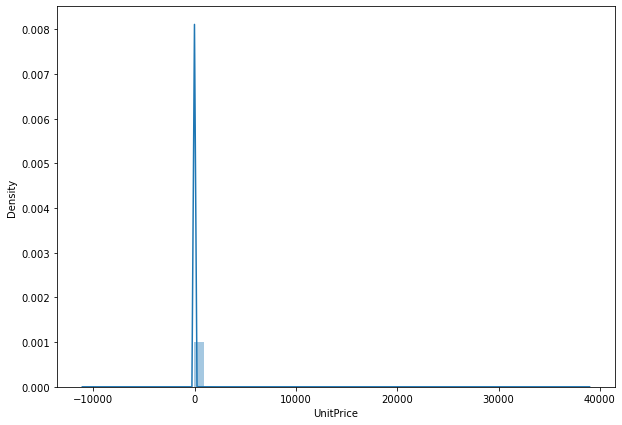

In [10]:
plt.figure(figsize=(10,7))
sns.distplot(df['UnitPrice'])
plt.show()

Two situations to investigate here are unit prices < 0 and unit prices = 0.

In [11]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,10-Aug-17,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,10-Aug-17,-11062.06,NaN,United Kingdom


1. UnitPrice < 0 refers to adjustments of bad debt with no CustomerID associated with the occurrences. I will remove those instances.

In [12]:
dfmod = df.copy()
dfmod.drop(index=dfmod[dfmod['UnitPrice'] < 0].index,inplace=True)

2. Items with UnitPrice = 0 might possibly represent gifts, giveaways, or losses for defects. The majority of these examples have no CustomerID associated.

In [13]:
dfmod[dfmod['UnitPrice'] == 0].head(30)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,29-Nov-16,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,29-Nov-16,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,29-Nov-16,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,29-Nov-16,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,29-Nov-16,0.0,NaN,United Kingdom
1988,536550,85044,NaN,1,29-Nov-16,0.0,NaN,United Kingdom
2024,536552,20950,NaN,1,29-Nov-16,0.0,NaN,United Kingdom
2025,536553,37461,NaN,3,29-Nov-16,0.0,NaN,United Kingdom
2026,536554,84670,NaN,23,29-Nov-16,0.0,NaN,United Kingdom
2406,536589,21777,NaN,-10,29-Nov-16,0.0,NaN,United Kingdom


In [14]:
# Some StockCodes that appear in the above list have more than one description, but only one 
# of those is related to a product.

dfmod[dfmod['StockCode'] == '22139']['Description'].unique()

array(['RETROSPOT TEA SET CERAMIC 11 PC ', nan, 'amazon'], dtype=object)

In [15]:
dfmod[dfmod['StockCode'] == '37509']['Description'].unique()

array([nan, 'NEW ENGLAND MUG W GIFT BOX'], dtype=object)

I will remove from the data all occurrences where Description and CustomerID are missing and UnitPrice = 0, because a transaction without a CustomerID is not valid in the context of the business problem.

In [16]:
dfmod.drop(index=df[(df['Description'].isnull())\
                    &(df['CustomerID'].isnull())\
                    &(df['UnitPrice']==0)].index,
           inplace=True)

In [17]:
# Now only instances with a Description were left.
dfmod[dfmod['UnitPrice'] == 0].head(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6391,536941,22734,amazon,20,1-Dec-16,0.0,NaN,United Kingdom
6392,536942,22139,amazon,15,1-Dec-16,0.0,NaN,United Kingdom
7313,537032,21275,?,-30,1-Dec-16,0.0,NaN,United Kingdom
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,3-Dec-16,0.0,12647.0,Germany
13217,537425,84968F,check,-20,4-Dec-16,0.0,NaN,United Kingdom
13218,537426,84968E,check,-35,4-Dec-16,0.0,NaN,United Kingdom
13264,537432,35833G,damages,-43,4-Dec-16,0.0,NaN,United Kingdom
14335,537534,85064,CREAM SWEETHEART LETTER RACK,1,5-Dec-16,0.0,NaN,United Kingdom
14336,537534,84832,ZINC WILLIE WINKIE CANDLE STICK,1,5-Dec-16,0.0,NaN,United Kingdom
14337,537534,84692,BOX OF 24 COCKTAIL PARASOLS,2,5-Dec-16,0.0,NaN,United Kingdom


Now, the examples where UnitPice = 0 and CustomerID = NaN will be removed.

In [18]:
dfmod.drop(index=dfmod[(dfmod['CustomerID'].isnull())\
                       &(dfmod['UnitPrice']==0)].index,
           inplace=True)
dfmod.shape

(539432, 8)

In [19]:
dfmod[dfmod['UnitPrice']==0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,3-Dec-16,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,14-Dec-16,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,19-Dec-16,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,4-Jan-17,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,4-Jan-17,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,11-Jan-17,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,8-Feb-17,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,21-Mar-17,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,28-Mar-17,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2-Apr-17,0.0,14410.0,United Kingdom


Data still have transactions with items of UnitPrice = 0, but now the occurrences are related to a CustomerID. I consider those transactions legitimate, but do they matter in this business problem? If these examples represent gifts given to the customers, we can have an insight about who and how the company is current rewarding. I will keep these examples for now.

In [20]:
dfmod[dfmod['UnitPrice']>0].sort_values(by='UnitPrice',ascending=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,13-Apr-17,0.001,13952.0,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,24-Jul-17,0.001,15618.0,United Kingdom
361741,568375,BANK CHARGES,Bank Charges,1,24-Sep-17,0.001,13405.0,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,23-Sep-17,0.001,16198.0,United Kingdom
108088,C545478,D,Discount,-720,1-Mar-17,0.010,16422.0,United Kingdom
...,...,...,...,...,...,...,...,...
15016,C537630,AMAZONFEE,AMAZON FEE,-1,5-Dec-16,13541.330,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,3-Jan-17,16453.710,NaN,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,3-Jan-17,16888.020,NaN,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,3-Dec-17,17836.460,NaN,United Kingdom


There are items of very small unit prices, like PADS TO MATCH ALL CUSHIONS and Bank Charges, as well as items of very large unit prices, like AMAZON FEE (not related with a customer id) and Manual. 

In [21]:
dfmod[dfmod['UnitPrice']==0.001]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,13-Apr-17,0.001,13952.0,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,24-Jul-17,0.001,15618.0,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,23-Sep-17,0.001,16198.0,United Kingdom
361741,568375,BANK CHARGES,Bank Charges,1,24-Sep-17,0.001,13405.0,United Kingdom


In [22]:
dfmod[dfmod['Description']=='Bank Charges']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4406,536779,BANK CHARGES,Bank Charges,1,30-Nov-16,15.000,15823.0,United Kingdom
14435,C537572,BANK CHARGES,Bank Charges,-1,5-Dec-16,95.380,NaN,United Kingdom
28992,C538680,BANK CHARGES,Bank Charges,-1,11-Dec-16,966.920,NaN,United Kingdom
62508,541505,BANK CHARGES,Bank Charges,1,16-Jan-17,15.000,15939.0,United Kingdom
64573,C541653,BANK CHARGES,Bank Charges,-1,18-Jan-17,1050.150,NaN,United Kingdom
90558,C544049,BANK CHARGES,Bank Charges,-1,13-Feb-17,566.370,NaN,United Kingdom
96675,C544575,BANK CHARGES,Bank Charges,-1,19-Feb-17,134.760,NaN,United Kingdom
96676,C544576,BANK CHARGES,Bank Charges,-1,19-Feb-17,149.160,NaN,United Kingdom
96715,C544584,BANK CHARGES,Bank Charges,-1,19-Feb-17,109.840,NaN,United Kingdom
112233,C545887,BANK CHARGES,Bank Charges,-1,5-Mar-17,326.680,NaN,United Kingdom


I belive that bank charges are costs passed on to customers, it is not a product with which the company monetize. I will remove those occurrences from data.

In [23]:
dfmod.drop(index=dfmod[dfmod['Description']=='Bank Charges'].index, 
           inplace=True)
dfmod.shape

(539395, 8)

In [24]:
dfmod.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132578
Country             0
dtype: int64

### Remove transactions with missing CustomerID

CustomerID still has missing values. Each row in the data set represents an item in a transaction. So, I will check if the CustomerID is missing in all the rows that belong to the same transaction. If true, the occurrences with missing CustomerID will be removed. 

In [25]:
customer_missing = [customer for customer in dfmod[dfmod['CustomerID'].isnull()]\
                                                                      .groupby('InvoiceNo')['CustomerID']\
                                                                      .unique() 
                    if len(customer)>1]

if len(customer_missing) == 0:
    print('No CustomerID was found in transactions with missing CustomerID.')

No CustomerID was found in transactions with missing CustomerID.


In [26]:
dfmod.drop(index=dfmod[dfmod['CustomerID'].isnull()].index,
           inplace=True)
dfmod.shape

(406817, 8)

In [27]:
dfmod.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [28]:
dfmod.describe()

,Quantity,UnitPrice,CustomerID
count,406817.000000,406817.000000,406817.000000
mean,12.061630,3.460168,15287.700558
std,248.697031,69.316158,1713.610272
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Exploring Quantity

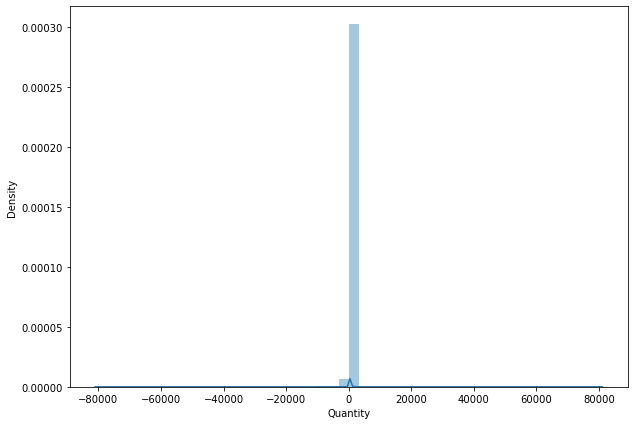

In [29]:
plt.figure(figsize=(10,7))
sns.distplot(dfmod['Quantity'])
plt.show()

In [30]:
dfmod[dfmod['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,29-Nov-16,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,29-Nov-16,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,29-Nov-16,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,29-Nov-16,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,29-Nov-16,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,7-Dec-17,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,7-Dec-17,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,7-Dec-17,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,7-Dec-17,1.25,17315.0,United Kingdom


Notice that all InvoiceNo have a letter C, which can be related to canceled transactions, returns or discounts. All transactions of this group have a letter C in the InvoiceNo.

In [31]:
# All the InvoiceNo with a letter C have negative quanties.
C_transactions = [value for value in dfmod['InvoiceNo'].unique() if re.search('C[0-9]+',value)]
dfmod[dfmod['Quantity'] < 0]['InvoiceNo'].unique().tolist() == C_transactions

True

In [32]:
# How many transactions were canceled/returned? 
dfmod[dfmod['Quantity'] < 0]['InvoiceNo'].nunique()

3654

The data dictionary of the transaction database does not provide what exactly the invoice numbers begining with a letter C are related to. Thus, let's explore the transactions of some customers belonging to that group.

In [56]:
description_as_set = dfmod.groupby('InvoiceNo').agg({'Description': set,
                                      'InvoiceDate': lambda x: x.unique(),
                                      'CustomerID':lambda x: x.unique(),
                                      'Country':lambda x: x.unique(),
                                      'UnitPrice': sum,
                                      'Quantity': sum}).reset_index()

In [57]:
# Cutomer 14527 have lots of discounts
description_as_set[description_as_set['CustomerID']==14527.0].tail(40)

,InvoiceNo,Description,InvoiceDate,CustomerID,Country,UnitPrice,Quantity
14625,572660,"{TOY TIDY DOLLY GIRL DESIGN, RETROSPOT HEART H...",23-Oct-17,14527.0,United Kingdom,101.93,50
15073,573572,"{WHITE METAL LANTERN, RECYCLING BAG RETROSPOT ...",29-Oct-17,14527.0,United Kingdom,165.32,54
15580,574871,"{WOODEN CROQUET GARDEN SET, BROWN CHECK CAT DO...",5-Nov-17,14527.0,United Kingdom,98.38,29
16014,575855,"{RETROSPOT HEART HOT WATER BOTTLE, CHOCOLATE H...",9-Nov-17,14527.0,United Kingdom,112.94,76
16407,576704,"{VICTORIAN SEWING BOX LARGE, TOY TIDY DOLLY GI...",14-Nov-17,14527.0,United Kingdom,108.12,34
17092,578231,"{VICTORIAN SEWING BOX LARGE, PINK FAIRY CAKE C...",21-Nov-17,14527.0,United Kingdom,164.53,66
17369,578923,"{VICTORIAN SEWING BOX LARGE, BREAD BIN DINER S...",25-Nov-17,14527.0,United Kingdom,129.15,50
17789,580043,"{JUMBO BAG RED RETROSPOT, CHILDRENS CUTLERY PO...",29-Nov-17,14527.0,United Kingdom,143.62,63
18310,581114,"{RETROSPOT HEART HOT WATER BOTTLE, BREAD BIN D...",5-Dec-17,14527.0,United Kingdom,205.37,60
18525,C536379,{Discount},29-Nov-16,14527.0,United Kingdom,27.50,-1


Customer 17548 placed an order on 2017-04-18 and a C_transaction appeared a few days later, on 2017-05-04, with the same products bought in the former order. This pattern seems to represent a return of products. This information indicates that C_transactions are related to returns. In this case, they have to be considered in the calculation of the monetary value spent by each customer. Furthermore, this customer has another C_transaction placed on 2016-11-29, because this is the first date in the database, it is assumed that this order was placed before data being collected.

In [58]:
description_as_set[description_as_set['CustomerID']==17548.0]

,InvoiceNo,Description,InvoiceDate,CustomerID,Country,UnitPrice,Quantity
5570,550755,"{RIBBON REEL FLORA + FAUNA , RIBBON REEL HEART...",18-Apr-17,17548.0,United Kingdom,12.15,58
18527,C536391,"{PACK OF 12 RED RETROSPOT TISSUES , PACK OF 12...",29-Nov-16,17548.0,United Kingdom,9.27,-132
19869,C552049,"{RIBBON REEL FLORA + FAUNA , RIBBON REEL HEART...",4-May-17,17548.0,United Kingdom,12.15,-58


### Looking for C_transactions and valid transactions with the same InvoiceNo

Looking for correspondences between C_transactions and valid transactions in the form of pairs such as (**581490**, C**581490**). To do that, I will remove the letter C from canceled InvoiceNo and search for valid transactions with the same number.

In [113]:
remove_C_invoiceNo = [re.findall(r'\d+', transaction)[0] for transaction in C_transactions]

comp = [(i,j) for i in dfmod[~dfmod['InvoiceNo'].isin(C_transactions)]['InvoiceNo'].unique() 
       for j in remove_C_invoiceNo if i == j]

if len(comp) == 0:
    print('No match was found. All C_transactions are unique.')

No match was found. All C_transactions are unique.


### Searching for matchs between C_transactions and valid transactions

In [36]:
# Customers with C_transactions
customer_with_C_transaction = dfmod[dfmod['InvoiceNo'].isin(C_transactions)]['CustomerID'].unique()

stockCode_as_set = dfmod.groupby('InvoiceNo').agg({'StockCode': set,
                                      'InvoiceDate': lambda x: x.unique(),
                                      'CustomerID':lambda x: x.unique()}).reset_index()
stockCode_as_set['InvoiceDate'] = pd.to_datetime(stockCode_as_set['InvoiceDate'])

valid_transactions = stockCode_as_set[~stockCode_as_set['InvoiceNo'].isin(C_transactions)]
return_transactions = stockCode_as_set[stockCode_as_set['InvoiceNo'].isin(C_transactions)]

In [131]:
match_products = search_match_products(customer_with_C_transaction,
                                       valid_transactions,
                                       return_transactions,
                                       time_interval=25)

In [132]:
# Save match_products
match_products

{14527.0: [['C536379'],
  ['C537164'],
  ['C539003'],
  ['C539589'],
  ['C540171'],
  ['C543840'],
  ['C545476'],
  ['C546106'],
  ['C548462'],
  ['C549288'],
  ['C551265'],
  ['C552423'],
  ['C553482'],
  ['C553665'],
  ['C554516'],
  ['C556037'],
  ['C556735', '556023'],
  ['C556904'],
  ['C559992'],
  ['C560842'],
  ['C561464'],
  ['C564812'],
  ['C565313'],
  ['C566475'],
  ['C567896'],
  ['C569829'],
  ['C572659'],
  ['C573081'],
  ['C577227'],
  ['C579884'],
  ['C579908']],
 15311.0: [['C536383'],
  ['C537805', '536381', '537195'],
  ['C538650', '536381', '537195', '538076'],
  ['C539640', '536381', '537195', '538651', '538857', '539247'],
  ['C541573', '541293'],
  ['C542032', '541293'],
  ['C542866', '541293'],
  ['C545650', '543463', '545288'],
  ['C546645', '544777', '546528'],
  ['C548851', '546384', '548856', '548863'],
  ['C548857', '546384', '548856', '548863'],
  ['C549544', '548863', '549542'],
  ['C550494', '548856', '548863', '549104', '550493'],
  ['C551841', '549542

There are some C_transactions that had no correspondent product with any valid_transaction in the database. Reasons for this are:
1. c_transaction is a discount
2. c_transaction have a manual discription
3. the valid transaction was placed before the data being collected.
4. time interval between purchases is bigger than the time interval used in the search.
5. products in c_transaction are not in the valid transactions.

In [41]:
# c_transaction is a discount.
description_as_set[description_as_set['InvoiceNo'].isin(['C537164'])]

,InvoiceNo,Description,InvoiceDate,CustomerID,UnitPrice,Quantity
18566,C537164,{Discount},2016-12-03,14527.0,29.29,-1


In [42]:
# the valid transaction was placed before the data being collected.
description_as_set[description_as_set['InvoiceNo'].isin(['C536383'])]

,InvoiceNo,Description,InvoiceDate,CustomerID,UnitPrice,Quantity
18526,C536383,{SET OF 3 COLOURED FLYING DUCKS},2016-11-29,15311.0,4.65,-1


In [82]:
# time interval between purchases is bigger than the time interval used in the search.
description_as_set[description_as_set['InvoiceNo'].isin(['C543636','C543767'])]

,InvoiceNo,Description,InvoiceDate,CustomerID,Country,UnitPrice,Quantity
19144,C543636,{ALARM CLOCK BAKELIKE RED },8-Feb-17,13767.0,United Kingdom,3.75,-1
19175,C543767,"{ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...",9-Feb-17,13767.0,United Kingdom,7.50,-2


In [84]:
# The alarm clocks returned by customer 13767 we bought more than 30 days before the return.
dfmod[(dfmod['Description'].str.contains("ALARM CLOCK BAKELIKE RED"))&(dfmod['CustomerID']==13767)].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
272,536395,22727,ALARM CLOCK BAKELIKE RED,8,29-Nov-16,3.75,13767.0,United Kingdom
4559,536794,22727,ALARM CLOCK BAKELIKE RED,48,30-Nov-16,3.75,13767.0,United Kingdom
9065,537179,22727,ALARM CLOCK BAKELIKE RED,12,3-Dec-16,3.75,13767.0,United Kingdom
23508,538203,22727,ALARM CLOCK BAKELIKE RED,10,8-Dec-16,3.75,13767.0,United Kingdom
30724,538878,22727,ALARM CLOCK BAKELIKE RED,8,12-Dec-16,3.75,13767.0,United Kingdom
44402,540170,22727,ALARM CLOCK BAKELIKE RED,8,3-Jan-17,3.75,13767.0,United Kingdom
51681,540662,22727,ALARM CLOCK BAKELIKE RED,8,8-Jan-17,3.75,13767.0,United Kingdom
87149,C543636,22727,ALARM CLOCK BAKELIKE RED,-1,8-Feb-17,3.75,13767.0,United Kingdom
88099,C543767,22727,ALARM CLOCK BAKELIKE RED,-1,9-Feb-17,3.75,13767.0,United Kingdom
93832,544314,22727,ALARM CLOCK BAKELIKE RED,8,15-Feb-17,3.75,13767.0,United Kingdom


### Products in C_transactions are in valid transactions?

In [109]:
products_val_transactions = pd.DataFrame({'stockCode_val_transaction': dfmod[~dfmod['InvoiceNo']\
                                                                             .isin(C_transactions)]['StockCode']\
                                                                             .unique()
                                         }
                                        )
products_c_transactions = pd.DataFrame({'stockCode_c_transaction': dfmod[dfmod['InvoiceNo']\
                                                                        .isin(C_transactions)]['StockCode']\
                                                                        .unique()
                                       }
                                      )
products = products_val_transactions.merge(right=products_c_transactions,
                                           how='outer',
                                           left_on='stockCode_val_transaction',
                                           right_on='stockCode_c_transaction')

In [117]:
# Products in C_transactions but not in valid transactions
stock_not_inValid = products[products['stockCode_val_transaction'].isnull()]['stockCode_c_transaction'].values

In [119]:
dfmod[dfmod['StockCode'].isin(stock_not_inValid)]['Description'].unique()

array(['Discount', 'PORCELAIN HANGING BELL SMALL',
       'CREAM SWEETHEART SHELF + HOOKS',
       'WOOLLY HAT SOCK GLOVE ADVENT STRING',
       'TEA TIME CAKE STAND IN GIFT BOX',
       'PINK POODLE HANGING DECORATION ', 'VINTAGE GOLD TINSEL REEL',
       'FLAMINGO LIGHTS', 'ANTIQUE LILY FAIRY LIGHTS',
       'ASSORTED TUTTI FRUTTI ROUND BOX', 'PINK LARGE JEWELED PHOTOFRAME',
       'WHITE CHERRY LIGHTS', 'LARGE ROUND CUTGLASS CANDLESTICK',
       'CREAM SWEETHEART MAGAZINE RACK', 'CREAM SWEETHEART TRAYS',
       'BLUE FLYING SINGING CANARY', 'SWEETHEART KEY CABINET',
       'SMALL TAHITI BEACH BAG', 'CRUK Commission'], dtype=object)

In [184]:
dfmod[(dfmod['StockCode'].isin(stock_not_inValid))&(~dfmod['Description'].str.contains('Discount'))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1985,C536548,20957,PORCELAIN HANGING BELL SMALL,-1,29-Nov-16,1.45,12472.0,Germany
17453,C537763,85068,CREAM SWEETHEART SHELF + HOOKS,-1,6-Dec-16,7.95,16713.0,United Kingdom
29282,C538726,35832,WOOLLY HAT SOCK GLOVE ADVENT STRING,-1,12-Dec-16,2.95,13078.0,United Kingdom
31136,C538898,37503,TEA TIME CAKE STAND IN GIFT BOX,-1,13-Dec-16,10.75,15078.0,United Kingdom
44298,C540164,21144,PINK POODLE HANGING DECORATION,-12,3-Jan-17,0.38,14911.0,EIRE
44299,C540164,21412,VINTAGE GOLD TINSEL REEL,-6,3-Jan-17,0.42,14911.0,EIRE
44916,C540246,79320,FLAMINGO LIGHTS,-1,3-Jan-17,4.95,13081.0,United Kingdom
44924,C540246,85042,ANTIQUE LILY FAIRY LIGHTS,-2,3-Jan-17,4.95,13081.0,United Kingdom
45915,C540307,21645,ASSORTED TUTTI FRUTTI ROUND BOX,-24,4-Jan-17,1.65,15823.0,United Kingdom
47170,C540393,85042,ANTIQUE LILY FAIRY LIGHTS,-1,4-Jan-17,4.95,17428.0,United Kingdom


Table above presents the items that occurred in C_transactions but not in valid transactions. Notice how the majority of occurrences were recorded until January 2017 (except CRUK Commission, which I don't believe to be a product return). From what I have seen so far in the data, returns were made within an impressive time interval of more than 3 months since the purchase was placed. See the example of customer 13078.0 shown below. Considering that, I am reasonably sure that these products belong to purshases placed before 29-Nov-16, when the data was collected. Maybe this products were discontinued, reason why they do not appear in any current valid transaction. I will remove these examples from the data, because the purchases they came from are not available. 

##### Customer 13078.0 returned a product bought at least 3 months before

In [162]:
dfmod[dfmod['InvoiceNo']=='C559467']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
256259,C559467,21464,DISCO BALL ROTATOR BATTERY OPERATED,-1,6-Jul-17,4.25,13078.0,United Kingdom


In [163]:
dfmod[(dfmod['Description'].str.contains("DISCO BALL ROTATOR"))&(dfmod['CustomerID']==13078.0)].head(6)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
31143,538900,21464,DISCO BALL ROTATOR BATTERY OPERATED,2,13-Dec-16,4.25,13078.0,United Kingdom
52449,540795,21464,DISCO BALL ROTATOR BATTERY OPERATED,2,9-Jan-17,4.25,13078.0,United Kingdom
115397,546118,21464,DISCO BALL ROTATOR BATTERY OPERATED,2,7-Mar-17,4.25,13078.0,United Kingdom
138937,548255,21464,DISCO BALL ROTATOR BATTERY OPERATED,2,28-Mar-17,4.25,13078.0,United Kingdom
150540,549448,21464,DISCO BALL ROTATOR BATTERY OPERATED,6,6-Apr-17,4.25,13078.0,United Kingdom
256259,C559467,21464,DISCO BALL ROTATOR BATTERY OPERATED,-1,6-Jul-17,4.25,13078.0,United Kingdom


CRUK Commission	 is another item present only in C_transactions. I have found out that CRUK might be the abbreviation for Cancer Research UK, a charity company that funds research against cancer. Maybe UK retailer promoted campaigns to help the institution raise funds. I will remove these examples from the data. 

I will keep the items described as 'Discounts', though, because it is not possible to know if they are related to.

In [189]:
# Products with these StockCodes will be removed 
stock_not_inValid[1:]

array(['20957', '85068', '35832', '37503', '21144', '21412', '79320',
       '85042', '21645', '85023C', '79323W', '85126', '85063', '85065',
       '85098B', '84839', '84856S', 'CRUK'], dtype=object)

In [192]:
dfmod.drop(index = dfmod[dfmod['StockCode'].isin(stock_not_inValid[1:])].index,
           inplace = True)
dfmod.shape

(406782, 8)

### Exploring extreme values in UnitPrice

The distribution of the UnitPrice values is skewed to the right, due to the presence of large UnitPrice values. Let's investigate this.

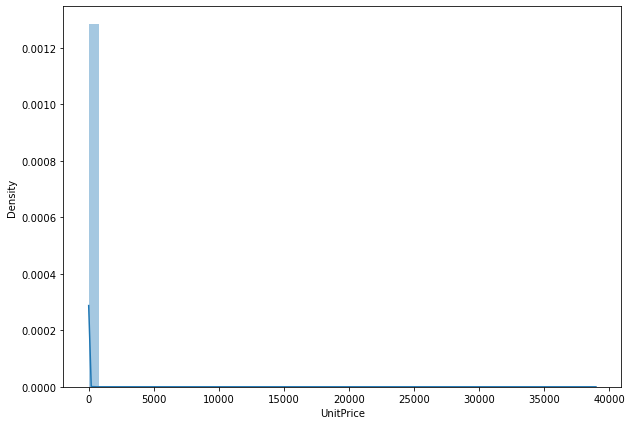

In [216]:
plt.figure(figsize=(10,7))
sns.distplot(dfmod['UnitPrice'])
plt.show()

In [217]:
# 99.9% of UnitPrices are below 50 pounds
unitprice_quartiles = dfmod['UnitPrice'].quantile(q=[0,0.25,0.5,0.75,0.95,0.999,1])
unitprice_quartiles

0.000        0.00
0.250        1.25
0.500        1.95
0.750        3.75
0.950        8.50
0.999       50.00
1.000    38970.00
Name: UnitPrice, dtype: float64

In [218]:
# Let's see the items with UnitPrice > 50
dfmod[dfmod['UnitPrice']>unitprice_quartiles.loc[0.999]]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
246,536392,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,29-Nov-16,165.00,13705.0,United Kingdom
3790,536676,21769,VINTAGE POST OFFICE CABINET,1,30-Nov-16,79.95,16752.0,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,30-Nov-16,295.00,13145.0,United Kingdom
14498,C537597,D,Discount,-1,5-Dec-16,281.00,15498.0,United Kingdom
16437,537659,21769,VINTAGE POST OFFICE CABINET,10,5-Dec-16,52.77,18102.0,United Kingdom
...,...,...,...,...,...,...,...,...
526015,580645,M,Manual,1,3-Dec-17,219.50,17857.0,United Kingdom
528082,580727,DOT,DOTCOM POSTAGE,1,3-Dec-17,1599.26,14096.0,United Kingdom
533082,C581009,M,Manual,-1,5-Dec-17,125.00,16971.0,United Kingdom
535003,581179,POST,POSTAGE,1,5-Dec-17,240.00,12471.0,Germany


In [219]:
dfmod[dfmod['UnitPrice']>unitprice_quartiles.loc[0.999]]['Description'].unique()

array(['RUSTIC  SEVENTEEN DRAWER SIDEBOARD',
       'VINTAGE POST OFFICE CABINET', 'VINTAGE RED KITCHEN CABINET',
       'Discount', 'REGENCY MIRROR WITH SHUTTERS',
       'LOVE SEAT ANTIQUE WHITE METAL', 'VINTAGE BLUE KITCHEN CABINET',
       'SCHOOL DESK AND CHAIR ', 'CHEST NATURAL WOOD 20 DRAWERS',
       'CARRIAGE', 'Manual', 'DECORATIVE HANGING SHELVING UNIT',
       'POSTAGE', 'PICNIC BASKET WICKER 60 PIECES', 'BROCADE RING PURSE ',
       'DOTCOM POSTAGE'], dtype=object)

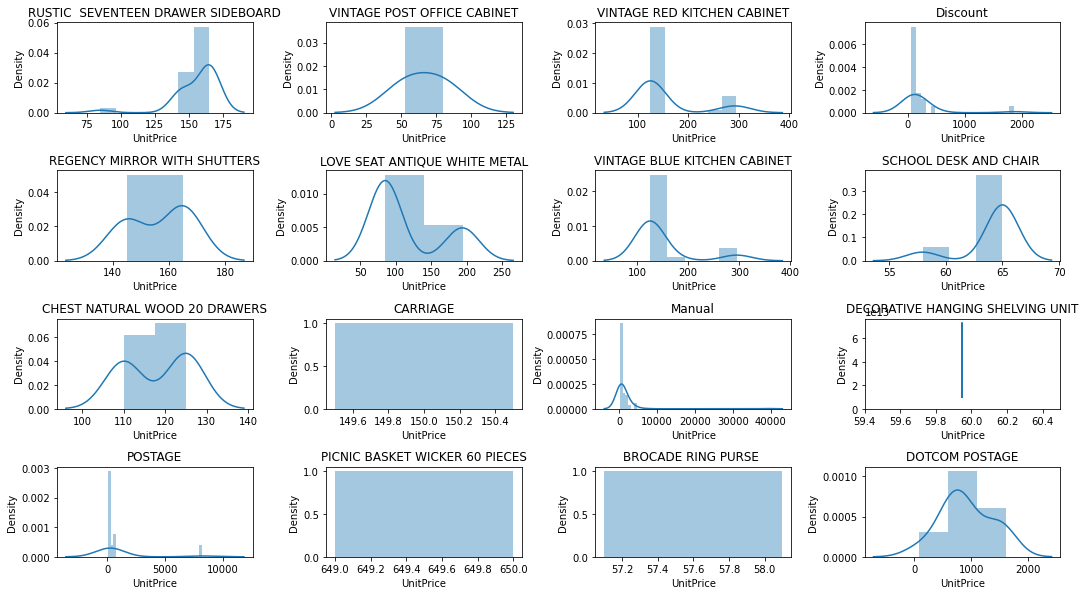

In [220]:
plt.figure(figsize=(15,10))
for i,description in enumerate(dfmod[dfmod['UnitPrice']>unitprice_quartiles.loc[0.999]]['Description'].unique()):
    plt.subplot(5,4,i+1)
    sns.distplot(dfmod[(dfmod['UnitPrice']>unitprice_quartiles.loc[0.999])
                       &(dfmod['Description']==description)]['UnitPrice'])
    plt.title(description)
plt.tight_layout()
plt.show()

Some products presented variations in the UnitPrice over 1 year of sales, what is a usual pattern. The product PICNIC BASKET WICKER 60 PIECES, costing £650.0, is the most expensive product in all transactions. 

The larger costs seem to be relate to postage (POSTAGE, DOTCOM POSTAGE). 'Manual' is another item that has a wide variance of unit prices. These are the items with UnitPrice > 650.00.

In [221]:
dfmod[dfmod['UnitPrice'] > 650]['Description'].unique()

array(['Manual', 'Discount', 'POSTAGE', 'DOTCOM POSTAGE'], dtype=object)

### Transactions with Manual description

In [222]:
manual = dfmod[dfmod['Description']=='Manual'].groupby(['InvoiceNo','CustomerID'])\
                                              .agg({'Description':len, 'UnitPrice':np.mean})\
                                              .sort_values(by='UnitPrice', ascending=False)\
                                              .reset_index()
manual

,InvoiceNo,CustomerID,Description,UnitPrice
0,C556445,15098.0,1,38970.00
1,C551699,16029.0,1,6930.00
2,C560372,17448.0,1,4287.63
3,573077,12536.0,1,4161.06
4,573080,12536.0,1,4161.06
...,...,...,...,...
407,574252,12437.0,1,0.00
408,568384,12748.0,1,0.00
409,577696,16406.0,1,0.00
410,577168,12603.0,1,0.00


In [224]:
# Transactions of customer 15098.0
dfmod[dfmod['CustomerID']==15098.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,8-Jun-17,4.95,15098.0,United Kingdom
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,8-Jun-17,649.50,15098.0,United Kingdom
222681,C556445,M,Manual,-1,8-Jun-17,38970.00,15098.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,8-Jun-17,649.50,15098.0,United Kingdom
222692,C556448,22502,PICNIC BASKET WICKER SMALL,-60,8-Jun-17,4.95,15098.0,United Kingdom


It seems that transaction C556445 is the return of transaction 556444 (60*649.5 = 38970.00) manually registered into the system. Thus, 'Manual' indicates manual adjustments. Considering the unit price variance of this item, it does not seem to be a specific product of the company portfolio. 

In [225]:
# Looking at transactions of customer 12536.0
# It is strange that two transactions with a manual description with the same value were done in the same day. 
 
dfmod[dfmod['InvoiceNo'].isin(['573077','573080'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
422351,573077,M,Manual,1,25-Oct-17,4161.06,12536.0,France
422376,573080,M,Manual,1,25-Oct-17,4161.06,12536.0,France


In [226]:
# Looking at all transactions of customer 12536.0
test = df[df['CustomerID']==12536.0]
test['sales'] = test['UnitPrice']*test['Quantity']
test.groupby('InvoiceNo').agg({'InvoiceDate': lambda x: x.unique(), 'Description':list, 'sales':sum})

,InvoiceDate,Description,sales
InvoiceNo,,,
570672,9-Oct-17,"[ORIGAMI VANILLA INCENSE/CANDLE SET , ORIGAMI ...",4279.71
573077,25-Oct-17,[Manual],4161.06
573080,25-Oct-17,[Manual],4161.06
C573079,25-Oct-17,[Manual],-8322.12
C580263,30-Nov-17,"[Manual, Manual, HI TEC ALPINE HAND WARMER, CA...",-172.89


An interesting pattern is observed here. Three transactions occurred on 25-Oct-17, two transactions have cost 4161.06 each and one canceled transaction is exactly the sum of the formers. Besides, they have only a manual description. I'm guessing that transactions with only manual description might also be cancelations from each other. Let's see if this might be true. 

In [228]:
from IPython.display import display

for i in manual['CustomerID'].unique():
    search = dfmod[dfmod['CustomerID']==i]
    search['sales'] = search['UnitPrice']*search['Quantity']
    search = search.groupby('InvoiceNo').agg({'InvoiceDate': lambda x: x.unique(),
                                              'Description':list, 'sales':sum})
    print('Customer: ', i)
    display(search)

Customer:  15098.0


,InvoiceDate,Description,sales
InvoiceNo,,,
556442,8-Jun-17,[PICNIC BASKET WICKER SMALL],297.0
556444,8-Jun-17,[PICNIC BASKET WICKER 60 PIECES],38970.0
556446,8-Jun-17,[PICNIC BASKET WICKER 60 PIECES],649.5
C556445,8-Jun-17,[Manual],-38970.0
C556448,8-Jun-17,[PICNIC BASKET WICKER SMALL],-297.0


Customer:  16029.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536386,29-Nov-16,"[WHITE WIRE EGG HOLDER, JUMBO BAG BAROQUE BLA...",508.20
536387,29-Nov-16,"[CHILLI LIGHTS, LIGHT GARLAND BUTTERFILES PINK...",3193.92
536831,30-Nov-16,"[WHITE WIRE EGG HOLDER, FRYING PAN UNION FLAG,...",569.40
539101,14-Dec-16,"[CHILLI LIGHTS, LIGHT GARLAND BUTTERFILES PINK...",6930.00
539102,14-Dec-16,"[PHOTO CUBE, LADIES & GENTLEMEN METAL SIGN, PL...",1431.60
...,...,...,...
C566613,11-Sep-17,[Discount],-15.00
C566614,11-Sep-17,[Discount],-102.24
C570552,9-Oct-17,"[JUMBO BAG STRAWBERRY, JUMBO BAG RED RETROSPOT...",-2076.00


Customer:  17448.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C560372,16-Jul-17,[Manual],-4287.63


Customer:  12536.0


,InvoiceDate,Description,sales
InvoiceNo,,,
570672,9-Oct-17,"[ORIGAMI VANILLA INCENSE/CANDLE SET , ORIGAMI ...",4279.71
573077,25-Oct-17,[Manual],4161.06
573080,25-Oct-17,[Manual],4161.06
C573079,25-Oct-17,[Manual],-8322.12
C580263,30-Nov-17,"[Manual, Manual, HI TEC ALPINE HAND WARMER, CA...",-172.89


Customer:  15502.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537216,3-Dec-16,"[LARGE HEART MEASURING SPOONS, KINGS CHOICE BI...",569.50
537217,3-Dec-16,"[BREAD BIN, DINER STYLE, MINT, BREAD BIN, DINE...",167.20
537407,4-Dec-16,"[TEA TIME DES TEA COSY, GREEN GIANT GARDEN THE...",192.70
546096,7-Mar-17,"[LARGE CIRCULAR MIRROR MOBILE, ASSORTED FLOWER...",1711.06
562608,6-Aug-17,"[LUNCH BAG CARS BLUE, LUNCH BAG SUKI DESIGN , ...",3315.07
566242,9-Sep-17,"[DOG BOWL CHASING BALL DESIGN, ILLUSTRATED CAT...",160.60
566243,9-Sep-17,[BREAD BIN DINER STYLE IVORY],33.90
566244,9-Sep-17,"[HAND WARMER BIRD DESIGN, HAND WARMER SCOTTY D...",126.00
569382,1-Oct-17,[Manual],3155.95


Customer:  18102.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537657,5-Dec-16,"[WOOD BLACK BOARD ANT WHITE FINISH, UTILTY CAB...",9639.12
537658,5-Dec-16,"[WOOD BLACK BOARD ANT WHITE FINISH, CREAM HEAR...",395.76
537659,5-Dec-16,"[NEWSPAPER STAND, MEMO BOARD RETROSPOT DESIGN...",15885.49
538063,7-Dec-16,[UTILTY CABINET WITH HOOKS],1914.24
543378,5-Feb-17,"[CREAM HEART CARD HOLDER, VINTAGE UNION JACK M...",4379.76
...,...,...,...
581455,6-Dec-17,"[BLACK HEART CARD HOLDER, CREAM HEART CARD HOL...",652.28
581457,6-Dec-17,"[BLACK HEART CARD HOLDER, CREAM HEART CARD HOL...",10363.82
581566,7-Dec-17,[HOME SWEET HOME BLACKBOARD],469.44


Customer:  12744.0


,InvoiceDate,Description,sales
InvoiceNo,,,
542102,23-Jan-17,"[GIN & TONIC DIET GREETING CARD , GREEN REGENC...",2053.07
548813,2-Apr-17,"[Manual, Manual, Manual, Manual]",4037.77
548820,2-Apr-17,[Manual],2053.07
548968,3-Apr-17,"[DOORMAT UNION FLAG, DOORMAT RESPECTABLE HOUSE...",2118.74
560360,16-Jul-17,"[WHITE WICKER STAR , PARTY PIZZA DISH RED RETR...",3949.32
571239,12-Oct-17,"[CHRISTMAS TREE PAINTED ZINC , DOVE DECORATION...",999.26
571751,17-Oct-17,"[Manual, Manual]",6068.06
C548830,2-Apr-17,"[Manual, Manual, Manual, Manual]",-4037.77
C548834,2-Apr-17,[Manual],-2053.07


Customer:  15581.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537826,6-Dec-16,"[GINGERBREAD MAN COOKIE CUTTER, SMALL POPCORN ...",272.34
539472,17-Dec-16,"[3D DOG PICTURE PLAYING CARDS, QUEEN OF THE SK...",31.62
539474,17-Dec-16,"[60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK ...",12.80
539660,19-Dec-16,"[TRADITIONAL WOODEN CATCH CUP GAME , 4 TRADITI...",9.20
546122,7-Mar-17,"[PARTY BUNTING, GAOLERS KEYS DECORATIVE GARDEN...",91.54
550197,13-Apr-17,"[CLASSIC FRENCH STYLE BASKET GREEN , CLASSIC F...",39.60
551137,24-Apr-17,"[CERAMIC HEART FAIRY CAKE MONEY BANK, FELT FAR...",172.75
551338,25-Apr-17,"[JUMBO BAG PINK VINTAGE PAISLEY, REX CASH+CARR...",5.11
557488,18-Jun-17,"[STRIPES DESIGN TEDDY, POSY CANDY BAG, JUMBO B...",18.88


Customer:  17846.0


,InvoiceDate,Description,sales
InvoiceNo,,,
566927,13-Sep-17,[Manual],2033.1


Customer:  17940.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543549,8-Feb-17,"[PACK OF 12 LONDON TISSUES , PACK OF 12 WOODLA...",1045.44
545911,6-Mar-17,"[PACK OF 12 WOODLAND TISSUES , PACK OF 12 LOND...",181.44
548910,3-Apr-17,"[PACK OF 12 SUKI TISSUES , PACK OF 12 LONDON T...",259.20
549468,6-Apr-17,[Manual],1867.86
552026,3-May-17,[PACK OF 12 WOODLAND TISSUES ],108.00
558352,26-Jun-17,[PACK OF 12 HEARTS DESIGN TISSUES ],107.50
558353,26-Jun-17,[PACK OF 12 LONDON TISSUES ],108.00
562155,1-Aug-17,"[PACK OF 12 LONDON TISSUES , PACK OF 12 PINK P...",162.00
564164,21-Aug-17,[PACK OF 12 LONDON TISSUES ],75.00


Customer:  12748.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536521,29-Nov-16,[CREAM SWEETHEART EGG HOLDER],4.95
536641,30-Nov-16,[GREEN CHRISTMAS TREE CARD HOLDER],4.25
537136,3-Dec-16,"[HANGING BAUBLE T-LIGHT HOLDER LARGE, YULETIDE...",273.76
537140,3-Dec-16,"[Manual, Manual, CRYSTAL FROG PHONE CHARM, ASS...",70.42
537142,3-Dec-16,"[VINTAGE CREAM DOG FOOD CONTAINER, AREA PATROL...",41.45
...,...,...,...
C568410,25-Sep-17,[POSTAGE],-80.00
C573268,26-Oct-17,[Manual],-907.00
C576831,14-Nov-17,"[LARGE WHITE HEART OF WICKER, BEADED CHANDELIE...",-1301.00


Customer:  12539.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540550,8-Jan-17,"[JAM JAR WITH PINK LID, JAM MAKING SET PRINTED...",1715.85
542303,25-Jan-17,"[SET/3 DECOUPAGE STACKING TINS, JARDIN ETCHED ...",1715.85
547387,20-Mar-17,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",1085.99
577039,15-Nov-17,"[POLKADOT RAIN HAT , LUNCH BAG PAISLEY PARK ,...",1050.66
C542348,25-Jan-17,[Manual],-1715.85


Customer:  14911.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536540,29-Nov-16,"[ROSE COTTAGE KEEPSAKE BOX , BLUE CHARLIE+LOLA...",540.38
536541,29-Nov-16,[RED HARMONICA IN BOX ],15.00
536803,30-Nov-16,[GREY HEART HOT WATER BOTTLE],22.50
536975,1-Dec-16,"[SILVER CHRISTMAS TREE BAUBLE STAND , METAL DE...",1705.65
537368,4-Dec-16,"[ASSORTED COLOUR MINI CASES, RED RETROSPOT MIN...",377.50
...,...,...,...
C575160,6-Nov-17,"[BISCUIT TIN 50'S CHRISTMAS, COLOUR GLASS. STA...",-14.09
C575327,7-Nov-17,[15CM CHRISTMAS GLASS BALL 20 LIGHTS],-15.90
C577388,16-Nov-17,"[ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",-96.15


Customer:  15369.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C560420,16-Jul-17,[Manual],-1592.49


Customer:  12757.0


,InvoiceDate,Description,sales
InvoiceNo,,,
553017,10-May-17,"[RED RETROSPOT UMBRELLA, BLUE ROSE FABRIC MIRR...",602.83
553018,10-May-17,[Manual],557.72
554155,21-May-17,[Manual],1241.98
554301,21-May-17,[Manual],1241.98
554305,21-May-17,[Manual],557.72
555862,5-Jun-17,"[JUMBO BAG SCANDINAVIAN BLUE PAISLEY, JUMBO BA...",243.20
560694,18-Jul-17,"[JUMBO BAG WOODLAND ANIMALS, JUMBO BAG SCANDIN...",835.65
569866,4-Oct-17,"[BIRDS MOBILE VINTAGE DESIGN, PINK PADDED MOBI...",1578.87
569870,4-Oct-17,"[SET OF 4 KNICK KNACK TINS POPPIES, SET OF 4 K...",151.90


Customer:  12669.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547892,26-Mar-17,"[IVORY DINER WALL CLOCK, BLUE DINER WALL CLOCK...",1136.30
548913,3-Apr-17,[Manual],1136.30
559704,10-Jul-17,"[AIRLINE BAG VINTAGE JET SET RED, SUKI SHOULD...",471.43
C548914,3-Apr-17,[Manual],-1136.30


Customer:  12503.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C540271,4-Jan-17,[Manual],-1126.0


Customer:  14156.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536890,1-Dec-16,"[LAVENDER INCENSE 40 CONES IN TIN, ASSORTED IN...",322.20
541220,12-Jan-17,"[MEMO BOARD COTTAGE DESIGN, ROSE COTTAGE KEEPS...",16774.72
543114,1-Feb-17,"[WELCOME WOODEN BLOCK LETTERS, 3 HOOK PHOTO S...",788.06
543828,12-Feb-17,"[SET OF 6 HERB TINS SKETCHBOOK, SET OF 6 SPICE...",2024.57
544074,13-Feb-17,"[JUMBO BAG STRAWBERRY, JUMBO STORAGE BAG SUKI,...",856.26
...,...,...,...
C574496,2-Nov-17,[POPCORN HOLDER],-3.40
C574527,2-Nov-17,[CHOCOLATE HOT WATER BOTTLE],-96.96
C575174,6-Nov-17,[GLASS HEART T-LIGHT HOLDER ],-4.25


Customer:  13235.0


,InvoiceDate,Description,sales
InvoiceNo,,,
552864,9-May-17,"[HEART FILIGREE DOVE LARGE, IVORY HANGING DECO...",1031.07
C552876,10-May-17,[Manual],-929.90


Customer:  18087.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544612,20-Feb-17,[EMPIRE DESIGN ROSETTE],3202.92
565377,31-Aug-17,[Manual],852.80
C543671,9-Feb-17,"[RETROSPOT WOODEN HEART DECORATION, CHRISTMAS ...",-40.80
C560396,16-Jul-17,"[WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN ST...",-244.80


Customer:  17809.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536380,29-Nov-16,[JAM MAKING SET PRINTED],34.80
536954,1-Dec-16,[CHRISTMAS LIGHTS 10 VINTAGE BAUBLES],425.00
536957,1-Dec-16,"[BAKING SET SPACEBOY DESIGN, FELTCRAFT CUSHION...",791.70
543649,9-Feb-17,"[DOORMAT FANCY FONT HOME SWEET HOME, IVORY KIT...",610.20
549445,6-Apr-17,[DOORMAT UNION FLAG],270.00
552048,4-May-17,"[DOORMAT KEEP CALM AND COME IN, BUNTING , SPOT...",519.00
557416,18-Jun-17,[SOLDIERS EGG CUP ],90.00
562108,31-Jul-17,"[DOORMAT AIRMAIL , MIRRORED DISCO BALL , DISCO...",116.01
570248,8-Oct-17,[DOORMAT KEEP CALM AND COME IN],283.20


Customer:  17603.0


,InvoiceDate,Description,sales
InvoiceNo,,,
567868,20-Sep-17,"[SILVER HANGING T-LIGHT HOLDER, VINTAGE RED KI...",394.72
C546859,15-Mar-17,[Manual],-555.90
C560435,16-Jul-17,[Manual],-294.92
C560436,16-Jul-17,[Manual],-705.45
C572117,18-Oct-17,[BELLE JARDINIERE CUSHION COVER],-3.75


Customer:  16900.0


,InvoiceDate,Description,sales
InvoiceNo,,,
570127,5-Oct-17,"[SET OF 60 I LOVE LONDON CAKE CASES , PACK OF ...",752.68
577492,18-Nov-17,"[FAIRY CAKE FLANNEL ASSORTED COLOUR, POPART RE...",125.48
578126,21-Nov-17,"[POSTAGE, POPART WOODEN PENCILS ASST]",8.95
C570301,8-Oct-17,[Manual],-682.05
C579092,26-Nov-17,"[POSTAGE, POPART RECT PENCIL SHARPENER ASST]",-17.37


Customer:  13154.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C560430,16-Jul-17,[Manual],-611.86


Customer:  15299.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536809,30-Nov-16,[ASSORTED COLOUR T-LIGHT HOLDER],1003.20
536810,30-Nov-16,[CAMOUFLAGE LED TORCH],303.96
536811,30-Nov-16,[WEEKEND BAG VINTAGE ROSE PAISLEY],527.85
547154,19-Mar-17,[HOMEMADE JAM SCENTED CANDLES],600.00
558381,26-Jun-17,[Manual],600.00
569339,1-Oct-17,[GREY HEART HOT WATER BOTTLE],830.00
569340,1-Oct-17,[ROSE CARAVAN DOORSTOP],642.00
C543758,9-Feb-17,[Discount],-65.91
C550010,12-Apr-17,[ASSORTED COLOUR T-LIGHT HOLDER],-2.20


Customer:  13810.0


,InvoiceDate,Description,sales
InvoiceNo,,,
571215,12-Oct-17,"[WOODEN ADVENT CALENDAR RED, ADVENT CALENDAR G...",653.50
571223,12-Oct-17,[Manual],599.50
575733,9-Nov-17,"[ASSORTED COLOUR MINI CASES, COWBOYS AND INDIA...",246.01
C571220,12-Oct-17,[Manual],-599.50


Customer:  13564.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537441,4-Dec-16,"[FAMILY ALBUM WHITE PICTURE FRAME, BEWARE OF T...",540.00
539653,18-Dec-16,"[SET OF 6 T-LIGHTS SANTA, SET OF 6 T-LIGHTS SN...",658.38
560413,16-Jul-17,[Manual],550.64
C560408,16-Jul-17,[Manual],-550.64
C560414,16-Jul-17,[Manual],-550.64


Customer:  17450.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537448,5-Dec-16,[BATH BUILDING BLOCK WORD],39.60
537456,5-Dec-16,"[HEART OF WICKER SMALL, HEART OF WICKER LARGE]",1989.24
540689,9-Jan-17,"[RED HANGING HEART T-LIGHT HOLDER, WHITE HANGI...",12797.52
540691,9-Jan-17,"[NUMBER TILE VINTAGE FONT No , NUMBER TILE VIN...",1508.66
540698,9-Jan-17,"[ILLUSTRATED CAT BOWL , CAT BOWL VINTAGE CREAM...",4314.02
546067,7-Mar-17,"[HEART OF WICKER SMALL, VINTAGE UNION JACK BUN...",2099.70
547708,22-Mar-17,"[DAISY GARDEN MARKER, BIRDHOUSE GARDEN MARKER ...",11343.20
547718,23-Mar-17,[BLACK AND WHITE CAT BOWL],57.60
550710,18-Apr-17,"[VICTORIAN SEWING BOX SMALL , CAST IRON HOOK G...",3108.64


Customer:  12473.0


,InvoiceDate,Description,sales
InvoiceNo,,,
555162,30-May-17,"[RED RETROSPOT WRAP , BLUE POLKADOT WRAP, JUMB...",672.19
563540,15-Aug-17,"[BLUE OWL SOFT TOY, PINK SCOTTIE DOG W FLOWER ...",514.06
571328,15-Oct-17,"[STAR WOODEN CHRISTMAS DECORATION, WOODEN TREE...",1697.98
575632,8-Nov-17,"[Manual, Manual, Manual]",1013.86
575636,8-Nov-17,[Manual],40.46
C555163,30-May-17,[POSTAGE],-36.00
C555881,5-Jun-17,"[PLASTERS IN TIN CIRCUS PARADE , ROUND SNACK B...",-40.46
C575635,8-Nov-17,"[Manual, Manual]",-973.40
C575638,8-Nov-17,[Manual],-40.46


Customer:  17949.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536970,1-Dec-16,[REGENCY CAKESTAND 3 TIER],1314.00
540264,4-Jan-17,[SMALL POPCORN HOLDER],432.00
544698,21-Feb-17,[SMALL POPCORN HOLDER],259.20
544699,21-Feb-17,[SMALL POPCORN HOLDER],172.80
545341,28-Feb-17,[REGENCY CAKESTAND 3 TIER],1642.50
546319,9-Mar-17,[SMALL POPCORN HOLDER],345.60
551259,25-Apr-17,[REGENCY CAKESTAND 3 TIER],1642.50
552340,7-May-17,[UNION STRIPE WITH FRINGE HAMMOCK],417.00
552341,7-May-17,[WOODEN ROUNDERS GARDEN SET ],816.00


Customer:  16742.0


,InvoiceDate,Description,sales
InvoiceNo,,,
572423,22-Oct-17,[Manual],464.9
C572410,22-Oct-17,"[REGENCY SUGAR BOWL GREEN, ROSES REGENCY TEACU...",-464.9


Customer:  15802.0


,InvoiceDate,Description,sales
InvoiceNo,,,
560651,18-Jul-17,[Manual],451.42
C560645,18-Jul-17,[Manual],-451.42
C560653,18-Jul-17,[Manual],-451.42


Customer:  12619.0


,InvoiceDate,Description,sales
InvoiceNo,,,
548489,29-Mar-17,"[REGENCY CAKESTAND 3 TIER, CAKE STAND WHITE TW...",205.98
550625,17-Apr-17,"[MINI CAKE STAND T-LIGHT HOLDER, RETROSPOT PAR...",425.68
558895,2-Jul-17,[Manual],389.68
559987,12-Jul-17,"[PACK OF 60 MUSHROOM CAKE CASES, IVORY PAPER C...",688.00
563345,13-Aug-17,"[SET OF 12 MINI LOAF BAKING CASES, SET OF 60 I...",378.12
566586,11-Sep-17,"[PACK OF 60 MUSHROOM CAKE CASES, PACK OF 60 PI...",199.80
567958,21-Sep-17,"[PACK 3 BOXES BIRD PANNETONE , PACK 3 BOXES CH...",473.12
574653,4-Nov-17,"[RIBBON REEL HEARTS DESIGN , RIBBON REEL STRIP...",482.16
578298,21-Nov-17,"[SET OF 12 FAIRY CAKE BAKING CASES, SET OF 60 ...",398.70


Customer:  12352.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544156,14-Feb-17,"[WOODEN HAPPY BIRTHDAY GARLAND, PINK DOUGHNUT ...",296.50
545323,27-Feb-17,"[POSTAGE, DELUXE SEWING KIT , PINK HEART SHAPE...",144.35
545332,27-Feb-17,"[Manual, Manual, Manual]",840.30
546869,15-Mar-17,"[CERAMIC HEART FAIRY CAKE MONEY BANK, CERAMIC ...",120.33
547390,20-Mar-17,"[POSTAGE, PINK HEART SHAPE EGG FRYING PAN, CER...",160.33
567505,18-Sep-17,"[ANTIQUE GLASS PEDESTAL BOWL, PANTRY MAGNETIC ...",366.25
568699,26-Sep-17,"[OPEN CLOSED METAL SIGN, SET OF 6 SPICE TINS P...",266.25
574275,1-Nov-17,"[PETIT TRAY CHIC, PANTRY ROLLING PIN, PANTRY P...",311.73
C545329,27-Feb-17,"[Manual, Manual]",-463.80


Customer:  17728.0


,InvoiceDate,Description,sales
InvoiceNo,,,
566673,12-Sep-17,"[15CM CHRISTMAS GLASS BALL 20 LIGHTS, HANGING ...",345.03
569555,3-Oct-17,"[METAL SIGN DROP YOUR PANTS, COOK WITH WINE ME...",1943.13
580735,4-Dec-17,"[TRAVEL CARD WALLET VINTAGE TICKET, PACK OF 6 ...",587.85
C567155,14-Sep-17,[Manual],-345.03
C577351,16-Nov-17,"[RED SPOT CERAMIC DRAWER KNOB, CHILDRENS APRON...",-15.30


Customer:  12783.0


,InvoiceDate,Description,sales
InvoiceNo,,,
568208,23-Sep-17,"[BOX OF 6 MINI VINTAGE CRACKERS, BOX OF 6 MINI...",339.02
571188,12-Oct-17,"[CARD MOTORBIKE SANTA, WOOD BLACK BOARD ANT WH...",642.01
571324,15-Oct-17,[Manual],283.02
571326,15-Oct-17,[Manual],339.02
574844,5-Nov-17,"[ICON PLACEMAT POP ART ELVIS, SET OF 4 ENGLISH...",222.26
581182,5-Dec-17,"[GOLD PHOTO FRAME, ROSE CARAVAN DOORSTOP, LARG...",400.58
C571325,15-Oct-17,[Manual],-339.02
C571327,15-Oct-17,[Manual],-283.02


Customer:  15674.0


,InvoiceDate,Description,sales
InvoiceNo,,,
548215,28-Mar-17,"[JUMBO BAG PINK VINTAGE PAISLEY, SET OF 36 PAI...",355.12
548973,3-Apr-17,"[WHITE HANGING HEART T-LIGHT HOLDER, ZINC WILL...",355.12
552316,6-May-17,"[ZINC T-LIGHT HOLDER STARS SMALL, LUNCH BAG AP...",334.71
552549,8-May-17,[Manual],334.71
568553,25-Sep-17,"[JUMBO STORAGE BAG SUKI, JUMBO BAG OWLS, TOY T...",1066.94
C548972,3-Apr-17,"[WHITE HANGING HEART T-LIGHT HOLDER, ZINC WILL...",-355.12
C549922,11-Apr-17,[REGENCY CAKESTAND 3 TIER],-12.75
C552553,8-May-17,[Manual],-334.71


Customer:  12365.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544574,19-Feb-17,"[PARTY CONES CANDY ASSORTED, PINK CREAM FELT C...",320.69
544578,19-Feb-17,[Manual],320.69
C544577,19-Feb-17,[Manual],-320.69


Customer:  15935.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549739,10-Apr-17,[Manual],308.82
550131,12-Apr-17,"[SET OF 6 SPICE TINS PANTRY DESIGN, SWALLOWS G...",108.04


Customer:  14931.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549914,11-Apr-17,"[PACK OF 20 NAPKINS RED APPLES, APRON APPLE DE...",293.00
553559,15-May-17,[Manual],293.00
568242,24-Sep-17,"[SCANDINAVIAN 3 HEARTS NAPKIN RING, SET OF 20 ...",261.65
576904,15-Nov-17,"[ZINC FOLKART SLEIGH BELLS, SET OF 3 WOODEN HE...",211.63
580558,3-Dec-17,"[PAPER CHAIN KIT 50'S CHRISTMAS , PAPER CHAIN ...",198.40
C553560,15-May-17,[Manual],-293.00


Customer:  12428.0


,InvoiceDate,Description,sales
InvoiceNo,,,
545226,27-Feb-17,"[WOODLAND DESIGN COTTON TOTE BAG, ROSE DU SUD...",1943.40
545227,27-Feb-17,"[PENCIL CASE LIFE IS BEAUTIFUL, 36 PENCILS TUB...",2474.62
545336,27-Feb-17,[Manual],551.20
547086,18-Mar-17,"[RECYCLED ACAPULCO MAT RED, RECYCLED ACAPULCO ...",409.20
548363,28-Mar-17,"[BLUE POLKADOT BEAKER , BLUE POLKADOT COFFEE M...",558.40
549588,9-Apr-17,"[HOMEMADE JAM SCENTED CANDLES, SET OF 4 JAM JA...",373.72
559004,3-Jul-17,"[PINK DINER WALL CLOCK, PACK OF 60 PINK PAISLE...",632.44
563020,9-Aug-17,"[JUMBO BAG SCANDINAVIAN BLUE PAISLEY, JUMBO BA...",605.14
576082,12-Nov-17,"[PACK OF 12 VINTAGE DOILY TISSUES, JUMBO BAG W...",408.34


Customer:  17857.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537981,7-Dec-16,"[TRADITIONAL MODELLING CLAY, MINI PAINT SET VI...",1335.20
539288,14-Dec-16,[MINI PAINT SET VINTAGE ],5.50
544183,14-Feb-17,"[CERAMIC STRAWBERRY MONEY BOX, MAGIC DRAWING S...",786.84
546926,16-Mar-17,"[PINK HEARTS PAPER GARLAND, MAGIC DRAWING SLAT...",108.50
549027,3-Apr-17,"[ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI...",5424.00
551166,24-Apr-17,[CERAMIC STRAWBERRY MONEY BOX],918.00
551186,25-Apr-17,[MAGIC DRAWING SLATE PURDEY],25.20
551576,1-May-17,[MAGIC DRAWING SLATE PURDEY],21.60
553467,15-May-17,[TRADITIONAL MODELLING CLAY],159.00


Customer:  15498.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537771,6-Dec-16,"[STRAWBERRY CERAMIC TRINKET BOX, PHOTO CUBE, D...",450.92
537829,6-Dec-16,"[TEA TIME OVEN GLOVE, TEA TIME DES TEA COSY, K...",525.80
540114,3-Jan-17,"[HAND WARMER OWL DESIGN, CHICK GREY HOT WATER ...",243.40
541684,18-Jan-17,"[BLUE DINER WALL CLOCK, BLACK DINER WALL CLOCK...",1761.18
541950,22-Jan-17,"[DOORMAT RED RETROSPOT, SMALL GLASS HEART TRIN...",523.34
545842,5-Mar-17,"[REGENCY CAKESTAND 3 TIER, RECIPE BOX BLUE SKE...",557.00
545859,5-Mar-17,"[TRAVEL CARD WALLET KEEP CALM, DOORMAT HEARTS,...",593.92
550274,13-Apr-17,"[SLEEPING CAT ERASERS, STARS GIFT TAPE , CAKES...",344.40
552958,10-May-17,"[FOLDING BUTTERFLY MIRROR IVORY , DOORMAT KEEP...",463.20


Customer:  13811.0


,InvoiceDate,Description,sales
InvoiceNo,,,
550187,12-Apr-17,"[POSTAGE, RECYCLED ACAPULCO MAT GREEN, RECYCLE...",258.75
550354,16-Apr-17,[Manual],222.75
556118,7-Jun-17,"[POSTAGE, RECYCLED ACAPULCO MAT PINK, RECYCLED...",333.00
C550355,16-Apr-17,[Manual],-222.75


Customer:  15365.0


,InvoiceDate,Description,sales
InvoiceNo,,,
542530,26-Jan-17,"[FEATHER PEN,HOT PINK, SET 7 BABUSHKA NESTING ...",208.61
565451,2-Sep-17,"[PAPER LANTERN 9 POINT SNOW STAR, SET OF 10 LA...",752.67
567204,17-Sep-17,"[PAPER LANTERN 9 POINT SNOW STAR, SET OF 10 LA...",765.15
567205,17-Sep-17,"[CHRISTMAS CRAFT LITTLE FRIENDS, CHRISTMAS CRA...",218.72
576084,12-Nov-17,[PLAYING CARDS KEEP CALM & CARRY ON],15.00
576085,12-Nov-17,"[TRADITIONAL CHRISTMAS RIBBONS, RED SPOT GIFT...",218.72
576086,12-Nov-17,"[DOORMAT KEEP CALM AND COME IN, TRADTIONAL ALP...",135.45
C569982,4-Oct-17,[Manual],-218.72
C569985,4-Oct-17,"[COFFEE MUG CAT + BIRD DESIGN, COFFEE MUG DOG ...",-765.15


Customer:  17095.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540505,7-Jan-17,"[BROWN CHECK CAT DOORSTOP , RED HANGING HEART ...",313.15
543809,11-Feb-17,"[LILAC GAUZE BUTTERFLY LAMPSHADE, PINK/PURPLE ...",230.81
577016,15-Nov-17,"[JUMBO BAG RED RETROSPOT, JUMBO BAG BAROQUE B...",780.20
C540895,10-Jan-17,[RED RETROSPOT ROUND CAKE TINS],-9.95
C543841,12-Feb-17,[Manual],-208.16
C577096,15-Nov-17,[YELLOW GIANT GARDEN THERMOMETER],-17.85


Customer:  17873.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536559,29-Nov-16,"[ANT WHITE WIRE HEART SPIRAL, FEATHER PEN,COAL...",215.15
545558,1-Mar-17,"[HOME SWEET HOME METAL SIGN , LADIES & GENTLEM...",485.78
549967,11-Apr-17,"[NO SINGING METAL SIGN, LADIES & GENTLEMEN MET...",490.05
556070,6-Jun-17,"[Manual, HOME SWEET HOME METAL SIGN , HOT BATH...",396.14
567522,18-Sep-17,"[METAL SIGN DROP YOUR PANTS, CHOCOLATE THIS WA...",272.04
C549973,11-Apr-17,"[HAND OVER THE CHOCOLATE SIGN , NO SINGING M...",-94.80


Customer:  15521.0


,InvoiceDate,Description,sales
InvoiceNo,,,
548213,28-Mar-17,"[BOX OF VINTAGE JIGSAW BLOCKS , VINTAGE SNAP C...",475.69
548907,3-Apr-17,"[SET OF 16 VINTAGE SKY BLUE CUTLERY, SET OF 16...",505.00
552816,9-May-17,"[SPACEBOY CHILDRENS EGG CUP, ENAMEL WASH BOWL ...",258.40
552822,9-May-17,"[SMALL POPCORN HOLDER, RED RETROSPOT CUP, RED ...",428.69
560079,12-Jul-17,"[RED RETROSPOT WRAP , BLUE POLKADOT WRAP, SPAC...",449.20
565677,4-Sep-17,"[RED TOADSTOOL LED NIGHT LIGHT, SKULLS PARTY B...",192.40
565678,4-Sep-17,[TRADITIONAL WOODEN SKIPPING ROPE],17.40
573375,28-Oct-17,"[LUNCH BAG APPLE DESIGN, RED RETROSPOT CUP, LU...",673.42
C552343,7-May-17,[Manual],-125.00


Customer:  16971.0


,InvoiceDate,Description,sales
InvoiceNo,,,
573905,30-Oct-17,"[VINTAGE RED KITCHEN CABINET, SET OF 16 VINTAG...",357.21
C581009,5-Dec-17,[Manual],-125.00


Customer:  14808.0


,InvoiceDate,Description,sales
InvoiceNo,,,
557442,18-Jun-17,"[SCHOOL DESK AND CHAIR , SPACE CADET RED, NINJ...",679.62
558090,24-Jun-17,[SET/4 WHITE RETRO STORAGE CUBES ],79.90
558092,24-Jun-17,"[ROSE SCENT CANDLE IN JEWELLED BOX, COSY HOUR ...",172.89
559529,8-Jul-17,"[WATERING CAN BLUE ELEPHANT, RED TOADSTOOL LED...",430.05
559532,8-Jul-17,"[SET OF 36 PAISLEY FLOWER DOILIES, LAVENDER SC...",13.01
560393,16-Jul-17,"[4 SKY BLUE DINNER CANDLES, JUMBO BAG DOLLY GI...",470.84
568231,24-Sep-17,"[SPACEBOY GIFT WRAP, WRAP DOLLY GIRL, PINK DOU...",360.67
573510,29-Oct-17,"[RAINY LADIES BIRTHDAY CARD, RING OF ROSES BIR...",534.19
C558091,24-Jun-17,[SCHOOL DESK AND CHAIR ],-65.00


Customer:  17065.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C560572,17-Jul-17,[Manual],-112.35


Customer:  14096.0


,InvoiceDate,Description,sales
InvoiceNo,,,
564764,28-Aug-17,"[PINK HEART RED HANDBAG, RATTLE SNAKE EGGS, TR...",21.84
565383,31-Aug-17,"[RED RETROSPOT SHOPPER BAG, GOLD MINI TAPE MEA...",103.22
566217,7-Sep-17,"[SET OF 3 WOODEN HEART DECORATIONS, SET OF 3 W...",119.62
566566,11-Sep-17,"[PING! MICROWAVE PLATE, FOOD CONTAINER SET 3 L...",433.93
567656,19-Sep-17,"[PINK DIAMANTE PEN IN GIFT BOX, CRYSTAL SEA HO...",4936.65
568346,24-Sep-17,"[SPACE CADET WHITE, SET/2 RED RETROSPOT TEA TO...",3671.44
569246,1-Oct-17,"[JAZZ HEARTS ADDRESS BOOK, SPACE CADET BLACK, ...",2900.99
570488,8-Oct-17,"[JAZZ HEARTS ADDRESS BOOK, SPACE FROG, NINJA R...",3380.86
571441,15-Oct-17,"[COLOURING PENCILS BROWN TUBE, ASSTD DESIGN RA...",4050.61


Customer:  14437.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537883,7-Dec-16,"[ANTIQUE SILVER TEA GLASS ETCHED, JAM JAR WITH...",63.0
C560574,17-Jul-17,[Manual],-106.4


Customer:  16027.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543595,8-Feb-17,"[ANTIQUE SILVER TEA GLASS ETCHED, AGED GLASS S...",320.52
545185,26-Feb-17,[AGED GLASS SILVER T-LIGHT HOLDER],79.20
551907,3-May-17,"[AGED GLASS SILVER T-LIGHT HOLDER, WOODEN ROUN...",116.95
557100,14-Jun-17,"[AGED GLASS SILVER T-LIGHT HOLDER, RED BABY BU...",108.70
561170,23-Jul-17,"[WOODEN CROQUET GARDEN SET, HOMEMADE JAM SCENT...",150.85
566108,7-Sep-17,[AGED GLASS SILVER T-LIGHT HOLDER],158.40
C544437,16-Feb-17,[Manual],-82.50


Customer:  14527.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537159,3-Dec-16,"[CHOCOLATE HOT WATER BOTTLE, SCOTTIE DOG HOT W...",292.95
538012,7-Dec-16,"[KINGS CHOICE BISCUIT TIN, 15CM CHRISTMAS GLAS...",224.38
539002,13-Dec-16,"[HOT WATER BOTTLE BABUSHKA , GREY HEART HOT WA...",269.31
539588,18-Dec-16,"[HOT WATER BOTTLE I AM SO POORLY, GREY HEART H...",138.85
540169,3-Jan-17,"[GREEN CHRISTMAS TREE CARD HOLDER, 15CM CHRIST...",229.75
...,...,...,...
C572659,23-Oct-17,[Manual],-80.00
C573081,25-Oct-17,[Discount],-23.27
C577227,16-Nov-17,"[Discount, Discount, Discount, Discount]",-78.72


Customer:  13672.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540825,9-Jan-17,"[PINK CHERRY LIGHTS, HANGING RIDGE GLASS T-LIG...",62.13
543747,9-Feb-17,"[BLACK CHERRY LIGHTS, SET OF 3 BABUSHKA STACKI...",124.26
C540634,8-Jan-17,"[SET OF 3 BABUSHKA STACKING TINS, HANGING RIDG...",-62.13
C543744,9-Feb-17,"[SET OF 3 BABUSHKA STACKING TINS, HANGING RIDG...",-62.13
C543745,9-Feb-17,"[BLACK CHERRY LIGHTS, SET OF 3 BABUSHKA STACKI...",-62.13
C543749,9-Feb-17,[Manual],-71.46


Customer:  15527.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539609,18-Dec-16,"[BOX OF VINTAGE JIGSAW BLOCKS , WOODEN SCHOOL ...",221.40
542511,26-Jan-17,"[JUMBO BAG WOODLAND ANIMALS, LUNCH BAG WOODLAN...",358.90
551812,2-May-17,"[TRAVEL CARD WALLET RETRO PETALS, TRAVEL CARD ...",319.74
556416,8-Jun-17,"[ROSES REGENCY TEACUP AND SAUCER , PACK OF 6 P...",247.25
560357,16-Jul-17,"[WRAP ALPHABET POSTER , LUNCH BAG BLACK SKUL...",183.50
566262,9-Sep-17,"[SET OF 3 WOODEN TREE DECORATIONS, IVORY WICKE...",277.55
573822,30-Oct-17,"[JUMBO BAG 50'S CHRISTMAS , JUMBO BAG VINTAGE ...",641.10
577711,19-Nov-17,"[WRAP ALPHABET DESIGN, MAGIC DRAWING SLATE CIR...",180.34
C560317,16-Jul-17,"[GREEN GIANT GARDEN THERMOMETER, GLASS STAR FR...",-16.85


Customer:  16422.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537214,3-Dec-16,"[APPLE BATH SPONGE, RED RETROSPOT BOWL, SET/6 ...",1668.20
538892,12-Dec-16,[HANGING METAL STAR LANTERN],17.40
539561,18-Dec-16,"[PINK POLKADOT BOWL, PACK OF 20 SKULL PAPER NA...",339.72
540383,4-Jan-17,"[PINK HAPPY BIRTHDAY BUNTING, PLACE SETTING WH...",406.77
540565,8-Jan-17,[PAPER BUNTING COLOURED LACE],102.00
...,...,...,...
C560100,12-Jul-17,[Manual],-7.88
C561628,26-Jul-17,[Manual],-9.60
C562793,7-Aug-17,[Manual],-57.60


Customer:  12754.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543179,2-Feb-17,"[MONEY BOX FIRST ADE DESIGN, MONEY BOX KINGS C...",45.57
545845,5-Mar-17,"[FIRST AID TIN, BLACK MINI TAPE MEASURE , GOLD...",16.05
550344,16-Apr-17,"[WORLD WAR 2 GLIDERS ASSTD DESIGNS, MINI PAINT...",2949.12
C545739,5-Mar-17,[Manual],-45.57
C545891,5-Mar-17,[Manual],-16.05


Customer:  15291.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536376,29-Nov-16,"[HOT WATER BOTTLE TEA AND SYMPATHY, RED HANGIN...",328.80
539335,15-Dec-16,"[WOOD BLACK BOARD ANT WHITE FINISH, WOOD S/3 C...",320.10
540986,10-Jan-17,"[MEMO BOARD COTTAGE DESIGN, FAMILY PHOTO FRAME...",408.29
541436,16-Jan-17,"[BATH BUILDING BLOCK WORD, DOORMAT WELCOME PUP...",315.00
545889,5-Mar-17,[Manual],45.00
546310,8-Mar-17,"[DOORMAT FAIRY CAKE, DOORMAT SPOTTY HOME SWEET...",330.60
546782,15-Mar-17,"[PICTURE FRAME WOOD TRIPLE PORTRAIT, CREAM CUP...",232.40
548644,30-Mar-17,"[FOUR HOOK WHITE LOVEBIRDS, GARLAND WOODEN HA...",396.00
549046,4-Apr-17,"[BATH BUILDING BLOCK WORD, DOORMAT RED RETROSP...",303.40


Customer:  13408.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536394,29-Nov-16,"[FANCY FONT BIRTHDAY CARD, , HAND WARMER UNION...",1024.68
536848,1-Dec-16,"[PAPER CHAIN KIT VINTAGE CHRISTMAS, JUMBO STOR...",534.00
538631,11-Dec-16,"[FILIGRIS HEART WITH BUTTERFLY, CREAM HEART CA...",689.04
539078,14-Dec-16,"[12 PENCILS TALL TUBE SKULLS, 12 PENCILS TALL ...",379.68
539275,14-Dec-16,"[SET OF 20 VINTAGE CHRISTMAS NAPKINS, REGENCY ...",403.80
...,...,...,...
C570471,8-Oct-17,[CLASSIC GLASS COOKIE JAR],-11.25
C574238,1-Nov-17,"[Discount, Discount, Discount]",-63.13
C575841,9-Nov-17,[RED HARMONICA IN BOX ],-15.00


Customer:  15482.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539092,14-Dec-16,"[ANTIQUE SILVER TEA GLASS ENGRAVED, ANTIQUE SI...",527.04
539093,14-Dec-16,"[POLYESTER FILLER PAD 45x45cm, HOT WATER BOTTL...",196.60
548697,1-Apr-17,"[SALLE DE BAIN HOOK, RED RETROSPOT CAKE STAND,...",713.80
558126,25-Jun-17,"[WOOD 2 DRAWER CABINET WHITE FINISH, LARGE DEC...",666.06
571179,12-Oct-17,[Manual],40.00
572348,22-Oct-17,"[MARIE ANTOINETTE TRINKET BOX SILVER, MARIE AN...",360.00
572756,23-Oct-17,"[VANILLA SCENT CANDLE JEWELLED BOX, OCEAN SCEN...",360.00
574319,1-Nov-17,"[REGENCY CAKESTAND 3 TIER, ROSE 1 WICK MORRIS ...",1915.60
576137,12-Nov-17,"[POPCORN HOLDER, WOODEN FRAME ANTIQUE WHITE , ...",1617.56


Customer:  17223.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537396,4-Dec-16,"[Manual, GARDEN PATH JOURNAL, TRADITIONAL MODE...",292.84
543036,31-Jan-17,"[REGENCY CAKESTAND 3 TIER, POTTERING IN THE SH...",133.95


Customer:  15590.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C544814,21-Feb-17,[Manual],-30.19


Customer:  12471.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538174,8-Dec-16,"[SET OF 72 RETROSPOT PAPER DOILIES, PACK OF 7...",1982.41
538175,8-Dec-16,[POSTAGE],378.00
539395,15-Dec-16,"[RED COAT RACK PARIS FASHION, FRIDGE MAGNETS L...",1484.25
539398,15-Dec-16,[SET OF 3 CAKE TINS PANTRY DESIGN ],29.70
541093,11-Jan-17,"[TV DINNER TRAY DOLLY GIRL, PENCIL CASE LIFE I...",753.45
543056,1-Feb-17,"[SET OF 72 PINK HEART PAPER DOILIES, STRAWBERR...",947.40
544811,21-Feb-17,"[WRAP POPPIES DESIGN, WRAP DOILEY DESIGN, REV...",388.30
546920,16-Mar-17,"[WOODLAND CHARLOTTE BAG, SAVE THE PLANET COTTO...",845.32
546921,16-Mar-17,"[MOTHER'S KITCHEN SPOON REST , TREASURE ISLAND...",33.00


Customer:  17404.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538848,12-Dec-16,[SET OF 3 BABUSHKA STACKING TINS],1188.00
539338,15-Dec-16,"[WORLD WAR 2 GLIDERS ASSTD DESIGNS, 60 CAKE CA...",2646.30
542428,26-Jan-17,"[MAGIC DRAWING SLATE DOLLY GIRL , SET OF 3 CAK...",2938.76
546161,8-Mar-17,[GENTLEMAN SHIRT REPAIR KIT ],122.40
546530,12-Mar-17,"[GYMKHANA TREASURE BOOK BOX, BUFFALO BILL TREA...",4400.28
552957,10-May-17,"[60 TEATIME FAIRY CAKE CASES, SET OF 36 TEATIM...",2557.88
559145,4-Jul-17,"[SET OF 60 PANTRY DESIGN CAKE CASES , SET OF 6...",2825.10
561902,29-Jul-17,"[PACK OF 60 PINK PAISLEY CAKE CASES, 36 DOILIE...",3633.58
562285,2-Aug-17,"[FEATHER PEN,HOT PINK, ASSORTED COLOURS SILK FAN]",612.00


Customer:  16806.0


,InvoiceDate,Description,sales
InvoiceNo,,,
550191,12-Apr-17,"[BROCANTE SHELF WITH HOOKS, RIDGED GLASS FINGE...",241.29
551714,1-May-17,"[SET OF 2 ROUND TINS DUTCH CHEESE, 3 HOOK PHOT...",173.08
557855,21-Jun-17,"[RIDGED GLASS FINGER BOWL, GAOLERS KEYS DECORA...",127.19
564745,26-Aug-17,"[FAMILY ALBUM WHITE PICTURE FRAME, 3 HOOK PHOT...",259.93


Customer:  15823.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C540307,4-Jan-17,"[PIZZA PLATE IN BOX, FULL ENGLISH BREAKFAST PL...",-816.16


Customer:  16013.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536968,1-Dec-16,"[CHILLI LIGHTS, COLOUR GLASS. STAR T-LIGHT HOL...",534.00
536969,1-Dec-16,[COLOUR GLASS. STAR T-LIGHT HOLDER],528.00
539108,14-Dec-16,[CHILLI LIGHTS],204.00
539109,14-Dec-16,"[WHITE HANGING HEART T-LIGHT HOLDER, GOLD MINI...",1491.00
539331,15-Dec-16,[GOLD MINI TAPE MEASURE ],216.00
540401,5-Jan-17,"[REGENCY CAKESTAND 3 TIER, MEMO BOARD RETROSPO...",797.60
540408,5-Jan-17,[WHITE HANGING HEART T-LIGHT HOLDER],637.50
543670,9-Feb-17,"[CHILLI LIGHTS, COLOUR GLASS. STAR T-LIGHT HOL...",468.00
543672,9-Feb-17,[CHILLI LIGHTS],306.00


Customer:  15046.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540242,3-Jan-17,"[CHILDS GARDEN TROWEL PINK, YELLOW COAT RACK P...",511.95
541251,14-Jan-17,"[HANGING METAL HEART LANTERN, DECORATION , WOB...",258.25
542996,31-Jan-17,"[CREAM WALL PLANTER HEART SHAPED, IVORY HANGIN...",227.71
543630,8-Feb-17,"[ASSORTED COLOUR BIRD ORNAMENT, SWEETHEART CAK...",121.28
545049,25-Feb-17,"[HERB MARKER ROSEMARY, HERB MARKER THYME, HERB...",109.85
549937,11-Apr-17,"[ASSORTED COLOUR BIRD ORNAMENT, REX CASH+CARRY...",328.55
554270,21-May-17,"[JINGLE BELL HEART DECORATION, HANGING CHICK ...",439.52
554976,27-May-17,"[ENCHANTED BIRD COATHANGER 5 HOOK, BLUE FLY SW...",320.35
557285,17-Jun-17,"[VINTAGE RED ENAMEL TRIM JUG , SET/6 RED SPOTT...",602.80


Customer:  17396.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536849,1-Dec-16,"[ALARM CLOCK BAKELIKE IVORY, ALARM CLOCK BAKEL...",397.5
559940,12-Jul-17,"[SET OF 3 REGENCY CAKE TINS, REGENCY SUGAR BOW...",791.7
559941,12-Jul-17,"[ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",1960.8
559942,12-Jul-17,"[REGENCY MILK JUG PINK , REGENCY TEAPOT ROSES ...",1037.1
559944,12-Jul-17,"[RED DINER WALL CLOCK, IVORY DINER WALL CLOCK,...",596.7
559945,12-Jul-17,[Manual],18.0
569337,1-Oct-17,"[ALARM CLOCK BAKELIKE IVORY, ALARM CLOCK BAKEL...",2034.0
573577,29-Oct-17,"[CHRISTMAS CRAFT WHITE FAIRY , CHRISTMAS CRAFT...",495.0


Customer:  12755.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537899,7-Dec-16,[ROUND SNACK BOXES SET OF 4 FRUITS ],3794.40
545645,2-Mar-17,"[DELUXE SEWING KIT , ROSE COTTAGE KEEPSAKE BOX...",17.55
C545892,5-Mar-17,[Manual],-17.55
C548731,2-Apr-17,[ROUND SNACK BOXES SET OF 4 FRUITS ],-1591.20


Customer:  16454.0


,InvoiceDate,Description,sales
InvoiceNo,,,
569915,4-Oct-17,[MIDNIGHT BLUE DROP CRYSTAL NECKLACE],5.90
572832,24-Oct-17,[Manual],1.00
C549930,11-Apr-17,[Manual],-15.05


Customer:  14606.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536591,29-Nov-16,"[SKULLS STORAGE BOX SMALL, LADLE LOVE HEART PI...",198.32
537209,3-Dec-16,"[ROSE CARAVAN DOORSTOP, PIZZA PLATE IN BOX, 4 ...",192.68
537765,6-Dec-16,"[LETTER ""S"" BLING KEY RING, LETTER ""C"" BLING K...",215.88
538839,12-Dec-16,"[LETTER ""M"" BLING KEY RING, EDWARDIAN PARASOL ...",305.79
538846,12-Dec-16,"[PORCELAIN BUTTERFLY OIL BURNER, WHITE TALL PO...",11.00
...,...,...,...
C573271,26-Oct-17,[WHITE GOOSE FEATHER TREE 60CM ],-3.90
C574026,31-Oct-17,"[FEATHER PEN,COAL BLACK, HOME SWEET HOME BOTTLE ]",-2.47
C574886,5-Nov-17,[CLASSIC GLASS COOKIE JAR],-3.75


Customer:  15885.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543134,1-Feb-17,[Manual],15.00
565862,5-Sep-17,"[SET OF 3 REGENCY CAKE TINS, SMALL GLASS HEART...",349.35
565933,6-Sep-17,[POSTAGE],15.00


Customer:  13090.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536598,30-Nov-16,"[PORCELAIN ROSE LARGE , PORCELAIN ROSE SMALL, ...",160.60
538005,7-Dec-16,"[BAKING SET SPACEBOY DESIGN, VICTORIAN SEWING ...",832.80
538147,7-Dec-16,[Manual],15.00
541203,12-Jan-17,"[COOKING SET RETROSPOT, BAKING SET SPACEBOY DE...",302.76
544816,21-Feb-17,"[GIRAFFE WOODEN RULER, REVOLVER WOODEN RULER ,...",485.04
546929,16-Mar-17,"[SET OF 4 NAPKIN CHARMS CROWNS , VICTORIAN GLA...",555.30
550202,13-Apr-17,"[PORCELAIN ROSE SMALL, PORCELAIN ROSE LARGE , ...",760.10
557143,15-Jun-17,"[VICTORIAN SEWING BOX SMALL , RABBIT NIGHT LIG...",832.02
561355,24-Jul-17,"[DOLLY GIRL BABY GIFT SET, I LOVE LONDON BABY ...",968.40


Customer:  12684.0


,InvoiceDate,Description,sales
InvoiceNo,,,
552631,8-May-17,"[12 PENCILS SMALL TUBE SKULL, 12 PENCILS SMALL...",489.10
553357,14-May-17,[Manual],30.00
554840,24-May-17,"[12 PENCILS SMALL TUBE SKULL, PACK OF 12 COLOU...",398.00
557734,20-Jun-17,"[12 PENCILS SMALL TUBE SKULL, BUNDLE OF 3 SCHO...",462.38
570020,5-Oct-17,"[PLASTERS IN TIN SKULLS, 12 PENCILS SMALL TUBE...",247.76
576399,13-Nov-17,"[SET 12 KIDS COLOUR CHALK STICKS, SET 12 KIDS...",476.99
580144,30-Nov-17,"[PLASTERS IN TIN VINTAGE PAISLEY , PLASTERS IN...",179.40


Customer:  15797.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541983,22-Jan-17,[Manual],15.0
543394,6-Feb-17,"[WHITE HANGING HEART T-LIGHT HOLDER, SET OF 6 ...",1495.2
552523,7-May-17,[JUMBO BAG PEARS],330.0
563727,16-Aug-17,[SILVER GLASS T-LIGHT SET],367.2


Customer:  13199.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537698,6-Dec-16,"[MULTI COLOUR SILVER T-LIGHT HOLDER, MIRRORED ...",468.68
539254,14-Dec-16,"[ANTIQUE SILVER TEA GLASS ETCHED, SET OF 9 HEA...",243.12
540181,3-Jan-17,"[MULTI COLOUR SILVER T-LIGHT HOLDER, PACK OF 6...",199.44
541108,11-Jan-17,[ANTIQUE SILVER TEA GLASS ENGRAVED],76.32
541407,15-Jan-17,[ANTIQUE SILVER TEA GLASS ENGRAVED],152.64
543017,31-Jan-17,[Manual],15.00
544125,14-Feb-17,"[ANTIQUE SILVER TEA GLASS ENGRAVED, MULTI COLO...",285.24
544129,14-Feb-17,"[DOORMAT UNION JACK GUNS AND ROSES, PAPER CHAI...",434.60
545535,1-Mar-17,"[SET OF 9 HEART SHAPED BALLOONS, PACK OF 12 LO...",73.92


Customer:  13240.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538015,7-Dec-16,"[GAOLERS KEYS DECORATIVE GARDEN , GLASS STAR F...",224.07
547873,25-Mar-17,"[LARGE TALL CAMPHOR WOOD TOADSTOOL , JARDIN E...",218.34
557310,17-Jun-17,"[GLASS APOTHECARY BOTTLE ELIXIR, GLASS APOTHEC...",111.20
565441,2-Sep-17,"[GLASS BON BON JAR, GLASS CLOCHE SMALL, CUT GL...",110.04


Customer:  13097.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538872,12-Dec-16,"[ALARM CLOCK BAKELIKE CHOCOLATE, ALARM CLOCK B...",304.90
540260,4-Jan-17,"[MA CAMPAGNE CUTLERY BOX, KEY CABINET MA CAMPA...",771.29
544455,18-Feb-17,"[RETRO PINK BALL ASHTRAY , RETRO BROWN BALL AS...",589.11
547785,23-Mar-17,"[GAOLERS KEYS DECORATIVE GARDEN , ASSTD FRUIT+...",878.02
550781,18-Apr-17,"[PARTY BUNTING, REGENCY CAKESTAND 3 TIER, BREA...",460.94
557265,17-Jun-17,"[FLOOR LAMP SHADE WOOD BASE, GUMBALL MAGAZINE ...",341.81
557268,17-Jun-17,"[GREEN GIANT GARDEN THERMOMETER, WOODEN ROUNDE...",655.79
562772,7-Aug-17,"[PINK DINER WALL CLOCK, MINT DINER WALL CLOCK,...",641.85
568059,21-Sep-17,"[EDWARDIAN PARASOL BLACK, EDWARDIAN PARASOL RE...",835.57


Customer:  13047.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536367,29-Nov-16,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...",278.73
536368,29-Nov-16,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS...",70.05
536369,29-Nov-16,[BATH BUILDING BLOCK WORD],17.85
543113,1-Feb-17,"[WRAP ENGLISH ROSE , PHOTO FRAME CORNICE, WRAP...",458.90
548331,28-Mar-17,"[JAM MAKING SET WITH JARS, SET OF 6 SPICE TINS...",427.15
551846,2-May-17,"[IVORY SWEETHEART WIRE LETTER RACK , TOILET SI...",419.00
557299,17-Jun-17,"[LARGE ANTIQUE WHITE PHOTO FRAME, PARISIENNE C...",562.40
562437,2-Aug-17,"[BOX OF VINTAGE JIGSAW BLOCKS , WRAP ENGLISH R...",447.93
571185,12-Oct-17,"[RIBBON REEL CHRISTMAS SOCK BAUBLE, 3 RAFFIA R...",550.58


Customer:  17841.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536557,29-Nov-16,"[SKULLS AND CROSSBONES WRAP, POLYESTER FILLER ...",537.38
536984,1-Dec-16,"[12 RED ROSE PEG PLACE SETTINGS, APPLE BATH SP...",339.54
537405,4-Dec-16,"[CHILLI LIGHTS, METAL 4 HOOK HANGER FRENCH CHA...",406.69
538163,7-Dec-16,"[JUMBO BAG OWLS, JUMBO STORAGE BAG SUKI, VICTO...",257.95
538866,12-Dec-16,"[ART LIGHTS,FUNK MONKEY, CABIN BAG VINTAGE RET...",647.99
...,...,...,...
C574524,2-Nov-17,"[ASSTD FRUIT+FLOWERS FRIDGE MAGNETS, SET OF 3 ...",-35.56
C574525,2-Nov-17,[WHITE TRAVEL ALARM CLOCK],-2.55
C577547,18-Nov-17,"[RED METAL BOX TOP SECRET, BLUE/CREAM STRIPE C...",-41.66


Customer:  16791.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540839,9-Jan-17,"[HANGING CHICK YELLOW DECORATION, PACK OF 12 ...",255.38
547206,19-Mar-17,"[SET OF 6 GIRLS CELEBRATION CANDLES, SET OF 4 ...",151.90
552643,8-May-17,"[SET OF 4 PANTRY JELLY MOULDS, BOX OF 9 PEBBLE...",155.35
552645,8-May-17,[ASSORTED COLOUR BIRD ORNAMENT],13.52
562784,7-Aug-17,"[PICTURE FRAME WOOD TRIPLE PORTRAIT, GARDENERS...",224.12
570466,8-Oct-17,"[SET OF 6 T-LIGHTS SANTA, RUSTIC MIRROR WITH L...",434.55
575726,8-Nov-17,"[CERAMIC CHERRY CAKE MONEY BANK, PACK OF 12 PA...",486.96
C570447,8-Oct-17,"[ROSE SCENT CANDLE IN JEWELLED BOX, ALARM CLOC...",-15.50


Customer:  14543.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538216,8-Dec-16,"[GREEN CHRISTMAS TREE CARD HOLDER, MA CAMPAGNE...",254.40
542025,23-Jan-17,"[VICTORIAN SEWING BOX MEDIUM, FRYING PAN UNION...",303.80
544178,14-Feb-17,"[FRYING PAN UNION FLAG, RED/CREAM STRIPE CUSHI...",388.05
546749,14-Mar-17,"[SET 3 RETROSPOT TEA,COFFEE,SUGAR, WHITE WOOD ...",328.60
546750,14-Mar-17,[RED/CREAM STRIPE CUSHION COVER ],15.00
548509,29-Mar-17,"[WHITE WOOD GARDEN PLANT LADDER, FRYING PAN UN...",296.20
548568,30-Mar-17,"[Manual, Manual, MINT KITCHEN SCALES, RED KITC...",283.21
552451,7-May-17,"[PICNIC BOXES SET OF 3 RETROSPOT , SET/3 ROSE ...",352.54
555389,31-May-17,"[RED RETROSPOT PICNIC BAG, PICNIC BASKET WICKE...",233.75


Customer:  13623.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544060,13-Feb-17,"[PACK OF 72 SKULL CAKE CASES, 72 SWEETHEART FA...",156.00
546849,15-Mar-17,"[REGENCY CAKESTAND 3 TIER, EAU DE NILE JEWELLE...",101.35
548700,1-Apr-17,"[CERAMIC CAKE STAND + HANGING CAKES, PACK OF 6...",146.99
553165,11-May-17,"[PEARL & SHELL 42""NECKL. IVORY, WOODEN ROUNDER...",147.58
575258,7-Nov-17,"[CHRISTMAS HANGING STAR WITH BELL, CHRISTMAS H...",195.86
C544057,13-Feb-17,"[LARGE CAKE STAND HANGING STRAWBERY, LARGE CA...",-19.90
C575257,7-Nov-17,"[Manual, CERAMIC CAKE STAND + HANGING CAKES, A...",-55.44


Customer:  17511.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536390,29-Nov-16,"[CHRISTMAS LIGHTS 10 REINDEER, JAM MAKING SET ...",1825.74
537457,5-Dec-16,"[BLUE POLKADOT BOWL, PINK POLKADOT BOWL, RED R...",1644.94
538991,13-Dec-16,"[WOOD BLACK BOARD ANT WHITE FINISH, PICTURE FR...",3240.40
540176,3-Jan-17,"[CHILLI LIGHTS, JUMBO BAG STRAWBERRY, JUMBO BA...",3862.14
542789,30-Jan-17,"[PARTY BUNTING, PINK BABY BUNTING, BLUE HAPPY ...",4446.88
544667,20-Feb-17,"[SET 3 PAPER VINTAGE CHICK PAPER EGG, CREAM FE...",3336.76
546739,14-Mar-17,"[WOOD BLACK BOARD ANT WHITE FINISH, FAMILY PHO...",3018.34
547832,23-Mar-17,"[WOODEN UNION JACK BUNTING, LUNCH BAG RED RETR...",3962.06
548190,27-Mar-17,"[RED RETROSPOT OVEN GLOVE , RED RETROSPOT OVEN...",258.18


Customer:  16274.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536569,29-Nov-16,"[3 HOOK PHOTO SHELF ANTIQUE WHITE, NURSERY A,B...",357.95


Customer:  14178.0


,InvoiceDate,Description,sales
InvoiceNo,,,
556425,8-Jun-17,"[CHARLOTTE BAG DOLLY GIRL DESIGN, WOODLAND CHA...",197.37
560555,17-Jul-17,"[TOXIC AREA DOOR HANGER , PINK VINTAGE PAISLE...",115.52
565350,31-Aug-17,"[PINK BABY BUNTING, POLKADOT COFFEE CUP & SAUC...",180.47
569474,2-Oct-17,"[BISCUIT TIN 50'S CHRISTMAS, BISCUIT TIN VINTA...",198.74
573359,28-Oct-17,"[WHITE WOOD GARDEN PLANT LADDER, WALL ART BIG ...",261.85
575848,9-Nov-17,"[HAND WARMER OWL DESIGN, HAND WARMER RED LOVE ...",246.86
580027,29-Nov-17,"[HOUSE SHAPE PENCIL SHARPENER, LETTER SHAPE PE...",420.12


Customer:  17194.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538807,12-Dec-16,"[SET OF 3 NOTEBOOKS IN PARCEL, Manual, PAPER C...",252.62
546374,9-Mar-17,[Manual],10.00


Customer:  16210.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536477,29-Nov-16,"[SMALL GLASS HEART TRINKET POT, RED WOOLLY HOT...",2474.74
537256,4-Dec-16,"[BLACK RECORD COVER FRAME, RECORD FRAME 7"" SIN...",2263.80
538522,11-Dec-16,"[LARGE PINK GLASS SUNDAE DISH, POTTERING MUG, ...",539.20
539257,14-Dec-16,"[COLOURING PENCILS BROWN TUBE, FRENCH ENAMEL P...",1722.90
541808,19-Jan-17,[Manual],10.00
543047,1-Feb-17,"[MEMO BOARD RETROSPOT DESIGN, WHITE HANGING H...",1866.30
551563,1-May-17,"[ZINC T-LIGHT HOLDER STARS SMALL, LARGE ZINC H...",1102.86
551662,1-May-17,"[MEMO BOARD RETROSPOT DESIGN, RECIPE BOX PANT...",311.13
552699,8-May-17,"[SMALL DOLLY MIX DESIGN ORANGE BOWL, CHARLIE +...",302.28


Customer:  17490.0


,InvoiceDate,Description,sales
InvoiceNo,,,
556958,14-Jun-17,"[BAKING SET 9 PIECE RETROSPOT , HANGING JAM JA...",305.20
567295,17-Sep-17,"[GROW YOUR OWN BASIL IN ENAMEL MUG, FRIDGE MAG...",313.10
568480,25-Sep-17,"[RED TOADSTOOL LED NIGHT LIGHT, EMBROIDERED RI...",396.20
569936,4-Oct-17,"[VINTAGE RED TRIM ENAMEL BOWL , RETROSPOT LAMP...",306.72
581143,5-Dec-17,"[VINTAGE RED ENAMEL TRIM PLATE, VINTAGE RED TR...",40.40
581481,7-Dec-17,"[ROSE CARAVAN DOORSTOP, CERAMIC STRAWBERRY DES...",242.30
581482,7-Dec-17,"[SET OF 2 WOODEN MARKET CRATES, AIRLINE BAG VI...",488.40
C557505,18-Jun-17,[JAM MAKING SET WITH JARS],-18.75
C569967,4-Oct-17,"[VINTAGE RED TRIM ENAMEL BOWL , ENAMEL MEASURI...",-23.13


Customer:  14653.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540185,3-Jan-17,"[DOORMAT HEARTS, WRAP RED APPLES , WRAP DAISY ...",344.81
569360,1-Oct-17,"[WALL ART KEEP CALM , WALL ART BICYCLE SAFTEY ...",350.09
573377,28-Oct-17,"[CHRISTMAS CRAFT LITTLE FRIENDS, CHRISTMAS CRA...",413.53
574878,5-Nov-17,"[RABBIT NIGHT LIGHT, 15CM CHRISTMAS GLASS BALL...",131.79
579541,28-Nov-17,"[LANDMARK FRAME CAMDEN TOWN , LANDMARK FRAME C...",287.64
579543,28-Nov-17,"[RABBIT NIGHT LIGHT, LANDMARK FRAME CAMDEN TOWN ]",16.66
581402,6-Dec-17,"[EGG FRYING PAN MINT , EGG FRYING PAN PINK , E...",403.03


Customer:  13301.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544454,18-Feb-17,"[GLITTER HEART DECORATION, PINK FELT EASTER RA...",173.91
551520,29-Apr-17,"[BLACK RECORD COVER FRAME, SCANDINAVIAN REDS R...",153.86
558875,2-Jul-17,"[CHINESE DRAGON PAPER LANTERNS, SET OF 4 NAPKI...",153.13
564718,26-Aug-17,"[MISTLETOE HEART WREATH CREAM, VINYL RECORD FR...",137.19


Customer:  14875.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547340,20-Mar-17,"[PAPER CHAIN KIT RETROSPOT, EMPIRE DESIGN ROSE...",362.00
564305,22-Aug-17,"[SPOTTY BUNTING, SMALL CERAMIC TOP STORAGE JAR...",1103.32
C547710,22-Mar-17,[VINTAGE UNION JACK PENNANT],-3.90
C560904,19-Jul-17,[Manual],-8.95
C579748,28-Nov-17,[VINTAGE DONKEY TAIL GAME ],-3.75


Customer:  13694.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536437,29-Nov-16,"[RED RETROSPOT OVEN GLOVE , CREAM HEART CARD H...",842.12
539307,14-Dec-16,"[COLOURING PENCILS BROWN TUBE, CHERRY BLOSSOM ...",2054.92
540122,3-Jan-17,"[TV DINNER TRAY VINTAGE PAISLEY, TV DINNER TRA...",1179.60
540999,11-Jan-17,"[SUNFLOWER DECORATIVE PARASOL, HIPPY CHIC DECO...",1431.28
542517,26-Jan-17,"[WOOD BLACK BOARD ANT WHITE FINISH, PAPER BUNT...",1521.10
543168,2-Feb-17,"[BATHROOM METAL SIGN, MAN FLU METAL SIGN, META...",693.48
543169,2-Feb-17,"[KIDS RAIN MAC BLUE, SET3 BOOK BOX GREEN GINGH...",376.32
544651,20-Feb-17,"[SET OF 4 PANTRY JELLY MOULDS, TRAVEL CARD WAL...",1972.70
544652,20-Feb-17,"[PAPER BUNTING VINTAGE PAISLEY, PAPER BUNTING ...",479.76


Customer:  15573.0


,InvoiceDate,Description,sales
InvoiceNo,,,
566851,13-Sep-17,"[SLEEPING CAT ERASERS, FELTCRAFT BUTTERFLY HEA...",410.70
575034,6-Nov-17,"[Manual, FELTCRAFT PRINCESS CHARLOTTE DOLL, BL...",196.75


Customer:  12924.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541242,14-Jan-17,"[GLASS CLOCHE SMALL, ANTIQUE GLASS PEDESTAL BOWL]",58.19
546035,7-Mar-17,"[Manual, ANTIQUE GLASS PEDESTAL BOWL, ANTIQUE ...",229.80
554655,23-May-17,"[ANTIQUE SILVER T-LIGHT GLASS, SILVER T-LIGHT ...",367.28
566421,10-Sep-17,"[WOODLAND BUNNIES LOLLY MAKERS, STORAGE TIN VI...",278.43
C546783,15-Mar-17,[ANTIQUE GLASS PEDESTAL BOWL],-3.75


Customer:  15889.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537208,3-Dec-16,"[DIAMANTE BOW BROOCH RED COLOUR, DIAMANTE BOW ...",297.92
559106,4-Jul-17,"[Manual, ASS COLOUR GLOWING TIARAS, BAKING SET...",148.95


Customer:  16928.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536566,29-Nov-16,"[RED STRIPE CERAMIC DRAWER KNOB, CLEAR DRAWER ...",116.25
541791,19-Jan-17,"[CLEAR DRAWER KNOB ACRYLIC EDWARDIAN, PURPLE D...",101.25
543730,9-Feb-17,"[CLEAR DRAWER KNOB ACRYLIC EDWARDIAN, PURPLE D...",112.50
548652,30-Mar-17,"[PINK DRAWER KNOB ACRYLIC EDWARDIAN, RED DRAWE...",135.00
550513,16-Apr-17,"[Manual, CITRONELLA CANDLE FLOWERPOT, S/4 CACT...",379.56
552270,6-May-17,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",105.55
555353,31-May-17,"[SWEETHEART CAKESTAND 3 TIER, WHITE SPOT RED C...",156.20
556791,12-Jun-17,"[DRAWER KNOB CRACKLE GLAZE IVORY, DRAWER KNOB ...",176.60
558339,26-Jun-17,"[PINK DRAWER KNOB ACRYLIC EDWARDIAN, PURPLE DR...",174.05


Customer:  18014.0


,InvoiceDate,Description,sales
InvoiceNo,,,
575904,9-Nov-17,"[SET 10 NIGHT OWL LIGHTS, GINGERBREAD MAN COOK...",166.42


Customer:  16374.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547372,20-Mar-17,"[SMALL GLASS HEART TRINKET POT, HANGING HEART ...",156.30
569533,2-Oct-17,"[JUMBO BAG ALPHABET, JUMBO BAG VINTAGE LEAF, R...",316.73


Customer:  16444.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547055,18-Mar-17,"[PINK BABY BUNTING, BLACK TEA TOWEL CLASSIC DE...",119.08
554977,27-May-17,"[ OVAL WALL MIRROR DIAMANTE , PINK FLY SWAT, R...",121.00
565596,3-Sep-17,"[PINK FLY SWAT, PLASTERS IN TIN VINTAGE PAISLE...",301.32
572483,22-Oct-17,"[IVORY WICKER HEART LARGE, ANTIQUE HEART SHELF...",113.27
C547054,18-Mar-17,"[Manual, WOODEN BOX ADVENT CALENDAR ]",-15.90


Customer:  15518.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540816,9-Jan-17,"[SET 12 KIDS COLOUR CHALK STICKS, COSY SLIPPE...",364.91
540819,9-Jan-17,[DOORMAT I LOVE LONDON],23.85
542090,23-Jan-17,"[SET/5 RED RETROSPOT LID GLASS BOWLS, TRIPLE P...",241.89
552296,6-May-17,"[CARD DOLLY GIRL , SKULL LUNCH BOX WITH CUTLER...",356.92
558754,1-Jul-17,"[LUNCH BAG SPACEBOY DESIGN , LUNCH BAG APPLE D...",406.66
561683,26-Jul-17,[LUNCH BOX I LOVE LONDON],1.95
562576,5-Aug-17,"[PAINT YOUR OWN CANVAS SET, BLUE SQUARE COMPAC...",228.58
569835,4-Oct-17,"[SQUARECUSHION COVER PINK UNION JACK, BULL DOG...",317.69
C540814,9-Jan-17,[SET/5 RED RETROSPOT LID GLASS BOWLS],-2.95


Customer:  17811.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540566,8-Jan-17,"[Manual, RETROSPOT PADDED SEAT CUSHION, RED RE...",185.97
541648,18-Jan-17,"[DAISY GARDEN MARKER, POLKADOT RAIN HAT , SET ...",337.70
542149,24-Jan-17,"[PAPER CHAIN KIT EMPIRE, ENGLISH ROSE GARDEN S...",108.55
542929,31-Jan-17,"[RECIPE BOX RETROSPOT , SET OF 2 TINS JARDIN D...",289.30
543801,11-Feb-17,"[RETROSPOT GIANT TUBE MATCHES, RETRO MOD TRAY,...",210.70
543839,12-Feb-17,"[FRYING PAN UNION FLAG, RED TOADSTOOL LED NIGH...",103.70
544450,18-Feb-17,"[VINTAGE CREAM DOG FOOD CONTAINER, RETRO MOD T...",1271.55
544642,20-Feb-17,"[MAKE YOUR OWN FLOWERPOWER CARD KIT, SET OF 3 ...",139.80
545279,27-Feb-17,"[PINK POLKADOT CUP, BLUE POLKADOT CUP, RED RE...",122.50


Customer:  18072.0


,InvoiceDate,Description,sales
InvoiceNo,,,
555744,5-Jun-17,"[BLUE SPOT CERAMIC DRAWER KNOB, RED SPOT CERAM...",247.44
C559347,5-Jul-17,"[Manual, BLACK TEA,COFFEE,SUGAR JARS, CURIOUS ...",-247.44


Customer:  17920.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536412,29-Nov-16,"[LUNCH BAG CARS BLUE, LUNCH BAG SPACEBOY DESIG...",514.41
537435,4-Dec-16,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",221.50
542590,26-Jan-17,"[BOX/12 CHICK & EGG IN BASKET, PLACE SETTING W...",159.85
550305,15-Apr-17,"[I LOVE LONDON BABY GIFT SET, FELTCRAFT BOY JE...",417.93
554337,21-May-17,"[REGENCY TEA STRAINER, REGENCY TEA SPOON, REGE...",259.90
558700,29-Jun-17,"[LUNCH BAG CARS BLUE, LUNCH BAG BLACK SKULL.,...",304.61
560937,20-Jul-17,"[FLORAL PINK MONSTER, SET/4 BIRD MIRROR MAGNET...",218.56
561381,24-Jul-17,"[MEDIUM WHITE/PINK ROSE ART FLOWER, DAIRY MAID...",110.78
564647,24-Aug-17,"[LUNCH BOX I LOVE LONDON, NOVELTY BISCUITS CAK...",199.28


Customer:  13012.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544341,16-Feb-17,"[ASSORTED COLOURS SILK FAN, STRAWBERRY FAIRY C...",377.27
551733,2-May-17,"[HOT BATHS METAL SIGN, PLEASE ONE PERSON METAL...",313.62
552647,8-May-17,[GREEN METAL BOX ARMY SUPPLIES],16.50
559934,12-Jul-17,"[BOUDOIR SQUARE TISSUE BOX, METAL SIGN EMPIRE ...",304.92
567909,20-Sep-17,"[RETROSPOT TEA SET CERAMIC 11 PC , SET OF 6 SO...",193.53
576867,14-Nov-17,"[MINI CAKE STAND HANGING STRAWBERY, SET OF 2 ...",285.30
577361,16-Nov-17,[ZINC WIRE SWEETHEART LETTER TRAY],15.00
579674,28-Nov-17,"[EGG FRYING PAN IVORY , EGG FRYING PAN BLUE , ...",155.70
C552863,9-May-17,[Manual],-5.10


Customer:  15006.0


,InvoiceDate,Description,sales
InvoiceNo,,,
571909,17-Oct-17,"[AMBER GLASS TASSLE BAG CHARM, WHITE VINT ART ...",502.09


Customer:  15532.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539294,14-Dec-16,"[CIRCUS PARADE CHILDRENS EGG CUP , LARGE CAKE ...",356.35
558096,24-Jun-17,"[CLASSIC FRENCH STYLE BASKET NATURAL, 4 TRADIT...",545.34
561885,29-Jul-17,"[WHITE JEWELLED HEART DECORATION, OVAL WALL M...",324.10
576303,12-Nov-17,"[S/4 PINK FLOWER CANDLES IN BOWL, SET/4 RED MI...",355.14
C558097,24-Jun-17,"[ OVAL WALL MIRROR DIAMANTE , PHOTO FRAME 3 CL...",-59.60
C561886,29-Jul-17,[WHITE JEWELLED HEART DECORATION],-4.25


Customer:  12505.0


,InvoiceDate,Description,sales
InvoiceNo,,,
C543743,9-Feb-17,[Manual],-4.5


Customer:  14001.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536526,29-Nov-16,"[VICTORIAN METAL POSTCARD SPRING, METAL 4 HOO...",301.24
550822,19-Apr-17,"[PICNIC BASKET WICKER LARGE, PAPER BUNTING WHI...",1007.90
572568,23-Oct-17,"[ENAMEL BREAD BIN CREAM, HOME SWEET HOME MUG, ...",733.94
C557656,19-Jun-17,[Manual],-12.75


Customer:  14667.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537381,4-Dec-16,"[HAND WARMER OWL DESIGN, HAND WARMER RED RETRO...",511.56
538077,7-Dec-16,"[SLEEPING CAT ERASERS, JOY WOODEN BLOCK LETTER...",686.15
538202,8-Dec-16,"[WOOD 2 DRAWER CABINET WHITE FINISH, MA CAMPAG...",274.73
538307,8-Dec-16,"[IVORY DINER WALL CLOCK, SET OF 3 PINK FLYING ...",213.26
538706,12-Dec-16,"[ANGEL DECORATION STARS ON DRESS, PLACE SETTIN...",312.40
541291,15-Jan-17,"[HANGING CHICK CREAM DECORATION, PHARMACIE FIR...",305.81
544457,18-Feb-17,"[JUMBO BAG SPACEBOY DESIGN, JUMBO STORAGE BAG ...",333.60
546218,8-Mar-17,"[VINTAGE UNION JACK MEMOBOARD, HANGING CHICK G...",144.90
549238,5-Apr-17,"[CHILDRENS CUTLERY POLKADOT PINK, CHILDRENS CU...",388.77


Customer:  15181.0


,InvoiceDate,Description,sales
InvoiceNo,,,
546631,13-Mar-17,"[RECIPE BOX BLUE SKETCHBOOK DESIGN, VINTAGE UN...",300.00
557230,15-Jun-17,"[12 MESSAGE CARDS WITH ENVELOPES, PACK OF 12 S...",135.00
569515,2-Oct-17,"[12 MESSAGE CARDS WITH ENVELOPES, SET OF 3 NOT...",254.48
C538052,7-Dec-16,[BAKING SET 9 PIECE RETROSPOT ],-4.95
C538806,12-Dec-16,[Manual],-4.25


Customer:  12867.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538890,12-Dec-16,"[WRAP DOLLY GIRL, ROTATING SILVER ANGELS T-LIG...",362.79
543978,12-Feb-17,"[WRAP, BILLBOARD FONTS DESIGN, SPACEBOY GIFT W...",424.16
547223,19-Mar-17,"[WRAP POPPIES DESIGN, SET OF SKULL WALL STICK...",500.34
552469,7-May-17,"[BLUE GLASS GEMS IN BAG, RED RETROSPOT WRAP , ...",451.25
558237,25-Jun-17,"[WRAP DOILEY DESIGN, WOODLAND CHARLOTTE BAG, C...",613.91
565434,2-Sep-17,"[WRAP VINTAGE LEAF DESIGN, WRAP ALPHABET POSTE...",673.29
576062,11-Nov-17,"[CARAVAN SQUARE TISSUE BOX, SWALLOW SQUARE TIS...",1011.08
C538874,12-Dec-16,"[HOME SWEET HOME MUG, 3 HOOK HANGER MAGIC GARD...",-8.25
C565428,2-Sep-17,"[JIGSAW TREE WITH BIRDHOUSE, JIGSAW TREE WITH ...",-13.30


Customer:  15940.0


,InvoiceDate,Description,sales
InvoiceNo,,,
542915,30-Jan-17,[WOODEN BOX ADVENT CALENDAR ],35.8
C542916,30-Jan-17,[Manual],-4.0


Customer:  18283.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540350,4-Jan-17,"[CHARLOTTE BAG PINK POLKADOT, LUNCH BAG WOODLA...",108.45
541854,21-Jan-17,"[TEA TIME OVEN GLOVE, FELTCRAFT BUTTERFLY HEAR...",106.55
545079,26-Feb-17,"[CREAM FELT EASTER EGG BASKET, BLUE FELT EASTE...",102.90
550957,19-Apr-17,"[STRAWBERRY PICNIC BAG, SMALL POPCORN HOLDER...",117.68
554157,21-May-17,"[LUNCH BAG VINTAGE LEAF DESIGN, LUNCH BAG RED ...",99.47
556731,12-Jun-17,"[WHITE HANGING HEART T-LIGHT HOLDER, DOILEY ST...",103.72
557956,21-Jun-17,"[TRADITIONAL WOODEN SKIPPING ROPE, 4 TRADITION...",203.81
560025,12-Jul-17,"[BOX OF 9 PEBBLE CANDLES, 6 RIBBONS RUSTIC CHA...",140.69
560032,12-Jul-17,[GIN AND TONIC MUG],2.50


Customer:  13174.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537224,3-Dec-16,"[SWEETHEART WIRE WALL TIDY, HI TEC ALPINE HAND...",1415.97
542398,25-Jan-17,"[DOORMAT SPOTTY HOME SWEET HOME, DOORMAT HEART...",692.30
578292,21-Nov-17,"[RIBBON REEL CHRISTMAS PRESENT , RIBBON REEL S...",708.76


Customer:  12577.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539050,13-Dec-16,"[VINTAGE BILLBOARD TEA MUG, BALLOONS WRITING ...",195.89
574501,2-Nov-17,"[SKULLS STORAGE BOX SMALL, MIRRORED WALL ART S...",327.89
574506,2-Nov-17,"[LUNCH BAG PAISLEY PARK , VINTAGE BELLS GARLA...",134.02
C574512,2-Nov-17,[ANTIQUE SILVER BAUBLE LAMP ],-62.40


Customer:  17757.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536821,30-Nov-16,"[DOLLY GIRL LUNCH BOX, HAND WARMER BIRD DESIGN...",143.45
537389,4-Dec-16,"[HOME BUILDING BLOCK WORD, HAND WARMER BIRD DE...",149.00
538361,8-Dec-16,"[RED DINER WALL CLOCK, DAIRY MAID LARGE MILK J...",158.00
538860,12-Dec-16,"[NATURAL SLATE CHALKBOARD LARGE , 6 ROCKET BAL...",115.35
540536,7-Jan-17,"[FRENCH BLUE METAL DOOR SIGN 1, FRENCH BLUE ME...",145.50
542406,25-Jan-17,"[CREAM FELT EASTER EGG BASKET, BLUE FELT EASTE...",133.45
543539,7-Feb-17,"[ENAMEL WASH BOWL CREAM, RED RETROSPOT PEG BAG...",148.40
544485,19-Feb-17,"[BAKING MOULD EASTER EGG MILK CHOC, BAKING MOU...",146.80
545555,1-Mar-17,"[ENAMEL FLOWER JUG CREAM, PICNIC BASKET WICKER...",137.62


Customer:  13050.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537672,6-Dec-16,"[FAMILY PHOTO FRAME CORNICE, RED RETROSPOT WRA...",328.01
538689,12-Dec-16,"[PINK FAIRY CAKE CHILDRENS APRON, HEART OF WIC...",300.92
539259,14-Dec-16,"[CAST IRON HOOK GARDEN FORK, RED BABY BUNTING ...",301.44
539496,18-Dec-16,"[IVORY EMBROIDERED QUILT , SAVE THE PLANET MUG...",269.50
541846,21-Jan-17,"[SET OF 6 SPICE TINS PANTRY DESIGN, SWEETHEART...",323.09
543255,2-Feb-17,"[BLUE POLKADOT WRAP, PINK POLKADOT WRAP , BEWA...",303.33
543476,6-Feb-17,"[RECIPE BOX PANTRY YELLOW DESIGN, RED RETROSPO...",303.24
547377,20-Mar-17,"[PEARL CRYSTAL PUMPKIN T-LIGHT HLDR, COTTON AP...",401.35
553872,17-May-17,"[WOOD BLACK BOARD ANT WHITE FINISH, BLUE/CREAM...",343.08


Customer:  14525.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538683,11-Dec-16,"[PLACE SETTING WHITE HEART, GLASS STAR FROSTED...",462.30
541288,15-Jan-17,"[HEART OF WICKER LARGE, HEART OF WICKER SMALL,...",264.65
548544,29-Mar-17,"[FAMILY PHOTO FRAME CORNICE, JUMBO BAG BAROQU...",353.45
550452,16-Apr-17,"[ASSORTED CREEPY CRAWLIES, INFLATABLE POLITICA...",169.47
555835,5-Jun-17,"[PHOTO FRAME 3 CLASSIC HANGING, ENAMEL FLOWER ...",783.07
563094,9-Aug-17,"[HEART DECORATION RUSTIC HANGING , FILIGRIS HE...",668.56
564961,29-Aug-17,"[STAR DECORATION RUSTIC, ANGEL DECORATION WITH...",224.64
573116,25-Oct-17,"[LE GRAND TRAY CHIC SET, BELLE JARDINIERE CUSH...",409.44
577480,18-Nov-17,"[SMALL REGAL SILVER CANDLEPOT , SILVER STARS ...",996.62


Customer:  13777.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536575,29-Nov-16,"[UNION JACK FLAG PASSPORT COVER , CREAM SLICE ...",1552.98
536576,29-Nov-16,"[RECORD FRAME 7"" SINGLE SIZE , S/4 CACTI CANDL...",2558.42
536577,29-Nov-16,"[LUNCH BAG RED RETROSPOT, STRAWBERRY CERAMIC T...",497.00
536579,29-Nov-16,"[STRAWBERRY CERAMIC TRINKET BOX, LUNCH BAG BL...",315.96
536581,29-Nov-16,[JUMBO BAG RED RETROSPOT],330.00
536583,29-Nov-16,[RETROSPOT CHILDRENS APRON],198.00
536584,29-Nov-16,[RED WOOLLY HOTTIE WHITE HEART.],1132.80
537848,6-Dec-16,[PINK HEART SHAPE EGG FRYING PAN],180.00
537849,6-Dec-16,[FELTCRAFT BUTTERFLY HEARTS],75.00


Customer:  16729.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549845,10-Apr-17,"[LARGE CAKE STAND HANGING HEARTS, MULTICOLOUR ...",504.27
550488,16-Apr-17,"[TRAVEL CARD WALLET PANTRY, TRAVEL CARD WALLET...",273.71
551134,24-Apr-17,"[PARTY BUNTING, ZINC METAL HEART DECORATION, P...",604.73
551135,24-Apr-17,[PARTY METAL SIGN ],7.25
552065,4-May-17,"[LUNCH BAG RED RETROSPOT, LUNCH BAG APPLE DESI...",190.54
552446,7-May-17,"[BLUE POLKADOT BEAKER , LUNCH BOX I LOVE LONDO...",351.83
552447,7-May-17,[SILVER BRACELET W PASTEL FLOWER],37.50
553345,14-May-17,"[FUSCHIA VOILE POINTY SHOE DEC, ROUND SNACK BO...",533.70
554323,21-May-17,"[SMALL RED RETROSPOT WINDMILL, TRAVEL CARD WAL...",330.60


Customer:  17531.0


,InvoiceDate,Description,sales
InvoiceNo,,,
555405,31-May-17,"[ROUND CAKE TIN VINTAGE GREEN, RED RETROSPOT M...",296.70
C562958,9-Aug-17,[Manual],-3.25


Customer:  17449.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538917,13-Dec-16,"[DOORMAT SPOTTY HOME SWEET HOME, DOORMAT WELCO...",684.26
545338,27-Feb-17,"[PLACE SETTING WHITE HEART, PACK OF 6 BIRDY GI...",338.34
550633,17-Apr-17,"[BOTANICAL LAVENDER GIFT WRAP , WOOD BLACK BOA...",300.09
565667,4-Sep-17,"[CANDLE HOLDER SILVER MADELINE, METAL 4 HOOK H...",174.86
572751,23-Oct-17,"[CARD HOLDER LOVE BIRD LARGE , ANTIQUE HEART S...",391.00
572752,23-Oct-17,"[GREEN VINTAGE SPOT BEAKER, IVORY KITCHEN SCAL...",206.62
581191,5-Dec-17,"[MIRRORED WALL ART FOXY, PHOTO FRAME 3 CLASSIC...",425.69
C566463,10-Sep-17,"[HANGING HEART JAR T-LIGHT HOLDER, FAMILY ALBU...",-16.00


Customer:  17392.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539317,14-Dec-16,"[3 STRIPEY MICE FELTCRAFT, RIBBON REEL FLORA +...",312.41
543274,4-Feb-17,"[LUNCH BAG PINK POLKADOT, BLUE POLKADOT WRAP, ...",145.50


Customer:  17580.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539269,14-Dec-16,"[GREY HEART HOT WATER BOTTLE, RETROSPOT HEART ...",46.85
542717,29-Jan-17,"[S/4 VALENTINE DECOUPAGE HEART BOX, PACK 20 EN...",121.17
548640,30-Mar-17,[6 EGG HOUSE PAINTED WOOD],47.70


Customer:  15334.0


,InvoiceDate,Description,sales
InvoiceNo,,,
557296,17-Jun-17,"[HANGING HEART JAR T-LIGHT HOLDER, VICTORIAN G...",114.50
558459,27-Jun-17,"[PACK OF 12 LONDON TISSUES , CHARLOTTE BAG SUK...",109.64
559107,4-Jul-17,"[ZINC HERB GARDEN CONTAINER, SANDALWOOD FAN, P...",127.53


Customer:  17338.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538626,11-Dec-16,"[60 TEATIME FAIRY CAKE CASES, HOME SWEET HOME ...",767.60
540968,10-Jan-17,"[DOORMAT UNION FLAG, DOORMAT SPOTTY HOME SWEET...",770.75
544586,19-Feb-17,"[IVORY GIANT GARDEN THERMOMETER, DOORMAT SPOTT...",1117.80
550477,16-Apr-17,"[DOORMAT SPOTTY HOME SWEET HOME, DOORMAT WELCO...",687.05
553710,16-May-17,"[PICNIC BASKET WICKER LARGE, WALL TIDY RETROSP...",300.05
558709,29-Jun-17,"[LARGE ANTIQUE WHITE PHOTO FRAME, WALL TIDY RE...",617.03
563565,15-Aug-17,"[PIGGY BANK RETROSPOT , SEASIDE FLYING DISC, P...",946.74
578041,20-Nov-17,"[DELUXE SEWING KIT , FELTCRAFT GIRL NICOLE KIT...",1436.91
C558712,29-Jun-17,"[Manual, TWO DOOR CURIO CABINET, WOODEN PICTUR...",-20.80


Customer:  17837.0


,InvoiceDate,Description,sales
InvoiceNo,,,
558479,27-Jun-17,"[CHILDS BREAKFAST SET DOLLY GIRL , CHILDS BREA...",119.80
559352,5-Jul-17,"[LARGE CRYSTAL DIAMANTE HAIRSLIDE, LARGE MINT ...",126.45
560103,12-Jul-17,"[PIGGY BANK RETROSPOT , CERAMIC STRAWBERRY CAK...",130.26
568186,23-Sep-17,"[MINI PLAYING CARDS SPACEBOY , DOORSTOP RACING...",172.69
569693,3-Oct-17,"[RED ENAMEL FLOWER RING, PURPLE ENAMEL FLOWER ...",250.95
570668,9-Oct-17,"[POLYESTER FILLER PAD 45x30cm, POLYESTER FILLE...",163.15
571258,12-Oct-17,"[3 DRAWER ANTIQUE WHITE WOOD CABINET, WOOD 2 D...",130.25
573305,26-Oct-17,"[BLACK/BLUE POLKADOT UMBRELLA, TOTE BAG I LOVE...",499.83
C559344,5-Jul-17,[WOODEN SKITTLES GARDEN SET],-15.95


Customer:  13221.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539009,13-Dec-16,"[KINGS CHOICE TEA CADDY , FRESHWATER PEARL BRA...",498.16
549989,11-Apr-17,"[ENGLISH ROSE HOT WATER BOTTLE, GREY HEART HOT...",349.25


Customer:  16712.0


,InvoiceDate,Description,sales
InvoiceNo,,,
546003,6-Mar-17,"[DOORMAT WELCOME SUNRISE, PICNIC BASKET WICKER...",370.77
548198,27-Mar-17,"[AIRLINE BAG VINTAGE WORLD CHAMPION , TRAVEL C...",351.01
552852,9-May-17,"[DOORMAT WELCOME SUNRISE, BAKING SET 9 PIECE R...",416.45
552853,9-May-17,"[JUMBO BAG DOILEY PATTERNS, STRAWBERRY PICNI...",66.14
556778,12-Jun-17,"[LARGE MEDINA STAMPED METAL BOWL , MARIE ANTOI...",393.78
562095,31-Jul-17,"[TRADITIONAL WOODEN SKIPPING ROPE, SET 12 KIDS...",168.05
564158,21-Aug-17,"[LUNCH BAG VINTAGE LEAF DESIGN, LUNCH BAG SPAC...",250.86
565649,3-Sep-17,"[SET OF 4 PANTRY JELLY MOULDS, PANTRY SCRUBBIN...",482.80
577773,19-Nov-17,"[DOLLY GIRL MINI BACKPACK, BASKET OF FLOWERS S...",510.40


Customer:  15891.0


,InvoiceDate,Description,sales
InvoiceNo,,,
551270,25-Apr-17,"[Manual, SMALL POPCORN HOLDER, VANILLA INCENSE...",524.52


Customer:  15529.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537770,6-Dec-16,"[CHRISTMAS CARD STACK OF PRESENTS, SET OF 20 V...",295.66
538310,8-Dec-16,"[CHILDRENS APRON SPACEBOY DESIGN, SMALL POPCOR...",25.80
541658,18-Jan-17,"[WOODLAND HEIGHT CHART STICKERS , DINOSAUR HE...",249.43
546108,7-Mar-17,"[PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...",382.86
547729,23-Mar-17,"[SET 7 BABUSHKA NESTING BOXES, SUKI SHOULDER ...",366.18
549059,4-Apr-17,"[ICE CREAM SUNDAE LIP GLOSS, PARTY BUNTING, JU...",198.91
553074,11-May-17,"[WATERING CAN BLUE ELEPHANT, FLYING PIG WATERI...",413.37
560650,18-Jul-17,"[AREA PATROLLED METAL SIGN, BLUE CRUSOE CHECK ...",466.87
566495,11-Sep-17,"[SET 2 TEA TOWELS I LOVE LONDON , SET/2 RED RE...",817.04


Customer:  14666.0


,InvoiceDate,Description,sales
InvoiceNo,,,
576553,13-Nov-17,"[SMALL WHITE HEART OF WICKER, DECORATIVE WICKE...",195.25


Customer:  14462.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540020,2-Jan-17,"[VINTAGE UNION JACK BUNTING, HEART OF WICKER S...",109.30
543235,2-Feb-17,"[METAL DECORATION NAUGHTY CHILDREN , PAINTED P...",331.42
543240,2-Feb-17,"[METAL 4 HOOK HANGER FRENCH CHATEAU, SET OF 3 ...",15.80
546866,15-Mar-17,"[METAL DECORATION NAUGHTY CHILDREN , HAND OVER...",232.39
546872,15-Mar-17,"[PICTURE FRAME WOOD TRIPLE PORTRAIT, GARLAND W...",16.00
552703,8-May-17,"[KNICKERBOCKERGLORY MAGNET ASSORTED , KEY FOB ...",251.29
555745,5-Jun-17,"[SET OF 2 WOODEN MARKET CRATES, WOODEN FRAME A...",184.52
560256,15-Jul-17,"[LARGE CHINESE STYLE SCISSOR, POTTERING IN THE...",140.76
562951,9-Aug-17,"[CREAM HEART CARD HOLDER, TREASURE TIN BUFFALO...",252.62


Customer:  17243.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537037,3-Dec-16,"[HOT WATER BOTTLE TEA AND SYMPATHY, RETROSPOT ...",256.90
538365,10-Dec-16,"[HEART OF WICKER SMALL, ENGLISH ROSE HOT WATER...",338.60
539461,17-Dec-16,"[CERAMIC CAKE STAND + HANGING CAKES, OFFICE MU...",259.55
540498,7-Jan-17,"[RETROSPOT HEART HOT WATER BOTTLE, CHOCOLATE H...",268.80
541835,21-Jan-17,"[WOOD BLACK BOARD ANT WHITE FINISH, RETROSPOT ...",161.80
543592,8-Feb-17,"[WOOD BLACK BOARD ANT WHITE FINISH, HEART OF W...",263.80
545039,25-Feb-17,"[DOORMAT BLACK FLOCK , DOORMAT RESPECTABLE HOU...",373.65
545669,4-Mar-17,"[CHOCOLATE HOT WATER BOTTLE, HOT WATER BOTTLE ...",186.90
547837,25-Mar-17,"[WOOD BLACK BOARD ANT WHITE FINISH, GREY FLORA...",266.55


Customer:  17865.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538346,8-Dec-16,"[HOME SWEET HOME METAL SIGN , BEWARE OF THE CA...",756.45
539445,15-Dec-16,"[RED RETROSPOT BUTTER DISH, REGENCY CAKESTAND ...",323.38
544282,15-Feb-17,"[PLEASE ONE PERSON METAL SIGN, GIN + TONIC DIE...",655.28
544893,22-Feb-17,"[RED RETROSPOT TRADITIONAL TEAPOT , STRAWBERRY...",596.24
547251,20-Mar-17,"[60 TEATIME FAIRY CAKE CASES, PACK OF 72 RETRO...",398.22
550017,12-Apr-17,"[RED RETROSPOT CAKE STAND, DANISH ROSE DELUXE ...",569.20
553828,17-May-17,"[MINIATURE ANTIQUE ROSE HOOK IVORY, SINGLE ANT...",862.89
557110,14-Jun-17,[VINTAGE UNION JACK BUNTING],102.00
558641,29-Jun-17,"[REGENCY TEAPOT ROSES , REGENCY SUGAR BOWL GRE...",831.34


Customer:  15023.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537193,3-Dec-16,"[NOVELTY BISCUITS CAKE STAND 3 TIER, KEY FOB ,...",460.60
541489,16-Jan-17,"[WHITE TISSUE REAM, WRAP ALPHABET DESIGN, WRAP...",577.30
545995,6-Mar-17,"[BLUE FELT EASTER EGG BASKET, CREAM FELT EASTE...",767.84
551982,3-May-17,"[FELTCRAFT BUTTERFLY HEARTS, FELTCRAFT 6 FLOWE...",1051.99
557954,21-Jun-17,"[DOORMAT KEEP CALM AND COME IN, DOORMAT WELCOM...",817.83
558762,1-Jul-17,"[DOORMAT WELCOME TO OUR HOME, BREAD BIN DINER ...",406.18
561616,26-Jul-17,"[POTTERING MUG, REGENCY CAKESTAND 3 TIER, LOVE...",357.70
563360,13-Aug-17,"[SET OF 4 PANTRY JELLY MOULDS, DOORMAT SPOTTY ...",670.88
573138,25-Oct-17,"[JUMBO BAG VINTAGE CHRISTMAS , DOORMAT MERRY C...",695.03


Customer:  14562.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543468,6-Feb-17,"[HANGING JAM JAR T-LIGHT HOLDER, HOME SWEET HO...",262.85
544808,21-Feb-17,"[IVORY LOVE BIRD CANDLE, VINTAGE UNION JACK ME...",171.85
550994,19-Apr-17,"[WOODEN UNION JACK BUNTING, VICTORIAN GLASS HA...",481.40
556279,7-Jun-17,"[SET 2 PANTRY DESIGN TEA TOWELS, HANGING JAM J...",215.39
559981,12-Jul-17,"[SET/4 WHITE RETRO STORAGE CUBES , WHITE WOOD ...",603.54
562449,2-Aug-17,"[CREAM SWEETHEART MINI CHEST, GARDENERS KNEELI...",250.32
566073,6-Sep-17,"[SET/2 RED RETROSPOT TEA TOWELS , RED RETROSPO...",354.53
566729,12-Sep-17,"[JUMBO BAG APPLES, SET/3 RED GINGHAM ROSE STOR...",177.44
567160,16-Sep-17,"[SET 3 RETROSPOT TEA,COFFEE,SUGAR, SET OF TEA ...",154.95


Customer:  16519.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538070,7-Dec-16,"[COFFEE MUG DOG + BALL DESIGN, COLOURING PENCI...",103.70
576349,12-Nov-17,"[Manual, LANDMARK FRAME LONDON BRIDGE , LANDMA...",111.38


Customer:  17530.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538171,7-Dec-16,"[3 TIER SWEETHEART GARDEN SHELF, FIRST AID TIN...",300.64
544087,13-Feb-17,"[Manual, HANGING SPRING FLOWER EGG LARGE, EAST...",344.69
550819,18-Apr-17,"[CHEST 7 DRAWER MA CAMPAGNE, 3 TIER CAKE TIN G...",430.76
551272,25-Apr-17,[REGENCY SUGAR TONGS],29.88
551299,25-Apr-17,[REGENCY TEA STRAINER],15.00
553556,15-May-17,"[WHITE WOOD GARDEN PLANT LADDER, JUMBO BAG PEA...",246.89
566959,13-Sep-17,"[MUSICAL ZINC HEART DECORATION , 3D CHRISTMAS ...",395.55
573152,25-Oct-17,"[PLASTERS IN TIN VINTAGE PAISLEY , ZINC WIRE S...",227.08
578324,21-Nov-17,"[JUMBO BAG PAISLEY PARK, LANDMARK FRAME BAKER ...",178.70


Customer:  13263.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541509,16-Jan-17,"[PLEASE ONE PERSON METAL SIGN, MAN FLU METAL S...",141.66
545690,4-Mar-17,"[FIRST AID TIN, BROWN CHECK CAT DOORSTOP , WHI...",427.03
546542,12-Mar-17,"[EGG CUP NATURAL CHICKEN, IVORY PAPER CUP CAKE...",308.09
547656,22-Mar-17,"[WASHROOM METAL SIGN, WHITE WOOD GARDEN PLANT ...",217.56
548188,27-Mar-17,"[BATHROOM METAL SIGN , CHOCOLATE THIS WAY META...",243.81
548860,2-Apr-17,"[CHARLIE + LOLA BISCUITS TINS, CHARLIE AND LOL...",406.82
550621,17-Apr-17,"[KEY FOB , GARAGE DESIGN, KEY FOB , BACK DOOR ...",171.01
550915,19-Apr-17,"[JARDIN ETCHED GLASS FRUITBOWL, PAPER BUNTING ...",133.59
551171,24-Apr-17,"[WHITE WOOD GARDEN PLANT LADDER, CHILDS GARDEN...",282.70


Customer:  13708.0


,InvoiceDate,Description,sales
InvoiceNo,,,
546426,11-Mar-17,"[DECORATION , WOBBLY RABBIT , METAL , 6 ROCKET...",296.88


Customer:  16401.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541239,14-Jan-17,"[PLASTERS IN TIN VINTAGE PAISLEY , PLASTERS IN...",487.90
544404,16-Feb-17,"[SMALL POPCORN HOLDER, STRAWBERRY LUNCH BOX WI...",177.90
548407,29-Mar-17,"[SMALL POPCORN HOLDER, LUNCH BAG PINK POLKADOT...",306.60
551524,29-Apr-17,"[12 PENCILS SMALL TUBE RED RETROSPOT, PINK HAP...",477.09
553131,11-May-17,"[WATERING CAN BLUE ELEPHANT, WATERING CAN PINK...",212.40
558562,28-Jun-17,"[WATERING CAN GREEN DINOSAUR, LUNCH BAG CARS B...",309.90
561877,29-Jul-17,"[PINK POLKADOT BOWL, BLUE POLKADOT BOWL, ROUND...",483.63
566694,12-Sep-17,"[RED RETROSPOT CHILDRENS UMBRELLA, BUBBLEGUM R...",318.24
572664,23-Oct-17,"[JUMBO BAG PINK VINTAGE PAISLEY, JUMBO SHOPPER...",306.30


Customer:  12963.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537880,7-Dec-16,"[BLUE STRIPE CERAMIC DRAWER KNOB, DOORMAT NEW ...",365.80
566971,14-Sep-17,"[FELTCRAFT CUSHION RABBIT, PACK OF 12 PAISLEY ...",253.91
571457,15-Oct-17,"[JUMBO BAG DOLLY GIRL DESIGN, JUMBO BAG 50'S C...",105.22
576642,14-Nov-17,"[RED GINGHAM ROSE JEWELLERY BOX, WHITE METAL L...",138.21
576667,14-Nov-17,"[MAGIC GARDEN FELT GARLAND , CHRISTMAS LIGHTS ...",498.06
577806,20-Nov-17,"[JUMBO BAG PAISLEY PARK, ASSORTED COLOUR MINI ...",82.00
579509,27-Nov-17,"[PARISIENNE CURIO CABINET, PARISIENNE JEWELLER...",148.78
580051,29-Nov-17,"[SPOTTY BUNTING, JUMBO BAG DOLLY GIRL DESIGN, ...",264.65
C543835,12-Feb-17,[Manual],-15.60


Customer:  13113.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537806,6-Dec-16,"[CERAMIC CAKE DESIGN SPOTTED MUG, SWEETHEART C...",372.97
540951,10-Jan-17,"[REGENCY CAKESTAND 3 TIER, LARGE CAKE STAND H...",676.60
542228,24-Jan-17,"[PHOTO FRAME CORNICE, CERAMIC PLATE STRAWBERRY...",372.29
543232,2-Feb-17,"[ENGLISH ROSE SPIRIT LEVEL , PAPER BUNTING WHI...",755.05
544658,20-Feb-17,"[PAPER BUNTING WHITE LACE, CHILDRENS CUTLERY P...",425.92
545638,2-Mar-17,"[SET/3 RED GINGHAM ROSE STORAGE BOX, PAPER BUN...",235.91
547201,19-Mar-17,"[COOK WITH WINE METAL SIGN , REGENCY CAKESTAND...",489.12
548318,28-Mar-17,"[PINK FAIRY CAKE CHILDRENS APRON, RED RETROSPO...",453.05
549664,9-Apr-17,"[LUNCH BAG SUKI DESIGN , GINGERBREAD MAN COOKI...",148.00


Customer:  16205.0


,InvoiceDate,Description,sales
InvoiceNo,,,
556527,11-Jun-17,"[SET OF 4 KNICK KNACK TINS LONDON , SPOTTY BUN...",112.35
569302,1-Oct-17,"[FELTCRAFT GIRL AMELIE KIT, SET OF 6 SOLDIER S...",323.15
574082,31-Oct-17,"[LUNCH BAG PAISLEY PARK , RED CHARLIE+LOLA PE...",111.08
575192,7-Nov-17,"[SET OF 6 SOLDIER SKITTLES, TRADITIONAL PICK U...",214.80


Customer:  15033.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541213,12-Jan-17,"[PLACE SETTING WHITE HEART, HEART DECORATION W...",570.07
547909,26-Mar-17,"[SKULL LUNCH BOX WITH CUTLERY , LUNCH BOX WITH...",179.73
553189,13-May-17,"[YELLOW GIANT GARDEN THERMOMETER, BLUE GIANT G...",419.34
558761,1-Jul-17,"[DOORMAT KEEP CALM AND COME IN, CHILDRENS APRO...",175.65
562720,6-Aug-17,"[LUNCH BAG PINK POLKADOT, LUNCH BAG APPLE DESI...",36.89
564052,20-Aug-17,"[CLASSIC GLASS COOKIE JAR, FRENCH STYLE STORAG...",247.42
571475,15-Oct-17,"[CHRISTMAS CRAFT TREE TOP ANGEL, CHRISTMAS CRA...",344.38
573579,29-Oct-17,"[RABBIT NIGHT LIGHT, RED TOADSTOOL LED NIGHT L...",163.96
576228,12-Nov-17,"[SET OF 3 REGENCY CAKE TINS, PAPER CHAIN KIT 5...",281.43


Customer:  16814.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537055,3-Dec-16,"[EDWARDIAN PARASOL BLACK, WHITE TISSUE REAM, H...",273.29
540073,2-Jan-17,"[SET OF 3 CAKE TINS PANTRY DESIGN , SET/3 RED ...",644.13
541091,11-Jan-17,"[RED TEA TOWEL CLASSIC DESIGN, BLUE TEA TOWEL ...",342.15
541484,16-Jan-17,"[RETROSPOT PADDED SEAT CUSHION, DOORMAT WELCOM...",193.09
542390,25-Jan-17,"[ENAMEL BREAD BIN CREAM, RED DINER WALL CLOCK,...",317.15
543095,1-Feb-17,"[COFFEE MUG PINK PAISLEY DESIGN, COFFEE MUG BL...",170.70
544405,16-Feb-17,"[DECORATIVE PLANT POT WITH FRIEZE, BLUE SPOT C...",179.60
547940,26-Mar-17,"[CLEAR DRAWER KNOB ACRYLIC EDWARDIAN, CLEAR DR...",460.23
549836,10-Apr-17,"[HOME SWEET HOME MUG, BLUE SPOT CERAMIC DRAWER...",180.85


Customer:  12709.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537673,6-Dec-16,"[RED GINGHAM ROSE JEWELLERY BOX, GUMBALL COAT ...",522.70
539401,15-Dec-16,"[RETROSPOT HEART HOT WATER BOTTLE, VICTORIAN S...",792.99
542106,23-Jan-17,"[SET OF 72 RETROSPOT PAPER DOILIES, REGENCY C...",1116.90
545295,27-Feb-17,"[20 DOLLY PEGS RETROSPOT, RED WOOLLY HOTTIE WH...",762.50
548320,28-Mar-17,"[PACK OF 12 TRADITIONAL CRAYONS, SET OF 72 RET...",418.70
550002,12-Apr-17,"[POSTAGE, RED RETROSPOT LUGGAGE TAG]",68.00
552211,4-May-17,"[SCANDINAVIAN REDS RIBBONS, TEA BAG PLATE RED ...",246.08
555282,31-May-17,"[PINK HAPPY BIRTHDAY BUNTING, BLUE HAPPY BIRTH...",1225.26
560038,12-Jul-17,"[RETROSPOT PARTY BAG + STICKER SET, SET/6 RED ...",875.28


Customer:  15719.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540278,4-Jan-17,"[DOORMAT NEW ENGLAND, DOORMAT RED RETROSPOT, D...",433.04
543111,1-Feb-17,"[DOORMAT NEW ENGLAND, DOORMAT ENGLISH ROSE , D...",428.11
545503,1-Mar-17,"[DOORMAT RED RETROSPOT, DOORMAT NEW ENGLAND, D...",183.65
547359,20-Mar-17,"[JUMBO BAG STRAWBERRY, JUMBO BAG SPACEBOY DESI...",326.80
549241,5-Apr-17,"[VICTORIAN GLASS HANGING T-LIGHT, JUMBO BAG RE...",336.38
551810,2-May-17,"[CHARLIE + LOLA BISCUITS TINS, CHARLIE AND LOL...",231.27
554376,22-May-17,"[PACK OF 20 NAPKINS RED APPLES, SPOTTY BUNTING...",491.72
556728,12-Jun-17,"[JUMBO BAG APPLES, JUMBO BAG PEARS, JUMBO BAG ...",342.15
559289,5-Jul-17,"[LUNCH BAG PINK POLKADOT, JUMBO BAG VINTAGE LE...",433.25


Customer:  16788.0


,InvoiceDate,Description,sales
InvoiceNo,,,
548327,28-Mar-17,"[Manual, PANTRY ROLLING PIN, WRAP ALPHABET DES...",297.17
562711,6-Aug-17,"[ASS FLORAL PRINT SPIRIT LEVEL , JUMBO BAG BA...",300.31


Customer:  14534.0


,InvoiceDate,Description,sales
InvoiceNo,,,
542085,23-Jan-17,"[QUEENS GUARD COFFEE MUG, SOLDIERS EGG CUP , A...",355.12
543292,5-Feb-17,"[PENS ASSORTED SPACEBALL, SET OF 3 CAKE TINS P...",295.45
544059,13-Feb-17,"[SET OF 6 SPICE TINS PANTRY DESIGN, BAG 500g S...",120.16
546079,7-Mar-17,"[SET OF 2 WOODEN MARKET CRATES, JAM JAR WITH G...",188.25
546636,13-Mar-17,"[SET OF 2 WOODEN MARKET CRATES, SKULL LUNCH BO...",137.90
549148,4-Apr-17,"[CREAM CUPID HEARTS COAT HANGER, FOUR HOOK WH...",187.70
552658,8-May-17,"[JUMBO BAG PEARS, JUMBO BAG VINTAGE LEAF, JUMB...",221.15
554392,22-May-17,"[REVOLVER WOODEN RULER , GIRAFFE WOODEN RULER,...",211.50
555633,4-Jun-17,"[JUMBO BAG APPLES, ALARM CLOCK BAKELIKE RED , ...",144.97


Customer:  14769.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539374,15-Dec-16,"[SET OF 6 SPICE TINS PANTRY DESIGN, 6 RIBBONS ...",347.01
541530,17-Jan-17,"[ASSORTED BOTTLE TOP MAGNETS , PARTY PIZZA DI...",523.98
547063,18-Mar-17,"[CARD PSYCHEDELIC APPLES, CARD SUKI BIRTHDAY, ...",2449.79
554098,20-May-17,"[SPOTTY BUNTING, BREAD BIN DINER STYLE MINT, B...",2516.57
560782,19-Jul-17,"[REGENCY TEAPOT ROSES , SET OF 3 REGENCY CAKE ...",337.93
564189,21-Aug-17,"[SWEETHEART RECIPE BOOK STAND, FILIGRIS HEART ...",312.66
567183,16-Sep-17,"[WOOD BLACK BOARD ANT WHITE FINISH, STOOL HOME...",3844.84
581021,5-Dec-17,"[T-LIGHT HOLDER HANGING LACE, PAPERWEIGHT SAVE...",341.97
C539710,19-Dec-16,"[WOOD 2 DRAWER CABINET WHITE FINISH, SMALL GLA...",-10.15


Customer:  17975.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537757,6-Dec-16,"[WOOD 2 DRAWER CABINET WHITE FINISH, WOOD S/3 ...",314.10
538722,12-Dec-16,"[PLACE SETTING WHITE HEART, JOY WOODEN BLOCK L...",307.39
540031,2-Jan-17,"[I'M ON HOLIDAY METAL SIGN, HOT BATHS METAL SI...",431.88
543006,31-Jan-17,"[RECYCLED PENCIL WITH RABBIT ERASER, SET/10 PI...",326.36
546415,11-Mar-17,"[PICNIC BASKET WICKER LARGE, PICNIC BASKET WIC...",488.06
551016,24-Apr-17,"[HOME BUILDING BLOCK WORD, LOVE BUILDING BLOCK...",765.85
555077,29-May-17,"[COOK WITH WINE METAL SIGN , METAL SIGN TAKE I...",147.48
558860,2-Jul-17,"[ASSORTED CAKES FRIDGE MAGNETS, SMALL PURPLE B...",249.03
560500,17-Jul-17,"[HELLO SAILOR BATHROOM SET, VINTAGE UNION JACK...",131.66


Customer:  17843.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543543,7-Feb-17,"[PACK OF 12 HEARTS DESIGN TISSUES , AMETHYST C...",205.48


Customer:  15867.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537200,3-Dec-16,"[SET/4 MODERN VINTAGE COTTON NAPKINS, 6 RIBBON...",112.90
538657,11-Dec-16,"[DOORMAT BLACK FLOCK , DOORMAT MULTICOLOUR STR...",201.40
539642,18-Dec-16,"[EDWARDIAN PARASOL NATURAL, EDWARDIAN PARASOL ...",242.92
540687,8-Jan-17,"[PINK POLKADOT WRAP , SPACEBOY GIFT WRAP, RED ...",237.19
542265,24-Jan-17,"[DOORMAT RESPECTABLE HOUSE, DOORMAT RED RETROS...",142.71
544189,14-Feb-17,"[DOORMAT FANCY FONT HOME SWEET HOME, DOORMAT R...",133.00
546665,13-Mar-17,"[DOORMAT WELCOME TO OUR HOME, DOORMAT FANCY FO...",215.49
549730,9-Apr-17,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",217.14
554964,25-May-17,"[RED RETROSPOT WRAP , WRAP SUKI AND FRIENDS, S...",252.30


Customer:  14607.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547541,21-Mar-17,"[JUMBO STORAGE BAG SUKI, JUMBO BAG BAROQUE BL...",495.00
572324,22-Oct-17,"[FLOWERS CHANDELIER T-LIGHT HOLDER, BEADED CHA...",2949.28
572325,22-Oct-17,[ROTATING SILVER ANGELS T-LIGHT HLDR],1044.00
572326,22-Oct-17,"[DOORMAT KEEP CALM AND COME IN, JUMBO BAG APPL...",2199.12
572337,22-Oct-17,"[JUMBO BAG RED RETROSPOT, JUMBO BAG 50'S CHRIS...",1434.00
572339,22-Oct-17,"[ROLL WRAP 50'S CHRISTMAS, BOX OF 6 MINI 50'S ...",765.12
572340,22-Oct-17,"[MIRROR MOSAIC HURRICANE LAMP , MIRROR MOSAIC ...",967.68
572342,22-Oct-17,"[CINDERELLA CHANDELIER , BEADED CHANDELIER T-L...",1048.00
572344,22-Oct-17,"[Manual, Manual, Manual, Manual, Manual, Manua...",1116.00


Customer:  13569.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537595,5-Dec-16,"[SCENTED VELVET LOUNGE CANDLE , KINGS CHOICE G...",118.32
578017,20-Nov-17,"[PAINT YOUR OWN CANVAS SET, ROUND SNACK BOXES ...",255.43


Customer:  17389.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540985,10-Jan-17,"[HANGING HEART ZINC T-LIGHT HOLDER, WOODEN CRO...",105.54
541124,12-Jan-17,[CREAM SWEETHEART MINI CHEST],131.40
542230,24-Jan-17,"[VINTAGE UNION JACK MEMOBOARD, CREAM SWEETHEAR...",227.40
542739,29-Jan-17,"[WHITE LOVEBIRD LANTERN, WOODEN ROUNDERS GARDE...",213.00
544350,16-Feb-17,"[3 HOOK PHOTO SHELF ANTIQUE WHITE, VINTAGE UNI...",96.90
545512,1-Mar-17,"[VINTAGE UNION JACK MEMOBOARD, KINGS CHOICE GI...",124.68
545987,6-Mar-17,"[CREAM SWEETHEART MINI CHEST, GLASS BEURRE DI...",105.54
549471,6-Apr-17,"[HANGING HEART ZINC T-LIGHT HOLDER, SINGLE HEA...",73.50
550299,13-Apr-17,"[TRAY, BREAKFAST IN BED, VINTAGE UNION JACK ME...",2945.50


Customer:  15993.0


,InvoiceDate,Description,sales
InvoiceNo,,,
572913,24-Oct-17,"[AGED GLASS SILVER T-LIGHT HOLDER, FOUR HOOK ...",863.89
572921,24-Oct-17,"[FOOT STOOL HOME SWEET HOME , WALL ART BIG LOV...",421.59
574741,4-Nov-17,"[PARTY BUNTING, TREASURE TIN BUFFALO BILL , SE...",439.88
576255,12-Nov-17,"[MIRRORED DISCO BALL , CHRISTMAS TABLE SILVER ...",419.72
578251,21-Nov-17,"[DOUGHNUT LIP GLOSS , JUMBO BAG ALPHABET, RED ...",417.05
579946,29-Nov-17,"[DOORMAT I LOVE LONDON, DOORMAT UNION FLAG, CH...",218.94
579947,29-Nov-17,[WALL ART KEEP CALM ],16.50
C576223,12-Nov-17,"[CHRISTMAS LIGHTS 10 REINDEER, VINTAGE CHRISTM...",-24.90
C578342,22-Nov-17,[VINTAGE CHRISTMAS GIFT SACK],-4.15


Customer:  16725.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537023,1-Dec-16,"[SEWING BOX RETROSPOT DESIGN , CACTI T-LIGHT C...",122.15
539053,13-Dec-16,"[VINTAGE BEAD NOTEBOOK, WICKER STAR , HEART OF...",203.60
539056,13-Dec-16,[Manual],1.45
540093,2-Jan-17,"[RED HANGING HEART T-LIGHT HOLDER, SET OF 6 HE...",112.30
542412,25-Jan-17,"[BLUE FELT EASTER EGG BASKET, CREAM FELT EASTE...",116.40
543245,2-Feb-17,"[BREAD BIN DINER STYLE RED , RED RETROSPOT CAK...",123.78
543639,8-Feb-17,"[RED RETROSPOT SUGAR JAM BOWL, RED RETROSPOT S...",101.34
C543244,2-Feb-17,[MIRRORED DISCO BALL ],-5.95


Customer:  17337.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543040,31-Jan-17,"[PACK OF 12 LONDON TISSUES , FOLDING CAMPING S...",1026.72
548714,1-Apr-17,"[ASSTD DESIGN RACING CAR PEN, BLUE PAPER PARAS...",467.30
553035,10-May-17,"[Manual, MULTI COLOUR SILVER T-LIGHT HOLDER, E...",500.90
559682,9-Jul-17,"[RED HANGING HEART T-LIGHT HOLDER, HEART FILIG...",32.95
C543042,31-Jan-17,[PAPER BUNTING WHITE LACE],-35.40
C548713,1-Apr-17,"[SNOWSTORM PHOTO FRAME FRIDGE MAGNET, PAPER BU...",-39.20
C559683,9-Jul-17,[WOOD S/3 CABINET ANT WHITE FINISH],-8.95


Customer:  12849.0


,InvoiceDate,Description,sales
InvoiceNo,,,
546742,14-Mar-17,"[HANGING CHICK CREAM DECORATION, SET 3 SONG BI...",704.50
575085,6-Nov-17,"[HOT WATER BOTTLE I AM SO POORLY, HOT WATER BO...",346.39


Customer:  15834.0


,InvoiceDate,Description,sales
InvoiceNo,,,
545901,5-Mar-17,"[VINTAGE GLASS COFFEE CADDY, CHILDREN'S APRON ...",1031.37
545902,5-Mar-17,"[VINTAGE RED KITCHEN CABINET, VINTAGE BLUE KIT...",250.00
558123,25-Jun-17,"[PARISIENNE CURIO CABINET, PARISIENNE JEWELLER...",510.45
569136,28-Sep-17,"[ART LIGHTS,FUNK MONKEY, VINTAGE BILLBOARD LOV...",441.93
C536807,30-Nov-16,"[PICNIC BASKET WICKER LARGE, GLASS CLOCHE SMALL]",-23.85
C557895,21-Jun-17,[VINTAGE BLUE KITCHEN CABINET],-125.00


Customer:  13637.0


,InvoiceDate,Description,sales
InvoiceNo,,,
551277,25-Apr-17,"[Manual, SMALL MARSHMALLOWS PINK BOWL, CLOTHES...",422.60
555549,3-Jun-17,"[KEY FOB , SHED, KEY FOB , BACK DOOR , RED RET...",262.25
571677,16-Oct-17,"[RED RETROSPOT SMALL MILK JUG, SET/3 RED GINGH...",125.65


Customer:  16161.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537238,4-Dec-16,"[FELTCRAFT HAIRBANDS PINK AND WHITE , FELTCRAF...",164.20
538894,12-Dec-16,"[WHITE METAL LANTERN, VICTORIAN SEWING BOX MED...",202.45
539034,13-Dec-16,"[VICTORIAN SEWING BOX SMALL , VICTORIAN SEWING...",209.65
541005,11-Jan-17,"[HANGING HEART MIRROR DECORATION , FILIGRIS HE...",200.25
542914,30-Jan-17,"[TOAST ITS - I LOVE YOU , PINK CREAM FELT CRAF...",272.40
543642,8-Feb-17,"[IVORY HANGING DECORATION BIRD, IVORY HANGING...",85.86
544670,20-Feb-17,"[6 EGG HOUSE PAINTED WOOD, 12 EGG HOUSE PAINTE...",181.13
549044,4-Apr-17,"[DOLLY GIRL BABY GIFT SET, CIRCUS PARADE BABY ...",345.35
553057,11-May-17,"[PARISIENNE SEWING BOX, JINGLE BELL HEART DECO...",407.35


Customer:  17759.0


,InvoiceDate,Description,sales
InvoiceNo,,,
557884,21-Jun-17,"[FROSTED WHITE BASE , MILK PAN RED RETROSPOT, ...",145.20
557887,21-Jun-17,"[ANTIQUE GLASS PEDESTAL BOWL, TURQ+RED BOUDICC...",21.95
578072,20-Nov-17,"[MAGAZINE RACK GEBRA ASSORTED , PANTRY CHOPPIN...",667.84


Customer:  14456.0


,InvoiceDate,Description,sales
InvoiceNo,,,
560712,18-Jul-17,"[JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",116.13
560714,18-Jul-17,"[PACK OF 12 TRADITIONAL CRAYONS, VINTAGE LEAF ...",26.25
561894,29-Jul-17,"[PINK HEART SHAPE PHOTO FRAME, WRAP GINGHAM RO...",494.27
566290,9-Sep-17,"[TRIPLE HOOK ANTIQUE IVORY ROSE, HEART IVORY T...",818.93
568517,25-Sep-17,"[TOY TIDY DOLLY GIRL DESIGN, TOY TIDY SPACEBOY...",383.66
573361,28-Oct-17,"[PINK PAISLEY SQUARE TISSUE BOX , SKULLS SQUAR...",240.55
575583,8-Nov-17,"[PARTY BUNTING, JUMBO STORAGE BAG SKULLS, I LO...",263.11
577106,15-Nov-17,"[ZINC BOX SIGN HOME, LUNCH BOX I LOVE LONDON, ...",336.54
580513,2-Dec-17,"[LARGE CAKE TOWEL CHOCOLATE SPOTS, FAIRY CAKE ...",382.96


Customer:  15549.0


,InvoiceDate,Description,sales
InvoiceNo,,,
542399,25-Jan-17,"[GREEN METAL SWINGING BUNNY, CREAM FELT EASTER...",942.10
559009,3-Jul-17,"[PAPER LANTERN 5 POINT SEQUIN STAR, PAPER LANT...",689.58
568132,21-Sep-17,"[Manual, ROMANTIC PINKS RIBBONS , BLUE HARMONI...",61.58
C542593,26-Jan-17,[RED RETROSPOT STORAGE JAR],-37.50


Customer:  17571.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543973,12-Feb-17,"[COLOUR GLASS T-LIGHT HOLDER HANGING, SILVER P...",284.35
545738,5-Mar-17,"[SMALL RED RETROSPOT WINDMILL, SMALL POPCORN H...",75.60
560249,15-Jul-17,"[12 PENCILS SMALL TUBE SKULL, BIG DOUGHNUT FRI...",201.25
572103,18-Oct-17,"[FELTCRAFT CHRISTMAS FAIRY, SPOTTY BUNTING, SE...",937.31


Customer:  17068.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537392,4-Dec-16,"[Manual, FAWN BLUE HOT WATER BOTTLE, WICKER ST...",166.15
539266,14-Dec-16,"[CABIN BAG VINTAGE RETROSPOT, RED RETROSPOT SH...",131.30
540996,11-Jan-17,"[VINTAGE UNION JACK BUNTING, BLUE HAPPY BIRTHD...",104.00
542667,29-Jan-17,"[JUMBO BAG WOODLAND ANIMALS, JUMBO BAG STRAWBE...",453.70
545224,27-Feb-17,"[TOY TIDY DOLLY GIRL DESIGN, LUNCH BAG BLACK ...",182.70
547065,18-Mar-17,"[BOTTLE BAG RETROSPOT , JUMBO BAG RED RETROSPO...",185.85
550052,12-Apr-17,"[JUMBO BAG SCANDINAVIAN BLUE PAISLEY, PAPER CH...",422.55
551420,26-Apr-17,"[CLASSIC FRENCH STYLE BASKET GREEN , BLUE SAVA...",385.50
552233,4-May-17,"[VINTAGE UNION JACK BUNTING, SPOTTY BUNTING, L...",112.05


Customer:  17073.0


,InvoiceDate,Description,sales
InvoiceNo,,,
564060,20-Aug-17,"[SET OF 5 MINI GROCERY MAGNETS, WRAP PAISLEY P...",453.79
567186,16-Sep-17,"[VINTAGE RED ENAMEL TRIM JUG , 12 PENCILS TALL...",387.40
571601,16-Oct-17,"[PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN SKU...",325.53
577893,20-Nov-17,"[CAMOUFLAGE LED TORCH, LANDMARK FRAME NOTTING ...",279.37


Customer:  14410.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543284,5-Feb-17,"[HAND WARMER BABUSHKA DESIGN, LOVE HEART POCKE...",137.65
547906,26-Mar-17,"[RECIPE BOX BLUE SKETCHBOOK DESIGN, RECIPE BOX...",215.07
548512,29-Mar-17,"[CITRONELLA CANDLE GARDEN POT, EASTER TIN BUNN...",136.60
548871,2-Apr-17,"[EASTER TIN CHICKS PINK DAISY, EASTER TIN KEEP...",91.48
553496,15-May-17,"[BLUE HAPPY BIRTHDAY BUNTING, PARTY BUNTING, P...",122.20
553497,15-May-17,"[VINTAGE UNION JACK BUNTING, VINTAGE UNION JAC...",75.80
560878,19-Jul-17,"[BINGO SET, SET OF 20 KIDS COOKIE CUTTERS, GIN...",201.18
566053,6-Sep-17,"[SET OF 6 HALLOWEEN GHOST T-LIGHTS, JAM MAKING...",120.98
566056,6-Sep-17,"[AREA PATROLLED METAL SIGN, NO JUNK MAIL METAL...",4.11


Customer:  15525.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536528,29-Nov-16,"[CARD PSYCHEDELIC APPLES, HAND WARMER OWL DESI...",313.93
577938,20-Nov-17,"[BAKING MOULD EASTER EGG MILK CHOC, BAKING MOU...",197.30
581166,5-Dec-17,"[WOODEN CROQUET GARDEN SET, JAM MAKING SET WIT...",314.69
C581178,5-Dec-17,"[TOADSTOOL BEDSIDE LIGHT , VINTAGE DOILY DELUX...",-14.90


Customer:  18117.0


,InvoiceDate,Description,sales
InvoiceNo,,,
576213,12-Nov-17,"[CHRISTMAS GINGHAM TREE, WOODEN HEART CHRISTMA...",320.72


Customer:  17590.0


,InvoiceDate,Description,sales
InvoiceNo,,,
573381,28-Oct-17,"[FOLDING BUTTERFLY MIRROR IVORY , FOLDING BUTT...",349.38
578074,20-Nov-17,"[GLITTER CHRISTMAS STAR , GLITTER HEART DECORA...",808.91
581132,5-Dec-17,"[SKULLS WRITING SET , ANTIQUE SILVER T-LIGHT G...",320.93


Customer:  12923.0


,InvoiceDate,Description,sales
InvoiceNo,,,
569901,4-Oct-17,"[TREASURE TIN GYMKHANA DESIGN, COFFEE MUG DOG ...",176.97


Customer:  15060.0


,InvoiceDate,Description,sales
InvoiceNo,,,
579690,28-Nov-17,"[SET OF 2 WOODEN MARKET CRATES, NATURAL SLATE ...",141.72
579711,28-Nov-17,"[BASKET OF FLOWERS SEWING KIT, PACK OF 12 50'S...",141.88
579725,28-Nov-17,[DISCO BALL CHRISTMAS DECORATION],2.88
580069,29-Nov-17,"[NATURAL SLATE CHALKBOARD LARGE , SWALLOWS GRE...",16.61


Customer:  17609.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541265,14-Jan-17,"[JUMBO BAG TOYS , Manual, JUMBO BAG OWLS, SUKI...",430.04
543645,8-Feb-17,"[RED RETROSPOT PICNIC BAG, RED RETROSPOT SHOPP...",107.65
568566,25-Sep-17,"[ASSORTED COLOUR BIRD ORNAMENT, SWEETHEART WIR...",213.35
573345,28-Oct-17,"[WOODEN ADVENT CALENDAR CREAM, JUMBO BAG 50'S ...",331.21
573349,28-Oct-17,"[ASSORTED COLOUR BIRD ORNAMENT, DOLLY GIRL MIN...",29.97
C543644,8-Feb-17,[CREAM CUPID HEARTS COAT HANGER],-8.30


Customer:  17589.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549958,11-Apr-17,"[CLOTHES PEGS RETROSPOT PACK 24 , CHILDRENS CU...",590.77
555568,3-Jun-17,"[STRAWBERRY PICNIC BAG, GROW A FLYTRAP OR SU...",620.65
559698,9-Jul-17,"[WRAP CIRCUS PARADE, SKULLS AND CROSSBONES WRA...",631.65
570479,8-Oct-17,"[SKULLS AND CROSSBONES WRAP, BISCUIT TIN VINTA...",561.10


Customer:  15555.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537204,3-Dec-16,"[HEART IVORY TRELLIS SMALL, HEART FILIGREE DOV...",198.43
538156,7-Dec-16,"[FOUR HOOK WHITE LOVEBIRDS, FELTCRAFT DOLL MA...",620.35
538597,11-Dec-16,"[LETTER SHAPE PENCIL SHARPENER, PACK OF 12 TRA...",171.04
550331,15-Apr-17,"[PACK OF 12 STICKY BUNNIES, LOVEBIRD HANGING D...",290.52
554103,20-May-17,"[CARTOON PENCIL SHARPENERS, LETTER SHAPE PENC...",379.41
555399,31-May-17,"[LUNCH BAG BLACK SKULL., LUNCH BAG VINTAGE LE...",123.75
557123,14-Jun-17,"[12 PENCIL SMALL TUBE WOODLAND, 12 PENCILS TAL...",164.22
557150,15-Jun-17,"[REGENCY CAKESTAND 3 TIER, RETROSPOT BABUSHKA ...",174.27
558906,2-Jul-17,"[HEART OF WICKER LARGE, LARGE WHITE HEART OF W...",433.22


Customer:  13208.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543164,1-Feb-17,"[PLACE SETTING WHITE HEART, CARD HOLDER GINGHA...",168.45
549949,11-Apr-17,"[ASSORTED COLOUR BIRD ORNAMENT, PAINTED METAL ...",205.28
553485,15-May-17,"[LARGE IVORY HEART WALL ORGANISER, T-LIGHT HOL...",326.48
559320,5-Jul-17,"[STANDING FAIRY POLE SUPPORT , RED VICTORIAN F...",134.86
570685,9-Oct-17,"[4 BLUE DINNER CANDLES SILVER FLOCK, 4 PINK DI...",382.35
570705,10-Oct-17,[Manual],6.48
C570704,10-Oct-17,[Manual],-18.00


Customer:  14976.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541270,15-Jan-17,"[GREEN GIANT GARDEN THERMOMETER, LAUNDRY 15C M...",155.95
546235,8-Mar-17,"[PARTY TIME DESIGN FLANNEL, STRAWBERRIES DESI...",115.57
554969,25-May-17,"[GREEN GIANT GARDEN THERMOMETER, NOVELTY BISCU...",178.74
564852,28-Aug-17,"[DOORMAT UNION FLAG, OPEN CLOSED METAL SIGN, L...",109.70
571106,11-Oct-17,"[Manual, NATURAL SLATE RECTANGLE CHALKBOARD, W...",209.40
571109,11-Oct-17,[S/6 WOODEN SKITTLES IN COTTON BAG],6.50
571111,11-Oct-17,[POSTAGE],15.00
C554973,25-May-17,[ZINC HERB GARDEN CONTAINER],-25.00


Customer:  16771.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540188,3-Jan-17,"[GRAND CHOCOLATECANDLE, WHITE HANGING HEART T-...",296.66
543022,31-Jan-17,"[LAVENDER SCENTED FABRIC HEART, LOVEBIRD HANGI...",654.96
546117,7-Mar-17,"[Manual, GROW YOUR OWN HERBS SET OF 3, CREAM F...",704.33
568198,23-Sep-17,"[BROCADE RING PURSE , WORLD WAR 2 GLIDERS ASST...",446.56
574692,4-Nov-17,"[FEATHER PEN,COAL BLACK, HEART OF WICKER SMALL...",144.30


Customer:  15563.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539118,14-Dec-16,"[POLYESTER FILLER PAD 40x40cm, 12 PENCILS SMAL...",270.19
554158,21-May-17,"[POLYESTER FILLER PAD 40x40cm, ICE CREAM SUNDA...",465.43
577029,15-Nov-17,"[POLYESTER FILLER PAD 40x40cm, FOOT STOOL HOME...",655.82
577068,15-Nov-17,[Manual],9.00
C577066,15-Nov-17,[Manual],-30.00
C577345,16-Nov-17,[SET OF TEA COFFEE SUGAR TINS PANTRY],-39.60
C579930,29-Nov-17,"[VINTAGE RED ENAMEL TRIM MUG , SET OF 3 CAKE T...",-11.15


Customer:  13764.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540353,4-Jan-17,"[PINK POLKADOT WRAP , BLUE POLKADOT WRAP, WRAP...",499.89
560444,16-Jul-17,"[PIGGY BANK RETROSPOT , CERAMIC STRAWBERRY CAK...",445.74
569089,28-Sep-17,"[JUMBO BAG 50'S CHRISTMAS , GREEN GOOSE FEATHE...",576.13


Customer:  13224.0


,InvoiceDate,Description,sales
InvoiceNo,,,
559673,9-Jul-17,"[VINTAGE CARAVAN GIFT WRAP, TRADITIONAL WOODEN...",1212.26
570448,8-Oct-17,"[FANCY FONTS BIRTHDAY WRAP, WRAP VINTAGE DOIL...",943.69
C570450,8-Oct-17,[LARGE CIRCULAR MIRROR MOBILE],-5.10


Customer:  17800.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540528,7-Jan-17,"[ROSE COTTAGE KEEPSAKE BOX , GROW YOUR OWN PLA...",136.05
546391,9-Mar-17,"[FELTCRAFT CUSHION OWL, PINK BLUE FELT CRAFT T...",103.65
552169,4-May-17,"[3 STRIPEY MICE FELTCRAFT, FELTCRAFT BUTTERFLY...",115.15
558679,29-Jun-17,"[Manual, LUNCH BAG SUKI DESIGN , SKULLS PARTY ...",124.90
558748,1-Jul-17,"[FELTCRAFT HAIRBAND PINK AND PURPLE, TEA TIME ...",115.75
563212,12-Aug-17,"[VINTAGE CHRISTMAS BUNTING, LUNCH BAG SUKI DES...",169.80
566189,7-Sep-17,"[PINK HORSE SOCK PUPPET, SKULLS PARTY BAG + ST...",151.30
572220,19-Oct-17,"[SKETCHBOOK MAGNETIC SHOPPING LIST, FELTCRAFT ...",155.11
574039,31-Oct-17,"[WOODEN HAPPY BIRTHDAY GARLAND, PACK OF 20 SKU...",127.30


Customer:  13991.0


,InvoiceDate,Description,sales
InvoiceNo,,,
560553,17-Jul-17,"[CHARLOTTE BAG PINK POLKADOT, GRAND CHOCOLATEC...",126.35
568183,23-Sep-17,"[ROUND PURPLE CLOCK WITH SUCKER, WOODEN TREE C...",213.94
571673,16-Oct-17,"[LUNCH BAG BLACK SKULL., LUNCH BAG PINK POLKA...",199.96
578246,21-Nov-17,"[STRAWBERRY CERAMIC TRINKET POT, PINK DOUGHNUT...",116.46
578996,25-Nov-17,"[REX CASH+CARRY JUMBO SHOPPER, JUMBO BAG PINK ...",167.96
579000,25-Nov-17,"[RED GINGHAM TEDDY BEAR , LUNCH BAG PAISLEY PA...",31.30
C573086,25-Oct-17,"[STRAWBERRY FAIRY CAKE TEAPOT, CHRISTMAS PUDDI...",-5.34


Customer:  13167.0


,InvoiceDate,Description,sales
InvoiceNo,,,
560535,17-Jul-17,"[BROCADE RING PURSE , SET OF 3 NOTEBOOKS IN PA...",242.91
561922,30-Jul-17,"[WOOD S/3 CABINET ANT WHITE FINISH, MINI JIGSA...",174.64
569364,1-Oct-17,"[3 DRAWER ANTIQUE WHITE WOOD CABINET, DOORMAT ...",242.12
577721,19-Nov-17,"[SILVER FABRIC MIRROR, PINK ROSE FABRIC MIRROR...",131.66


Customer:  15796.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543626,8-Feb-17,"[WOODEN FRAME ANTIQUE WHITE , PINK REGENCY TEA...",343.92
552259,6-May-17,"[ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",253.47
554329,21-May-17,"[ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",379.40
555522,3-Jun-17,"[MEDIUM CERAMIC TOP STORAGE JAR, LARGE CERAMIC...",273.13
564059,20-Aug-17,"[WOODEN PICTURE FRAME WHITE FINISH, WOODEN FRA...",325.80
568727,26-Sep-17,"[HANGING METAL HEART LANTERN, HOT BATHS METAL ...",311.99
578031,20-Nov-17,"[LOVE HOT WATER BOTTLE, HOT WATER BOTTLE TEA A...",376.20
581472,6-Dec-17,"[SPOTTY BUNTING, REGENCY TEA PLATE ROSES , REG...",447.65
C543729,9-Feb-17,[PINK REGENCY TEACUP AND SAUCER],-2.95


Customer:  13184.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544687,20-Feb-17,"[SLATE TILE NATURAL HANGING, LA PALMIERA WALL ...",212.52
548631,30-Mar-17,"[HEART DECORATION WITH PEARLS , 3 HEARTS HANGI...",117.40
550626,17-Apr-17,"[HEARTS STICKERS, FLOWERS STICKERS, BUTTERFL...",185.08
551149,24-Apr-17,"[LOVEBIRD HANGING DECORATION WHITE , FUNKY WAS...",231.31
556038,6-Jun-17,"[REX CASH+CARRY JUMBO SHOPPER, COLOUR GLASS. S...",173.66
559641,9-Jul-17,"[CHARLIE+LOLA""EXTREMELY BUSY"" SIGN, BLUE CHARL...",365.02
560200,13-Jul-17,[HEART FILIGREE DOVE SMALL],30.00
561912,30-Jul-17,"[WRAP VINTAGE LEAF DESIGN, WRAP SUKI AND FRIEN...",181.16
561913,30-Jul-17,"[CHRISTMAS RETROSPOT ANGEL WOOD, SMALL FOLKART...",8.29


Customer:  17744.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539252,14-Dec-16,"[COLOURING PENCILS BROWN TUBE, LOCAL CAFE MUG,...",377.52
541107,11-Jan-17,"[RED HEART SHAPE LOVE BUCKET , RED LOVE HEART ...",328.92
541699,19-Jan-17,"[COLOURING PENCILS BROWN TUBE, COLOURING PENCI...",301.96
548709,1-Apr-17,"[APRON MODERN VINTAGE COTTON, SUMMER FUN DESIG...",280.56
576093,12-Nov-17,"[MAGNETS PACK OF 4 HOME SWEET HOME, MAGNETS PA...",303.06
580875,4-Dec-17,"[LARGE CAKE TOWEL CHOCOLATE SPOTS, SWISS ROLL ...",730.38
C541284,15-Jan-17,[Manual],-31.32


Customer:  16327.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537137,3-Dec-16,"[ZINC WILLIE WINKIE CANDLE STICK, HEART OF WI...",535.60
542503,26-Jan-17,"[RED RETROSPOT CHARLOTTE BAG, STRAWBERRY CHARL...",622.62
546538,12-Mar-17,"[FINE WICKER HEART , FIRST AID TIN, LOVEBIRD H...",582.35
554494,22-May-17,"[SMALL HEART FLOWERS HOOK , EDWARDIAN PARASOL ...",729.07
567477,18-Sep-17,"[RETROSPOT TEA SET CERAMIC 11 PC , SMALL HEART...",702.75
578808,23-Nov-17,"[KITCHEN METAL SIGN, BATHROOM METAL SIGN, TOIL...",671.83


Customer:  15907.0


,InvoiceDate,Description,sales
InvoiceNo,,,
553141,11-May-17,"[CHERRY BLOSSOM DECORATIVE FLASK, LARGE PINK G...",251.18
557019,14-Jun-17,"[ROUND CAKE TIN VINTAGE GREEN, WOODEN ROUNDERS...",278.34
580884,4-Dec-17,"[SNACK TRAY RED VINTAGE DOILY, SNACK TRAY I LO...",437.93


Customer:  17323.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544464,18-Feb-17,"[Manual, TRAVEL CARD WALLET RETRO PETALS, BLUE...",141.69
552310,6-May-17,"[JUMBO BAG PEARS, JUMBO BAG DOILEY PATTERNS, J...",155.68
558087,24-Jun-17,"[MINI PAINTED GARDEN DECORATION , CITRONELLA C...",135.37
562569,5-Aug-17,"[SET/10 IVORY POLKADOT PARTY CANDLES, SET OF 4...",104.51
570217,7-Oct-17,"[TOY TIDY PINK POLKADOT, JUMBO BAG VINTAGE DOI...",158.82
577493,18-Nov-17,"[SET OF 3 BIRD LIGHT PINK FEATHER , SET OF 4 J...",220.05
578670,22-Nov-17,[LUNCH BAG PINK POLKADOT],4.95
C552301,6-May-17,"[WOODLAND STORAGE BOX SMALL, WOODLAND STORAGE ...",-5.05
C578669,22-Nov-17,"[VINTAGE DOILY JUMBO BAG RED , LUNCH BAG PINK ...",-7.03


Customer:  14570.0


,InvoiceDate,Description,sales
InvoiceNo,,,
545595,2-Mar-17,"[Manual, FAIRY CAKES NOTEBOOK A7 SIZE, RECIPE ...",167.91
545597,2-Mar-17,"[GREEN GLASS TASSLE BAG CHARM, TURQ PENDANT TR...",50.15


Customer:  14830.0


,InvoiceDate,Description,sales
InvoiceNo,,,
571465,15-Oct-17,"[JUMBO BAG STRAWBERRY, JUMBO BAG SCANDINAVIAN ...",197.13


Customer:  16283.0


,InvoiceDate,Description,sales
InvoiceNo,,,
553194,13-May-17,"[WOODEN SCHOOL COLOURING SET, VINTAGE KID DOLL...",277.81
559536,8-Jul-17,"[WATERING CAN BLUE ELEPHANT, WATERING CAN PINK...",198.56
563011,9-Aug-17,"[JIGSAW TREE WITH BIRDHOUSE, POPCORN HOLDER, R...",109.98
569223,30-Sep-17,"[CARD MOTORBIKE SANTA, SET 6 PAPER TABLE LANTE...",743.79
580419,2-Dec-17,"[SET 6 PAPER TABLE LANTERN HEARTS , AIRLINE BA...",240.67
C559534,8-Jul-17,[SCOTTIES DESIGN WASHBAG],-3.90
C580392,2-Dec-17,[PACK OF 12 CHRISTMAS FUN CARDS],-35.40


Customer:  15005.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537825,6-Dec-16,"[CERAMIC CHERRY CAKE MONEY BANK, CERAMIC PIRAT...",222.50
539010,13-Dec-16,"[HEART OF WICKER SMALL, CARD MOTORBIKE SANTA, ...",247.91
540533,7-Jan-17,"[JUMBO STORAGE BAG SUKI, JUMBO BAG STRAWBERRY,...",141.05
543020,31-Jan-17,"[BEADED CRYSTAL HEART PINK SMALL, BEADED CRYST...",203.58
545559,1-Mar-17,"[PINK OWL SOFT TOY, BLUE OWL SOFT TOY, WOOD BL...",288.47
546537,12-Mar-17,"[SET OF 6 SPICE TINS PANTRY DESIGN, SET OF 3 C...",181.44
549245,5-Apr-17,"[Manual, CHILDRENS DOLLY GIRL MUG, FEATHER PEN...",144.86
550033,12-Apr-17,"[REX CASH+CARRY JUMBO SHOPPER, LUNCH BAG SPACE...",193.96
551284,25-Apr-17,"[PINK CREAM FELT CRAFT TRINKET BOX , CHARLOTTE...",253.94


Customer:  17750.0


,InvoiceDate,Description,sales
InvoiceNo,,,
558370,26-Jun-17,"[NEW BAROQUE BLACK PHOTO ALBUM, JIGSAW RABBIT ...",323.00
560228,13-Jul-17,"[TRAVEL CARD WALLET I LOVE LONDON, TRAVEL CARD...",307.41
561859,27-Jul-17,"[METAL SIGN HIS DINNER IS SERVED, SILVER GLITT...",208.65
563739,16-Aug-17,"[NO JUNK MAIL METAL SIGN, TOILET METAL SIGN, K...",240.66
565210,30-Aug-17,"[Manual, TRAVEL CARD WALLET KEEP CALM, TRAVEL ...",191.74
567181,16-Sep-17,"[METAL 4 HOOK HANGER FRENCH CHATEAU, REX CASH+...",129.63
571246,12-Oct-17,"[TRAVEL CARD WALLET KEEP CALM, TRAVEL CARD WAL...",142.04
574289,1-Nov-17,"[TRAVEL CARD WALLET KEEP CALM, TRAVEL CARD WAL...",141.12
580515,2-Dec-17,"[FOOD/DRINK SPONGE STICKERS, TRAVEL CARD WALLE...",113.32


Customer:  17979.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547772,23-Mar-17,"[LIPSTICK PEN FUSCHIA, GOLD M PEARL ORBIT NEC...",231.77
547792,23-Mar-17,[BAKING SET SPACEBOY DESIGN],9.90
557995,22-Jun-17,"[RETROSPOT PARTY BAG + STICKER SET, PARTY INVI...",262.87
574474,2-Nov-17,"[LARGE CIRCULAR MIRROR MOBILE, BLUE PAISLEY JO...",253.17
C547791,23-Mar-17,[CHILDS BREAKFAST SET SPACEBOY ],-19.90


Customer:  14723.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536976,1-Dec-16,"[SMALL YELLOW BABUSHKA NOTEBOOK , SMALL RED BA...",149.80
536981,1-Dec-16,"[CAKE PLATE LOVEBIRD WHITE, ANGEL DECORATION 3...",101.14
539321,14-Dec-16,"[6 RIBBONS ELEGANT CHRISTMAS , KINGS CHOICE GI...",220.06
573396,28-Oct-17,"[DOORMAT KEEP CALM AND COME IN, KITTY PENCIL E...",196.78
574287,1-Nov-17,"[GLITTER CHRISTMAS STAR , GLITTER CHRISTMAS TR...",168.45
579491,27-Nov-17,"[JUMBO BAG BAROQUE BLACK WHITE, HAND WARMER R...",322.07


Customer:  16669.0


,InvoiceDate,Description,sales
InvoiceNo,,,
567866,20-Sep-17,"[REGENCY CAKESTAND 3 TIER, BAKING SET SPACEBOY...",729.09
567869,20-Sep-17,[Manual],0.40
576696,14-Nov-17,"[RIBBON REEL LACE DESIGN , WRAP I LOVE LONDON ...",645.38
C567867,20-Sep-17,[Manual],-4.00


Customer:  14159.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538374,10-Dec-16,"[JUMBO BAG STRAWBERRY, JUMBO BAG SPACEBOY DESI...",193.22
547910,26-Mar-17,"[PAINTED PINK RABBIT , DECORATION BUTTERFLY ...",458.87
555558,3-Jun-17,"[EDWARDIAN PARASOL BLACK, EDWARDIAN PARASOL RE...",462.53
557858,21-Jun-17,"[CHRISTMAS STAR WISH LIST CHALKBOARD, MAGIC DR...",312.68
559894,11-Jul-17,"[WHITE HANGING HEART T-LIGHT HOLDER, RED HANGI...",419.48
560359,16-Jul-17,"[SMALL FOLDING SCISSOR(POINTED EDGE), SET OF 6...",337.43
565541,3-Sep-17,"[JUMBO BAG STRAWBERRY, JUMBO BAG PINK POLKADOT...",575.68
567211,17-Sep-17,"[HEART MIRROR ANTIQUE WHITE, SET 6 SCHOOL MILK...",387.78
571679,16-Oct-17,"[CHARLOTTE BAG APPLES DESIGN, CHARLOTTE BAG DO...",178.97


Customer:  15920.0


,InvoiceDate,Description,sales
InvoiceNo,,,
559504,6-Jul-17,"[Manual, RECIPE BOX PANTRY YELLOW DESIGN, CALE...",35.33
559507,6-Jul-17,"[COLOUR GLASS T-LIGHT HOLDER HANGING, 4 PINK F...",98.06
559509,6-Jul-17,"[PORCELAIN BUDAH INCENSE HOLDER, LARGE ROUND W...",31.74
559511,6-Jul-17,[Manual],2.37


Customer:  15901.0


,InvoiceDate,Description,sales
InvoiceNo,,,
559436,6-Jul-17,"[CIRCUS PARADE BABY GIFT SET, GLASS JAR DAISY ...",110.49
568050,21-Sep-17,"[Manual, PANTRY WASHING UP BRUSH, PANTRY MAGNE...",122.86
578250,21-Nov-17,"[SET OF 3 WOODEN TREE DECORATIONS, SET OF 3 WO...",130.53


Customer:  17997.0


,InvoiceDate,Description,sales
InvoiceNo,,,
558382,26-Jun-17,"[S/12 MINI RABBIT EASTER, BOTANICAL ROSE GIFT ...",322.53
559167,4-Jul-17,"[SET OF 36 DOILIES PANTRY DESIGN, WRAP ENGLISH...",532.21
559548,8-Jul-17,"[PINK/PURPLE CIRCLE CURTAIN, LILAC FEATHERS CU...",297.65
561860,27-Jul-17,"[SET OF 3 BIRD LIGHT PINK FEATHER , MOROCCAN T...",124.33
565386,31-Aug-17,"[BLUE STRIPE CERAMIC DRAWER KNOB, WHITE SPOT R...",269.17
566057,6-Sep-17,"[CARTOON PENCIL SHARPENERS, BLUE TABLE RUN FL...",174.07
567692,19-Sep-17,"[WHITE SKULL HOT WATER BOTTLE , WRAP PAISLEY P...",117.12
568368,24-Sep-17,"[SWEETHEART CREAM STEEL TABLE RECT, ICE CREAM ...",133.59
C566071,6-Sep-17,"[SET OF 3 REGENCY CAKE TINS, REGENCY TEA PLATE...",-338.95


Customer:  12421.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541980,22-Jan-17,"[CREAM FELT EASTER EGG BASKET, EASTER BUNNY WR...",157.45
557297,17-Jun-17,"[PAPER BUNTING COLOURED LACE, STRAWBERRY CERAM...",239.35
563518,15-Aug-17,"[STRAWBERRY CERAMIC TRINKET BOX, CERAMIC STRAW...",231.76
578339,22-Nov-17,"[VINTAGE CHRISTMAS STOCKING , GOLD MUG BONE CH...",178.48
C557300,17-Jun-17,[Manual],-0.77


Customer:  15894.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537199,3-Dec-16,"[SET OF 6 T-LIGHTS SNOWMEN, SET OF 6 T-LIGHTS ...",156.74
548501,29-Mar-17,"[FAIRY CAKES NOTEBOOK A7 SIZE, DOUGHNUT LIP GL...",106.81


Customer:  16960.0


,InvoiceDate,Description,sales
InvoiceNo,,,
548621,30-Mar-17,"[Manual, CHILDREN'S APRON DOLLY GIRL , BUNNY E...",201.53
570288,8-Oct-17,"[PACK OF 6 LARGE FRUIT STRAWS , SET OF 12 FAIR...",156.56
573830,30-Oct-17,"[ZINC FOLKART SLEIGH BELLS, BAG 125g SWIRLY MA...",148.96


Customer:  18139.0


,InvoiceDate,Description,sales
InvoiceNo,,,
577745,19-Nov-17,"[PAPER BUNTING WHITE LACE, TEA PARTY WRAPPING...",461.40
577754,19-Nov-17,"[PAPER BUNTING WHITE LACE, PARTY BUNTING, BIRT...",2675.28
577772,19-Nov-17,"[PAPER BUNTING WHITE LACE, TEA PARTY WRAPPING...",689.52
577783,19-Nov-17,"[PAPER BUNTING WHITE LACE, PARTY BUNTING, BIRT...",2786.40
577816,20-Nov-17,"[HOT WATER BOTTLE KEEP CALM, HOT WATER BOTTLE ...",1090.92
577845,20-Nov-17,"[PAPER BUNTING WHITE LACE, TEA PARTY WRAPPING...",734.82
C578073,20-Nov-17,"[Manual, Manual]",-31.68
C578076,20-Nov-17,[Manual],-13.44


Customer:  16369.0


,InvoiceDate,Description,sales
InvoiceNo,,,
554854,25-May-17,"[NATURAL SLATE CHALKBOARD LARGE , NATURAL SLAT...",354.45
567424,18-Sep-17,"[PACK OF 60 PINK PAISLEY CAKE CASES, SET OF 60...",497.24
577785,19-Nov-17,"[DECORATIVE WICKER HEART MEDIUM, DECORATIVE WI...",701.97


Customer:  15888.0


,InvoiceDate,Description,sales
InvoiceNo,,,
567460,18-Sep-17,"[PARTY CONES CANDY ASSORTED, SET OF 36 DOILIES...",168.31
C567532,19-Sep-17,"[PAINTED METAL PEARS ASSORTED, ASSORTED COLOUR...",-27.04


Customer:  15329.0


,InvoiceDate,Description,sales
InvoiceNo,,,
557560,19-Jun-17,"[STRAWBERRY CERAMIC TRINKET BOX, REGENCY CAKES...",309.1
561650,26-Jul-17,"[WRAP CHRISTMAS VILLAGE, EMPIRE GIFT WRAP, SWA...",444.9
573632,29-Oct-17,"[SCOTTIE DOG HOT WATER BOTTLE, POPCORN HOLDER,...",295.7
C538124,7-Dec-16,"[Manual, ROSES REGENCY TEACUP AND SAUCER , REG...",-17.7
C574486,2-Nov-17,"[PARISIENNE JEWELLERY DRAWER , PARISIENNE KEY ...",-26.5


Customer:  16966.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549965,11-Apr-17,"[PACK OF 12 COLOURED PENCILS, PACK OF 12 TRADI...",409.20
553881,17-May-17,"[PACK OF 12 COLOURED PENCILS, WOODEN SCHOOL CO...",318.24
554789,24-May-17,"[PACK OF 12 COLOURED PENCILS, PACK OF 12 TRADI...",426.96
557775,20-Jun-17,"[BAG 125g SWIRLY MARBLES, S/6 WOODEN SKITTLES ...",332.16
572774,24-Oct-17,[S/6 WOODEN SKITTLES IN COTTON BAG],3.25
578341,22-Nov-17,"[WOODEN SCHOOL COLOURING SET, BAG 125g SWIRLY ...",279.36
580067,29-Nov-17,"[WOODEN SCHOOL COLOURING SET, TRADITIONAL WOOD...",385.80
C558239,25-Jun-17,[S/6 WOODEN SKITTLES IN COTTON BAG],-3.25
C558423,27-Jun-17,[S/6 WOODEN SKITTLES IN COTTON BAG],-2.75


Customer:  16511.0


,InvoiceDate,Description,sales
InvoiceNo,,,
546950,16-Mar-17,"[NUMBER TILE COTTAGE GARDEN 5, TOMATO CHARLIE+...",340.75
560305,16-Jul-17,"[TOMATO CHARLIE+LOLA COASTER SET, SET/5 RED RE...",241.95
577167,16-Nov-17,"[PHOTO CUBE, FRIDGE MAGNETS LA VIE EN ROSE, SW...",367.56


Customer:  16998.0


,InvoiceDate,Description,sales
InvoiceNo,,,
543479,6-Feb-17,[AIRLINE BAG VINTAGE TOKYO 78],90.00
553868,17-May-17,[AIRLINE BAG VINTAGE TOKYO 78],189.60
553871,17-May-17,[AIRLINE BAG VINTAGE TOKYO 78],7.50
559828,11-Jul-17,[AIRLINE BAG VINTAGE TOKYO 78],7.90
C554373,22-May-17,[AIRLINE BAG VINTAGE TOKYO 78],-7.50
C559830,11-Jul-17,[Manual],-0.48


Customer:  15061.0


,InvoiceDate,Description,sales
InvoiceNo,,,
536783,30-Nov-16,"[MAGIC DRAWING SLATE DOLLY GIRL , MINI PAINT S...",4076.48
536784,30-Nov-16,"[BLACK CANDELABRA T-LIGHT HOLDER, BLACK LOVE B...",2170.90
536785,30-Nov-16,"[ANTIQUE SILVER TEA GLASS ETCHED, ASSORTED COL...",2730.96
536786,30-Nov-16,"[VICTORIAN SEWING KIT, BAKING SET SPACEBOY DES...",324.00
536788,30-Nov-16,[CLOTHES PEGS RETROSPOT PACK 24 ],75.00
536792,30-Nov-16,[CLOTHES PEGS RETROSPOT PACK 24 ],30.00
537618,5-Dec-16,"[ROTATING SILVER ANGELS T-LIGHT HLDR, HANGING ...",2022.16
538191,8-Dec-16,"[BLACK CANDELABRA T-LIGHT HOLDER, BOX OF 24 CO...",5375.28
538192,8-Dec-16,[DOORMAT MULTICOLOUR STRIPE],135.00


Customer:  17365.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540798,9-Jan-17,"[EASTER DECORATION HANGING BUNNY, HOT WATER BO...",727.36
540799,9-Jan-17,"[STRAWBERRY LUNCH BOX WITH CUTLERY, DINOSAUR L...",15.30
548451,29-Mar-17,"[QUEENS GUARD COFFEE MUG, LONDON BUS COFFEE MU...",543.60
554382,22-May-17,"[GARDENERS KNEELING PAD KEEP CALM , S/4 PINK F...",610.93
557846,21-Jun-17,"[REGENCY CAKESTAND 3 TIER, DOORMAT WELCOME PUP...",473.82
566562,11-Sep-17,"[FELTCRAFT CUSHION RABBIT, FELTCRAFT CUSHION B...",1126.47
572037,18-Oct-17,"[SPACEBOY MINI BACKPACK, DOLLY GIRL MINI BACKP...",877.71
578925,25-Nov-17,"[RED DAISY POCKET BOOK , BLUE PAISLEY POCKET B...",426.37


Customer:  13421.0


,InvoiceDate,Description,sales
InvoiceNo,,,
544673,20-Feb-17,"[Manual, DAISY FOLKART HEART DECORATION, IVORY...",825.04
573385,28-Oct-17,"[MAKE YOUR OWN FLOWERPOWER CARD KIT, MAKE YOUR...",1026.04
C544674,20-Feb-17,[RECYCLING BAG RETROSPOT ],-2.10


Customer:  17062.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537077,3-Dec-16,"[FENG SHUI PILLAR CANDLE, RED DRAGONFLY HELICO...",179.64
538013,7-Dec-16,"[FENG SHUI PILLAR CANDLE, WICKER WREATH LARGE,...",114.79
539214,14-Dec-16,"[SMALL POPCORN HOLDER, CHARLIE + LOLA RED HOT ...",141.30
542599,28-Jan-17,"[SET OF 3 HEART COOKIE CUTTERS, TOAST ITS - HA...",102.64
C539191,14-Dec-16,[GLITTER CHRISTMAS TREE WITH BELLS],-3.90


Customer:  17315.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539404,15-Dec-16,"[DAIRY MAID TRADITIONAL TEAPOT , SET OF 3 CAKE...",108.92
540005,2-Jan-17,"[SET OF 4 DIAMOND NAPKIN RINGS, ENGLISH ROSE G...",190.56
541669,18-Jan-17,"[DAIRY MAID STRIPE MUG, WHITE HANGING HEART T-...",331.76
543246,2-Feb-17,"[EMPIRE GIFT WRAP, PINK PAISLEY ROSE GIFT WRAP...",103.25
543477,6-Feb-17,[12 IVORY ROSE PEG PLACE SETTINGS],15.00
544036,13-Feb-17,"[REGENCY CAKESTAND 3 TIER, SWEETHEART RECIPE B...",188.70
544633,20-Feb-17,"[BLUE DRAWER KNOB ACRYLIC EDWARDIAN, GREEN DRA...",131.80
545602,2-Mar-17,"[JUMBO BAG PINK POLKADOT, JUMBO BAG PINK VINTA...",109.16
546418,11-Mar-17,"[JUMBO BAG SCANDINAVIAN BLUE PAISLEY, JUMBO SH...",109.58


Customer:  15856.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538053,7-Dec-16,"[CHILLI LIGHTS, WHITE HANGING HEART T-LIGHT HO...",1571.32
539452,15-Dec-16,"[HOT WATER BOTTLE BABUSHKA , WOOD BLACK BOARD ...",741.22
539985,21-Dec-16,"[KNITTED UNION FLAG HOT WATER BOTTLE, ENGLISH ...",968.77
543774,9-Feb-17,"[WHITE HANGING HEART T-LIGHT HOLDER, WOOD BLAC...",1078.90
548450,29-Mar-17,"[PLEASE ONE PERSON METAL SIGN, NO SINGING META...",516.29
548686,30-Mar-17,"[WOOD BLACK BOARD ANT WHITE FINISH, NO SINGING...",785.50
550964,19-Apr-17,"[RETROSPOT RED WASHING UP GLOVES, SMALL DOLLY ...",504.90
553935,18-May-17,"[CLASSIC GLASS COOKIE JAR, SET/6 COLLAGE PAPER...",772.57
556455,8-Jun-17,"[SMALL MARSHMALLOWS PINK BOWL, WHITE HANGING H...",734.44


Customer:  15402.0


,InvoiceDate,Description,sales
InvoiceNo,,,
554937,25-May-17,"[CHILLI LIGHTS, DOORMAT KEEP CALM AND COME IN,...",440.99
559988,12-Jul-17,"[SPOTTY BUNTING, PARTY METAL SIGN , 12 COLOURE...",185.78


Customer:  14056.0


,InvoiceDate,Description,sales
InvoiceNo,,,
545188,26-Feb-17,"[BAG 125g SWIRLY MARBLES, PACK OF 12 RED RETRO...",598.96
546305,8-Mar-17,"[STRAWBERRY CHARLOTTE BAG, RECYCLED ACAPULCO M...",232.43
546909,15-Mar-17,"[RECYCLED ACAPULCO MAT RED, CARD GINGHAM ROSE ...",220.60
547705,22-Mar-17,"[VINTAGE CREAM CAT FOOD CONTAINER, TRAVEL CARD...",229.49
548511,29-Mar-17,"[DOORMAT MULTICOLOUR STRIPE, LUNCH BAG RED RET...",276.94
550297,13-Apr-17,"[RECYCLED ACAPULCO MAT TURQUOISE, RECYCLED ACA...",321.83
552239,4-May-17,"[BUFFALO BILL TREASURE BOOK BOX, SET/5 RED RET...",367.52
552824,9-May-17,"[RECYCLED ACAPULCO MAT GREEN, RECYCLED ACAPULC...",508.63
553937,18-May-17,"[DOORMAT ENGLISH ROSE , DOORMAT WELCOME SUNRIS...",171.29


Customer:  13521.0


,InvoiceDate,Description,sales
InvoiceNo,,,
579472,27-Nov-17,"[WALL ART BICYCLE SAFETY, GARDENERS KNEELING P...",287.88
580520,2-Dec-17,"[SEWING BOX RETROSPOT DESIGN , DOORMAT RESPECT...",436.82
581405,6-Dec-17,"[Manual, SEWING BOX RETROSPOT DESIGN , EDWARDI...",368.95


Customer:  15645.0


,InvoiceDate,Description,sales
InvoiceNo,,,
577695,19-Nov-17,"[Manual, RED SPOT GIFT BAG LARGE, HEART SHAPE...",612.01


Customer:  12931.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539332,15-Dec-16,[SMALL POPCORN HOLDER],144.00
539460,15-Dec-16,[RED TOADSTOOL LED NIGHT LIGHT],33.00
543994,13-Feb-17,"[SET OF 4 NAPKIN CHARMS CUTLERY, FELTCRAFT 6 F...",1696.40
546560,13-Mar-17,[PARTY METAL SIGN ],62.50
550122,12-Apr-17,"[SET OF 4 NAPKIN CHARMS CUTLERY, FELTCRAFT 6 F...",1488.00
553928,18-May-17,"[SMALL POPCORN HOLDER, RED TOADSTOOL LED NIGHT...",392.40
553929,18-May-17,[RED TOADSTOOL LED NIGHT LIGHT],104.40
562439,2-Aug-17,"[RED HARMONICA IN BOX , PINK CREAM FELT CRAFT...",18841.48
562440,2-Aug-17,[RETROSPOT TEA SET CERAMIC 11 PC ],204.00


Customer:  14071.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547044,18-Mar-17,"[REX CASH+CARRY JUMBO SHOPPER, JIGSAW TREE WIT...",225.40
547668,22-Mar-17,"[MINI WOODEN HAPPY BIRTHDAY GARLAND, JIGSAW TR...",131.41
572298,21-Oct-17,"[LANDMARK FRAME COVENT GARDEN , LANDMARK FRAME...",167.95
573311,26-Oct-17,"[MAGIC DRAWING SLATE DINOSAUR, MAGIC DRAWING S...",265.71
575059,6-Nov-17,"[DOORMAT HOME SWEET HOME BLUE , DOORMAT FANCY ...",152.53
577535,18-Nov-17,"[JUMBO BAG 50'S CHRISTMAS , WRAP KEEP CALM BIR...",341.24
580876,4-Dec-17,"[PINK DOG BOWL, PINK CAT BOWL, LA PALMIERA TIL...",125.16
580889,4-Dec-17,"[WALL ART 70'S ALPHABET , WALL ART WORK REST A...",29.42
C549786,10-Apr-17,"[PARTY PIZZA DISH BLUE POLKADOT, PARTY PIZZA D...",-131.41


Customer:  16348.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549981,11-Apr-17,"[Manual, 12 PENCILS TALL TUBE RED RETROSPOT, T...",298.41
549983,11-Apr-17,"[POLYESTER FILLER PAD 40x40cm, SQUARECUSHION C...",157.29
555279,30-May-17,"[REX CASH+CARRY JUMBO SHOPPER, VINTAGE UNION J...",127.62
562258,1-Aug-17,"[TRADITIONAL WOODEN SKIPPING ROPE, SET/6 RED S...",191.82
567875,20-Sep-17,"[ASSTD DESIGN RACING CAR PEN, ASSORTED TUTTI F...",275.40
574080,31-Oct-17,"[SCOTTIE DOG HOT WATER BOTTLE, GARDENERS KNEEL...",212.19
574910,5-Nov-17,"[DOUGHNUT LIP GLOSS , CHOCOLATE CALCULATOR, KE...",206.72


Customer:  16601.0


,InvoiceDate,Description,sales
InvoiceNo,,,
573328,28-Oct-17,"[POLYESTER FILLER PAD 40x40cm, POLYESTER FILLE...",244.8


Customer:  18126.0


,InvoiceDate,Description,sales
InvoiceNo,,,
570333,8-Oct-17,"[MISTLETOE HEART WREATH CREAM, MISTLETOE HEART...",206.83


Customer:  14796.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537692,6-Dec-16,"[RED HANGING HEART T-LIGHT HOLDER, HEART IVORY...",671.21
538533,11-Dec-16,"[SET OF 6 3D KIT CARDS FOR KIDS, BAG 250g SWIR...",357.61
541872,22-Jan-17,"[HEART DECORATION PAINTED ZINC , HEART IVORY T...",293.74
543653,9-Feb-17,"[STRAWBERRY CERAMIC TRINKET BOX, SWEETHEART CE...",354.11
544476,19-Feb-17,"[JAM JAR WITH PINK LID, JAM JAR WITH GREEN LID...",328.88
545587,2-Mar-17,"[POTTING SHED TEA MUG, IF YOU CAN'T STAND THE ...",282.74
547730,23-Mar-17,"[REGENCY CAKESTAND 3 TIER, CERAMIC CAKE STAND ...",349.51
550196,13-Apr-17,"[JAM CLOCK MAGNET, EASTER TIN BUNNY BOUQUET, E...",425.93
552051,4-May-17,"[WRAP PINK FAIRY CAKES , WRAP I LOVE LONDON , ...",415.02


Customer:  17928.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549286,5-Apr-17,"[HEN PARTY CORDON BARRIER TAPE, CIRCUS PARADE ...",78.26
572682,23-Oct-17,"[EDWARDIAN PARASOL NATURAL, VANILLA SCENT CAND...",134.28


Customer:  15004.0


,InvoiceDate,Description,sales
InvoiceNo,,,
560209,13-Jul-17,"[NATURAL SLATE RECTANGLE CHALKBOARD, SMALL PAR...",1246.32


Customer:  15113.0


,InvoiceDate,Description,sales
InvoiceNo,,,
571289,14-Oct-17,"[WASHROOM METAL SIGN, NATURAL SLATE RECTANGLE ...",2242.69
576111,12-Nov-17,[DOLLY MIXTURE CHILDREN'S UMBRELLA],78.00
579525,28-Nov-17,"[WHITE HANGING HEART T-LIGHT HOLDER, VINTAGE D...",1288.64
C576108,12-Nov-17,[DOORMAT RED RETROSPOT],-169.92


Customer:  14623.0


,InvoiceDate,Description,sales
InvoiceNo,,,
550473,16-Apr-17,"[PAPER POCKET TRAVELING FAN , PHOTO CUBE, BOX ...",192.68
555648,4-Jun-17,"[Manual, COLUMBIAN CANDLE ROUND, COLUMBIAN CAN...",205.18
563349,13-Aug-17,"[RED RETROSPOT CHILDRENS UMBRELLA, DOLLY MIXTU...",210.85
572928,25-Oct-17,"[RED METAL BOX TOP SECRET, SET 7 BABUSHKA NEST...",118.20
574883,5-Nov-17,"[SILVER M.O.P. ORBIT NECKLACE, SILVER M.O.P OR...",162.34
C573244,26-Oct-17,[ROSE COTTAGE KEEPSAKE BOX ],-19.90


Customer:  14704.0


,InvoiceDate,Description,sales
InvoiceNo,,,
556489,10-Jun-17,"[EGG FRYING PAN RED , FAMILY ALBUM WHITE PICTU...",110.12
560692,18-Jul-17,"[CALENDAR PAPER CUT DESIGN, SET/20 RED RETROSP...",111.04
567304,17-Sep-17,"[RED BABY BUNTING , PICTURE FRAME WOOD TRIPLE ...",165.32
571883,17-Oct-17,"[DANISH ROSE DELUXE COASTER, ROUND STORAGE TIN...",615.07
572319,21-Oct-17,"[SET OF 2 CHRISTMAS DECOUPAGE CANDLE, GAOLERS ...",118.31
577024,15-Nov-17,"[CARD HOLDER LOVE BIRD SMALL, CLASSIC METAL BI...",159.65
577495,18-Nov-17,"[COFFEE MUG APPLES DESIGN, LUNCH BAG VINTAGE D...",237.40


Customer:  14461.0


,InvoiceDate,Description,sales
InvoiceNo,,,
547497,21-Mar-17,"[FLOWER GLASS GARLD NECKL36""TURQUOIS, FLOWER G...",776.23
556784,12-Jun-17,"[REX CASH+CARRY JUMBO SHOPPER, CALENDAR PAPER ...",969.99
560093,12-Jul-17,"[GLASS APOTHECARY BOTTLE PERFUME, GLASS APOTHE...",356.84


Customer:  17078.0


,InvoiceDate,Description,sales
InvoiceNo,,,
574317,1-Nov-17,"[CREAM SLICE FLANNEL CHOCOLATE SPOT , ACRYLIC ...",370.4
574320,1-Nov-17,[CHRISTMAS PUDDING TRINKET POT ],7.8


Customer:  16904.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537614,5-Dec-16,"[ALARM CLOCK BAKELIKE ORANGE, ALARM CLOCK BAKE...",322.80
537616,5-Dec-16,[15CM CHRISTMAS GLASS BALL 20 LIGHTS],15.90
541564,17-Jan-17,"[Manual, DOORMAT MULTICOLOUR STRIPE, DOORMAT U...",192.26
543924,12-Feb-17,"[FUSCHIA RETRO BAR STOOL, LAUNDRY 15C METAL SI...",101.45
547651,22-Mar-17,"[SUNSET CHECK HAMMOCK, UNION STRIPE WITH FRING...",433.29
551436,26-Apr-17,"[3 HOOK PHOTO SHELF ANTIQUE WHITE, BISCUIT TIN...",222.47
556905,13-Jun-17,"[RECYCLED ACAPULCO MAT BLUE, ICE CREAM DESIGN ...",336.11
558159,25-Jun-17,"[RED PAPER PARASOL, PINK PAPER PARASOL , BLUE ...",167.59
558535,28-Jun-17,"[RECYCLED ACAPULCO MAT TURQUOISE, RECYCLED ACA...",279.77


Customer:  17836.0


,InvoiceDate,Description,sales
InvoiceNo,,,
572316,21-Oct-17,"[PINK BUNNY EASTER EGG BASKET, Manual, SET/10 ...",110.21


Customer:  17522.0


,InvoiceDate,Description,sales
InvoiceNo,,,
552004,3-May-17,"[SET/6 GREEN SPRING PAPER CUPS, JARDIN ETCHED ...",147.44
553427,15-May-17,"[LED TEA LIGHTS, PEARL CRYSTAL PUMPKIN T-LIGHT...",100.98
556222,7-Jun-17,"[Manual, RIDGED GLASS FINGER BOWL, TUMBLER BAR...",539.12
561045,22-Jul-17,"[ROUND BLUE CLOCK WITH SUCKER, KINGS CHOICE GI...",124.71
581361,6-Dec-17,"[VICTORIAN GLASS HANGING T-LIGHT, SET OF 2 ROU...",158.46


Customer:  16689.0


,InvoiceDate,Description,sales
InvoiceNo,,,
567173,16-Sep-17,"[CHRISTMAS CARD SCREEN PRINT , GLITTER STAR GA...",294.16
568150,23-Sep-17,"[IVORY KITCHEN SCALES, ASSORTED COLOUR MINI CA...",128.44
C568138,23-Sep-17,"[GLITTER HEART GARLAND WITH BELLS , GLITTER ST...",-119.34


Customer:  17692.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539014,13-Dec-16,"[Manual, RED RETROSPOT MINI CASES, CHRISTMAS G...",343.26
543325,5-Feb-17,"[GIN + TONIC DIET METAL SIGN, SAVE THE PLANET ...",110.70
551183,25-Apr-17,"[BLACK PIRATE TREASURE CHEST, I CAN ONLY PLEAS...",169.50
562366,2-Aug-17,"[ZINC T-LIGHT HOLDER STARS SMALL, HEART DECORA...",117.48
C551602,1-May-17,[SET OF SALT AND PEPPER TOADSTOOLS],-7.50


Customer:  16024.0


,InvoiceDate,Description,sales
InvoiceNo,,,
578941,25-Nov-17,"[LARGE PARLOUR PICTURE FRAME, SET OF 3 WOODEN ...",251.24


Customer:  13232.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549562,8-Apr-17,"[HAPPY EASTER HANGING DECORATION, JUMBO BAG RE...",117.43
553184,13-May-17,"[SMALL GLASS HEART TRINKET POT, LUNCH BAG WOOD...",314.26
554933,25-May-17,"[SWEETHEART WIRE FRUIT BOWL, SWEETHEART CAKEST...",260.21
556467,10-Jun-17,"[RECIPE BOX PANTRY YELLOW DESIGN, SET/5 RED RE...",186.55
565324,31-Aug-17,"[RED DINER WALL CLOCK, PINK DINER WALL CLOCK, ...",169.85
576025,11-Nov-17,"[CLASSIC GLASS COOKIE JAR, RED HEART SHAPE LOV...",121.40
578849,25-Nov-17,"[BREAD BIN DINER STYLE IVORY, BREAD BIN DINER ...",187.90


Customer:  18122.0


,InvoiceDate,Description,sales
InvoiceNo,,,
559774,10-Jul-17,"[WHITE HANGING HEART T-LIGHT HOLDER, BAKING SE...",119.19
567077,14-Sep-17,"[POLYESTER FILLER PAD 30CMx30CM, PINK FAIRY CA...",201.94
571280,14-Oct-17,"[SET/4 WHITE RETRO STORAGE CUBES , VINTAGE UNI...",442.88
574444,2-Nov-17,"[SKULLS STORAGE BOX LARGE, SPOTTY BUNTING, PAP...",198.47
577058,15-Nov-17,"[BOX OF 6 MINI 50'S CRACKERS, SPOTTY BUNTING, ...",421.97
580054,29-Nov-17,"[GREEN CHRISTMAS TREE CARD HOLDER, WOOD STOCKI...",441.76


Customer:  16015.0


,InvoiceDate,Description,sales
InvoiceNo,,,
572216,19-Oct-17,"[CHARLIE & LOLA WASTEPAPER BIN FLORA, CHARLIE ...",300.77
575952,11-Nov-17,"[PIECE OF CAMO STATIONERY SET, Manual, CHRISTM...",201.52
580771,4-Dec-17,"[SLATE TILE NATURAL HANGING, LIPSTICK PEN RED,...",203.10
C575953,11-Nov-17,"[GARLAND WITH STARS AND BELLS, GARLAND WITH HE...",-14.85


Customer:  13268.0


,InvoiceDate,Description,sales
InvoiceNo,,,
546850,15-Mar-17,"[TEA PARTY WRAPPING PAPER , WRAP CIRCUS PARAD...",653.57
548388,28-Mar-17,"[LIPSTICK PEN BABY PINK, LIPSTICK PEN FUSCHIA,...",457.42
549787,10-Apr-17,"[HEART FILIGREE DOVE SMALL, LUNCH BAG VINTAGE...",180.43
551776,2-May-17,"[BATHROOM METAL SIGN, SET OF 6 CAKE CHOPSTICKS...",250.04
554630,23-May-17,"[PAPER POCKET TRAVELING FAN , FRENCH BATHROOM ...",296.32
557854,21-Jun-17,"[YOU'RE CONFUSING ME METAL SIGN , NO SINGING M...",312.47
567043,14-Sep-17,"[CACTI T-LIGHT CANDLES, PAPER POCKET TRAVELING...",318.57
573814,30-Oct-17,"[CARD MOTORBIKE SANTA, HOME SWEET HOME HOOK, B...",413.41
576347,12-Nov-17,"[HOME SWEET HOME BLACKBOARD, CARDHOLDER GINGHA...",8.20


Customer:  14646.0


,InvoiceDate,Description,sales
InvoiceNo,,,
539491,18-Dec-16,"[PACK OF 12 WOODLAND TISSUES , PACK OF 12 PINK...",70.96
539731,19-Dec-16,"[PACK OF 72 RETROSPOT CAKE CASES, EASTER TIN K...",8520.92
541206,12-Jan-17,"[PACK OF 12 PINK POLKADOT TISSUES, ROSE COTTAG...",10389.06
541570,17-Jan-17,"[STRAWBERRY LUNCH BOX WITH CUTLERY, DINOSAUR L...",7722.04
541608,18-Jan-17,"[PINK BLUE FELT CRAFT TRINKET BOX, PINK CREAM ...",305.28
...,...,...,...
581176,5-Dec-17,"[WOODEN SCHOOL COLOURING SET, SWEETHEART RECIP...",575.88
581338,6-Dec-17,[JUMBO BAG 50'S CHRISTMAS ],250.60
C543388,6-Feb-17,[POSTAGE],-45.00


Customer:  17894.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537831,6-Dec-16,"[WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F...",106.77
538707,12-Dec-16,"[HEART IVORY TRELLIS SMALL, ZINC METAL HEART D...",167.86
539007,13-Dec-16,"[DINOSAURS WRITING SET , SET 2 TEA TOWELS I ...",105.88
539836,20-Dec-16,"[CARD I LOVE LONDON , CARD GINGHAM ROSE , VINT...",135.34
542711,29-Jan-17,"[ROMANTIC PINKS RIBBONS , SCANDINAVIAN REDS RI...",93.60
545067,25-Feb-17,"[CLASSIC METAL BIRDCAGE PLANT HOLDER, EDWARDIA...",258.40
565444,2-Sep-17,"[WOOD BLACK BOARD ANT WHITE FINISH, FAMILY ALB...",128.90
568788,27-Sep-17,"[POLYESTER FILLER PAD 45x45cm, SAVE THE PLANET...",123.06


Customer:  14046.0


,InvoiceDate,Description,sales
InvoiceNo,,,
545182,26-Feb-17,"[COLUMBIAN CANDLE ROUND, COLUMBIAN CUBE CANDL...",154.99


Customer:  18116.0


,InvoiceDate,Description,sales
InvoiceNo,,,
538248,8-Dec-16,"[SET OF 3 HEART COOKIE CUTTERS, LAVENDER INCEN...",139.68
539243,14-Dec-16,"[BLACK SMALL GLASS CAKE STAND, IVORY KITCHEN S...",172.20
539988,21-Dec-16,"[RED PURSE WITH PINK HEART, LADIES & GENTLEMEN...",353.69
544303,15-Feb-17,"[DOORMAT I LOVE LONDON, DOORMAT UNION FLAG, DO...",161.95
548711,1-Apr-17,"[DOORMAT NEW ENGLAND, DOORMAT FAIRY CAKE, LADI...",201.01
550459,16-Apr-17,"[DOORMAT UNION JACK GUNS AND ROSES, DOORMAT FA...",189.98
550643,17-Apr-17,"[ETCHED GLASS COASTER, BLACK WINE GLASS, SET/6...",35.96
569254,1-Oct-17,"[DOORMAT FAIRY CAKE, DOORMAT UNION FLAG, IVORY...",163.56


Customer:  18118.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537126,3-Dec-16,"[PORCELAIN T-LIGHT HOLDERS ASSORTED, SET 6 FOO...",475.86
538250,8-Dec-16,"[SPACEBOY TV DINNER TRAY, TV DINNER TRAY DOLLY...",132.65
541485,16-Jan-17,"[Manual, SET/5 RED RETROSPOT LID GLASS BOWLS, ...",290.80
543309,5-Feb-17,"[ZINC METAL HEART DECORATION, STRAWBERRY CERAM...",245.64
543668,9-Feb-17,"[BREAD BIN DINER STYLE RED , RECIPE BOX PANTRY...",133.00
545349,28-Feb-17,"[SMALL POPCORN HOLDER, HERB MARKER BASIL, HERB...",172.60
546466,12-Mar-17,"[NATURAL SLATE HEART CHALKBOARD , IVORY GIANT ...",370.53
547649,22-Mar-17,"[EDWARDIAN PARASOL PINK, EDWARDIAN PARASOL RED...",368.92
547895,26-Mar-17,"[CERAMIC STRAWBERRY CAKE MONEY BANK, CERAMIC H...",113.14


Customer:  15882.0


,InvoiceDate,Description,sales
InvoiceNo,,,
537377,4-Dec-16,"[ROSE SCENT CANDLE IN JEWELLED BOX, CAMOUFLAGE...",270.52
537380,4-Dec-16,"[HAND WARMER UNION JACK, HAND WARMER RED RETRO...",100.80
554629,23-May-17,"[PAPER BUNTING VINTAGE PAISLEY, BOX OF 24 COCK...",135.14
554631,23-May-17,[12 MESSAGE CARDS WITH ENVELOPES],9.90
C537379,4-Dec-16,[HAND WARMER OWL DESIGN],-21.00


Customer:  16253.0


,InvoiceDate,Description,sales
InvoiceNo,,,
548160,27-Mar-17,"[6 RIBBONS RUSTIC CHARM, FELTCRAFT CUSHION RAB...",1700.40
569406,2-Oct-17,"[ASSORTED TUTTI FRUTTI SMALL PURSE, CHICK GREY...",1983.46
C575013,6-Nov-17,[Manual],-18.24


Customer:  14502.0


,InvoiceDate,Description,sales
InvoiceNo,,,
542618,28-Jan-17,"[RIBBON REEL LACE DESIGN , CLOTHES PEGS RETROS...",155.21
544467,18-Feb-17,"[WHITE WOOD GARDEN PLANT LADDER, ENAMEL BLUE R...",298.38
546423,11-Mar-17,"[HANGING HEART JAR T-LIGHT HOLDER, T-LIGHT HOL...",220.47
550515,16-Apr-17,"[BROCANTE SHELF WITH HOOKS, CLASSIC METAL BIRD...",217.07
550516,16-Apr-17,[CLASSIC METAL BIRDCAGE PLANT HOLDER],89.55
550610,17-Apr-17,[CLASSIC METAL BIRDCAGE PLANT HOLDER],89.55
559902,11-Jul-17,"[ALUMINIUM STAMPED HEART, HOME GARLAND PAINTED...",105.78
569229,30-Sep-17,"[VINTAGE EMBOSSED HEART, HEART DECORATION PAIN...",467.95
574716,4-Nov-17,"[BLUE DRAGONFLY HELICOPTER, GAOLERS KEYS DECOR...",89.27


Customer:  16965.0


,InvoiceDate,Description,sales
InvoiceNo,,,
551268,25-Apr-17,"[Manual, BLUE TABLE RUN FLOWER, FUSCHIA TABLE ...",201.19


Customer:  12908.0


,InvoiceDate,Description,sales
InvoiceNo,,,
542694,29-Jan-17,[ASSORTED COLOURS SILK FAN],318.0
557092,14-Jun-17,[ASSORTED COLOURS SILK FAN],432.0
C542693,29-Jan-17,[ASSORTED COLOURS SILK FAN],-390.0
C570708,10-Oct-17,[Manual],-114.0


Customer:  18133.0


,InvoiceDate,Description,sales
InvoiceNo,,,
552833,9-May-17,[SMALL CERAMIC TOP STORAGE JAR ],931.5
C552995,10-May-17,[Manual],-216.0


Customer:  17771.0


,InvoiceDate,Description,sales
InvoiceNo,,,
541678,18-Jan-17,"[ABSTRACT CIRCLE JOURNAL , RIBBON REEL STRIPES...",115.80
571190,12-Oct-17,"[Manual, BUNDLE OF 3 RETRO NOTE BOOKS, VINTAGE...",130.01


Customer:  12901.0


,InvoiceDate,Description,sales
InvoiceNo,,,
546443,12-Mar-17,"[VINTAGE HEADS AND TAILS CARD GAME , VINTAGE S...",349.80
547583,22-Mar-17,"[TRAVEL SEWING KIT, RAIN PONCHO RETROSPOT, SET...",562.32
547706,22-Mar-17,"[ SET 2 TEA TOWELS I LOVE LONDON , LUNCH BOX I...",2278.80
549022,3-Apr-17,[ROUND CAKE TIN VINTAGE RED],83.40
550608,17-Apr-17,[LONDON BUS COFFEE MUG],970.20
550797,18-Apr-17,"[SOLDIERS EGG CUP , CARD I LOVE LONDON , PACK ...",54.72
551162,24-Apr-17,"[SET OF 3 HEART COOKIE CUTTERS, PACK OF 60 PIN...",339.24
552837,9-May-17,"[TRAVEL SEWING KIT, CARD I LOVE LONDON , QUEEN...",140.04
552840,9-May-17,"[WORLD WAR 2 GLIDERS ASSTD DESIGNS, BALLOON WA...",36.24


Customer:  16399.0


,InvoiceDate,Description,sales
InvoiceNo,,,
550469,16-Apr-17,"[JARDIN ETCHED GLASS CHEESE DISH, WHITE METAL ...",178.41
577595,18-Nov-17,"[AGED GLASS SILVER T-LIGHT HOLDER, BLUE CHARLI...",230.16


Customer:  16474.0


,InvoiceDate,Description,sales
InvoiceNo,,,
560271,15-Jul-17,"[FRENCH LATTICE CUSHION COVER , JAM MAKING SET...",355.57
566301,9-Sep-17,"[T-LIGHT GLASS FLUTED ANTIQUE, HEART T-LIGHT H...",114.84
566302,9-Sep-17,[RED METAL BOX TOP SECRET],8.25
569521,2-Oct-17,"[BLUE HAPPY BIRTHDAY BUNTING, PINK HAPPY BIRTH...",580.73
572047,18-Oct-17,"[BISCUIT TIN VINTAGE CHRISTMAS, BISCUIT TIN 50...",339.10
578036,20-Nov-17,"[WHITE GOOSE FEATHER CHRISTMAS TREE , RED RETR...",351.90
580277,30-Nov-17,"[LOVE BUILDING BLOCK WORD, RED METAL BOX TOP S...",121.11
C565215,30-Aug-17,[SKULLS DESIGN COTTON TOTE BAG],-27.00
C569525,2-Oct-17,"[NATURAL SLATE RECTANGLE CHALKBOARD, NATURAL S...",-9.55


Customer:  15026.0


,InvoiceDate,Description,sales
InvoiceNo,,,
545851,5-Mar-17,"[PHOTO FRAME CORNICE, SWEETHEART CAKESTAND 3 T...",108.98
549970,11-Apr-17,"[AIRLINE BAG VINTAGE TOKYO 78, PHOTO FRAME COR...",121.80
567485,18-Sep-17,"[SET OF 3 WOODEN STOCKING DECORATION, WOODEN S...",238.22


Customer:  14446.0


,InvoiceDate,Description,sales
InvoiceNo,,,
549250,5-Apr-17,"[IVORY HANGING DECORATION EGG, HANGING WOOD A...",303.04
567462,18-Sep-17,"[RED HANGING HEART T-LIGHT HOLDER, LUNCH BAG V...",382.18
575843,9-Nov-17,"[RIBBON REEL CHRISTMAS PRESENT , CARD BILLBOAR...",157.27
581538,7-Dec-17,"[BUFFALO BILL TREASURE BOOK BOX, GYMKHANA TREA...",197.09


Customer:  17957.0


,InvoiceDate,Description,sales
InvoiceNo,,,
569530,2-Oct-17,"[BOX OF 6 MINI VINTAGE CRACKERS, CARTOON PENC...",111.68


Customer:  12437.0


,InvoiceDate,Description,sales
InvoiceNo,,,
540972,10-Jan-17,"[CAKE STAND 3 TIER MAGIC GARDEN, PACK OF 6 SKU...",392.70
543030,31-Jan-17,"[GROW A FLYTRAP OR SUNFLOWER IN TIN, SET/6 RED...",150.50
544817,21-Feb-17,"[SMALL POPCORN HOLDER, RED RETROSPOT BOWL, CAK...",344.00
544818,21-Feb-17,"[MINI CAKE STAND T-LIGHT HOLDER, SET OF 3 BUTT...",95.76
546765,14-Mar-17,"[SET/4 BADGES BALLOON GIRL, SET/6 RED SPOTTY P...",147.71
551389,26-Apr-17,"[PAPER BUNTING RETROSPOT, SET/6 RED SPOTTY PAP...",209.10
553577,16-May-17,"[PACK OF 6 SWEETIE GIFT BOXES, PACK OF 6 PANNE...",368.20
554555,23-May-17,"[PLASTERS IN TIN WOODLAND ANIMALS, SET/6 RED S...",267.12
556816,13-Jun-17,"[POSTAGE, SET/6 RED SPOTTY PAPER PLATES, SET/6...",501.64


Customer:  16406.0


,InvoiceDate,Description,sales
InvoiceNo,,,
577696,19-Nov-17,"[12 PENCILS TALL TUBE SKULLS, 200 RED + WHITE ...",163.07


Customer:  12603.0


,InvoiceDate,Description,sales
InvoiceNo,,,
577168,16-Nov-17,"[REGENCY CAKESTAND 3 TIER, POSTAGE, Manual]",739.2


Customer:  12446.0


,InvoiceDate,Description,sales
InvoiceNo,,,
571035,11-Oct-17,"[RED RETROSPOT CUP, PINK POLKADOT PLATE , SET...",1002.31


Indeed, there were many cases where transactions with only manual description seemed to have a correspondent canceled transaction. However, there were cases where a manual description appeared in valid transactions as well. 

I also notice some customer ids with only one C_transaction. They are showed below. The c_transactions with invoice date until february could be returns from purchases placed before 29-Nov-16, but some c_transactions date Jul-17. It is strange that these customers do not have any valid transaction.

In [234]:
description_as_set[description_as_set['CustomerID'].isin([17448.0,15369.0,12503.0,13154.0,17065.0,15590.0,12505.0])]

,InvoiceNo,Description,InvoiceDate,CustomerID,Country,UnitPrice,Quantity
18855,C540271,{Manual},4-Jan-17,12503.0,Spain,1126.00,-1
19159,C543743,{Manual},9-Feb-17,12505.0,Italy,4.50,-1
19271,C544814,{Manual},21-Feb-17,15590.0,United Kingdom,30.19,-1
20556,C560372,{Manual},16-Jul-17,17448.0,United Kingdom,4287.63,-1
20566,C560420,{Manual},16-Jul-17,15369.0,United Kingdom,1592.49,-1
20567,C560430,{Manual},16-Jul-17,13154.0,United Kingdom,611.86,-1
20582,C560572,{Manual},17-Jul-17,17065.0,United Kingdom,112.35,-1


### Exploring transactions with postage
I know so far that there are descriptions related to postage, such as POSTAGE, DOTCOM POSTAGE. I also found 'Next Day Carriage' description that seems to refer to postage.

In [235]:
# Creating a crosstab to ease the analysis
crosstab = pd.crosstab(index = dfmod['InvoiceNo'], columns=dfmod['Description']).astype('bool').astype('int')

In [236]:
# How many transactions have POSTAGE?
num_postage = crosstab[crosstab['POSTAGE']==1].shape[0]
print('There are {} transactions having POSTAGE as an item.'\
      .format(num_postage))

There are 1194 transactions having POSTAGE as an item.


In [237]:
# There are some transactions having POSTAGE as the only item
post_transac = crosstab[crosstab['POSTAGE']==1].sum(axis=1).sort_values(ascending=False)
num_only_postage = post_transac[post_transac==1].shape[0]
print('There are {} transactions having POSTAGE as the unique item.'.format(num_only_postage))

There are 118 transactions having POSTAGE as the unique item.


In [238]:
# How many transactions have DOTCOM POSTAGE?
num_dotcom = crosstab[crosstab['DOTCOM POSTAGE']==1].shape[0]
print('There are {} transactions having DOTCOM POSTAGE.'.format(num_dotcom))

There are 16 transactions having DOTCOM POSTAGE.


In [239]:
num_ND_carriage = dfmod[dfmod['Description']=='Next Day Carriage'].shape[0]
print('There are {} transactions having Next Day Carriage.'.format(num_ND_carriage))

There are 80 transactions having Next Day Carriage.


In [241]:
dfmod.drop(index=dfmod[dfmod['Description'].isin(['DOTCOM POSTAGE',
                                                  'POSTAGE',
                                                  'Next Day Carriage'])].index,
           inplace=True)
dfmod.shape

(405490, 8)

### How many customers does UK retailer have?

In [242]:
dfmod['CustomerID'].nunique()

4372

### How many transactions were made during 1 year?

In [243]:
dfmod['InvoiceNo'].nunique()

22039

In [244]:
dfmod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405490 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    405490 non-null  object 
 1   StockCode    405490 non-null  object 
 2   Description  405490 non-null  object 
 3   Quantity     405490 non-null  int64  
 4   InvoiceDate  405490 non-null  object 
 5   UnitPrice    405490 non-null  float64
 6   CustomerID   405490 non-null  float64
 7   Country      405490 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.8+ MB


In [245]:
# Saving the clean dataframe
dfmod.to_csv('data/ecommerce_clean.csv', index=False)

## Final insights

1. The transactions with missing CustomerID were removed from the data.
2. UnitPrice = 0 could represent gifts, giveaways, or losses for defects. Occurrences with a CustomerID were maintained to further analysis.
3. Transactions with a letter C in the invoice number, called C_transactions, are possibly related to returns and discounts. They will be considered to calculate the total amount spent by each customer within one year period.
4. A search for products present in both C_transactions and valid transactions showed that some C_transactions had unique items, not present in valid transactions. Because of the date of C_transactions was short comparing to the day data was collected, those items could have been discontinued. Those examples were removed from the data.
5. It was not possible to find out just considering the purchase date, the invoice number of the original order the returns belonged to.
6. 'Manual' indicates manual adjustments.